## ICR - Identifying Age-Related Conditions

## 1. Setup

In [1]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    log_loss, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    average_precision_score, confusion_matrix, roc_curve, precision_recall_curve, auc
)
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
competition_directory = Path('/kaggle/input/icr-identify-age-related-conditions')

In [3]:
df_train = pd.read_csv(competition_directory / 'train.csv')
df_greeks = pd.read_csv(competition_directory / 'greeks.csv')
df_train = df_train.merge(df_greeks, on='Id', how='left')
del df_greeks
print(f'Training Dataset Shape: {df_train.shape} - Memory Usage: {df_train.memory_usage().sum() / 1024 ** 2:.2f} MB')

df_test = pd.read_csv(competition_directory / 'test.csv')
print(f'Test Dataset Shape: {df_test.shape} - Memory Usage: {df_test.memory_usage().sum() / 1024 ** 2:.2f} MB')

is_submission = df_test.shape[0] != 5

Training Dataset Shape: (617, 63) - Memory Usage: 0.30 MB
Test Dataset Shape: (5, 57) - Memory Usage: 0.00 MB


In [4]:
# Remove empty spaces from column names
df_train.columns = [column.strip(' ') for column in df_train.columns]
df_test.columns = [column.strip(' ') for column in df_test.columns]

In [5]:
def visualize_correlations(df, columns, title, path=None):
    
    """
    Visualize correlations of given columns in given dataframe
    
    Parameters
    ----------
    df: pandas.DataFrame
        Dataframe with given column
        
    columns: list
        List of names of columns
        
    title: str
        Title of the plot
        
    path: path-like str or None
        Path of the output file or None (if path is None, plot is displayed with selected backend)
    """

    fig, ax = plt.subplots(figsize=(20, 20), dpi=100)
    ax = sns.heatmap(
        df[columns].corr(),
        annot=True,
        square=True,
        cmap='coolwarm',
        annot_kws={'size': 6},
        fmt='.2f'
    )
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=15)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.set_title(title, size=20, pad=15)
    
    if path is None:
        plt.show()
    else:
        plt.savefig(path)
        plt.close(fig)


def visualize_feature_importance(df_feature_importance, title, path=None):

    """
    Visualize feature importance in descending order

    Parameters
    ----------
    df_feature_importance: pandas.DataFrame of shape (n_features, n_splits)
        Dataframe of feature importance
        
    title: str
        Title of the plot

    path: path-like str or None
        Path of the output file or None (if path is None, plot is displayed with selected backend)
    """

    n_splits = df_feature_importance.shape[1] - 2

    fig, ax = plt.subplots(figsize=(24, 20), dpi=100)
    ax.barh(
        range(len(df_feature_importance)),
        df_feature_importance['mean'],
        xerr=df_feature_importance['std'],
        ecolor='black',
        capsize=10,
        align='center',
    )
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_yticks(range(len(df_feature_importance)))
    ax.set_yticklabels([f'{k} ({v:.2f})' for k, v in df_feature_importance['mean'].to_dict().items()])
    ax.tick_params(axis='x', labelsize=15, pad=10)
    ax.tick_params(axis='y', labelsize=15, pad=10)
    ax.set_title(title, size=20, pad=15)
    plt.gca().invert_yaxis()

    if path is None:
        plt.show()
    else:
        plt.savefig(path, bbox_inches='tight')
        plt.close(fig)


def visualize_scores(df_scores, title, path=None):

    """
    Visualize scores of the models

    Parameters
    ----------
    df_scores: pandas.DataFrame of shape (n_splits, n_metrics)
        Dataframe with multiple scores and metrics
        
    title: str
        Title of the plot

    path: path-like str or None
        Path of the output file or None (if path is None, plot is displayed with selected backend)
    """

    # Create mean and std of scores for error bars
    df_scores = df_scores.T
    n_scores = df_scores.shape[1]
    column_names = df_scores.columns.to_list()
    df_scores['mean'] = df_scores[column_names].mean(axis=1)
    df_scores['std'] = df_scores[column_names].std(axis=1).fillna(0)

    fig, ax = plt.subplots(figsize=(32, 8))
    ax.barh(
        y=np.arange(df_scores.shape[0]),
        width=df_scores['mean'],
        xerr=df_scores['std'],
        align='center',
        ecolor='black',
        capsize=10
    )
    ax.set_yticks(np.arange(df_scores.shape[0]))
    ax.set_yticklabels([
        f'{metric}\n{mean:.4f} (±{std:.4f})' for metric, mean, std in zip(
            df_scores.index,
            df_scores['mean'].values,
            df_scores['std'].values
        )
    ])
    ax.set_xlabel('')
    ax.tick_params(axis='x', labelsize=15, pad=10)
    ax.tick_params(axis='y', labelsize=15, pad=10)
    ax.set_title(title, size=20, pad=15)

    if path is None:
        plt.show()
    else:
        plt.savefig(path)
        plt.close(fig)

        
def visualize_roc_curves(roc_curves, title, path=None):

    """
    Visualize ROC curves of the model(s)

    Parameters
    ----------
    roc_curves: array-like of shape (n_models, 3)
        List of ROC curves (tuple of false positive rates, true positive rates and thresholds)
        
    title: str
        Title of the plot

    path: path-like str or None
        Path of the output file or None (if path is None, plot is displayed with selected backend)
    """

    n_scores = len(roc_curves)
    true_positive_rates_interpolated = []
    aucs = []
    mean_false_positive_rate = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(16, 16))

    # Plot random guess curve
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2.5, color='r', alpha=0.75)
    
    # Plot individual ROC curves of multiple models
    for fprs, tprs, _ in roc_curves:
        true_positive_rates_interpolated.append(np.interp(mean_false_positive_rate, fprs, tprs))
        true_positive_rates_interpolated[-1][0] = 0.0
        roc_auc = auc(fprs, tprs)
        aucs.append(roc_auc)
        ax.plot(fprs, tprs, lw=1, alpha=0.1)

    # Plot mean ROC curve of N models
    mean_true_positive_rate = np.mean(true_positive_rates_interpolated, axis=0)
    mean_true_positive_rate[-1] = 1.0
    mean_auc = auc(mean_false_positive_rate, mean_true_positive_rate)
    std_auc = np.std(aucs)
    ax.plot(mean_false_positive_rate, mean_true_positive_rate, color='b', label=f'Mean ROC Curve (AUC: {mean_auc:.4f} ±{std_auc:.4f})', lw=2.5, alpha=0.9)
    best_threshold_idx = np.argmax(mean_true_positive_rate - mean_false_positive_rate)
    ax.scatter(
        [mean_false_positive_rate[best_threshold_idx]], [mean_true_positive_rate[best_threshold_idx]],
        marker='o',
        color='r',
        s=100,
        label=f'Best Threshold\nSensitivity: {mean_true_positive_rate[best_threshold_idx]:.4f}\nSpecificity {mean_false_positive_rate[best_threshold_idx]:.4f}'
    )

    # Plot confidence interval of ROC curves
    std_tpr = np.std(true_positive_rates_interpolated, axis=0)
    tprs_upper = np.minimum(mean_true_positive_rate + std_tpr, 1)
    tprs_lower = np.maximum(mean_true_positive_rate - std_tpr, 0)
    ax.fill_between(mean_false_positive_rate, tprs_lower, tprs_upper, color='grey', alpha=0.2, label='±1 sigma')

    ax.set_xlabel('False Positive Rate', size=15, labelpad=12)
    ax.set_ylabel('True Positive Rate', size=15, labelpad=12)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_title(title, size=20, pad=15)
    ax.legend(loc='lower right', prop={'size': 14})

    if path is None:
        plt.show()
    else:
        plt.savefig(path)
        plt.close(fig)
        
        
def visualize_pr_curves(pr_curves, title, path=None):

    """
    Visualize PR curves of the model(s)

    Parameters
    ----------
    pr_curves: array-like of shape (n_models, 3)
        List of PR curves (tuple of precision, recall and thresholds)
        
    title: str
        Title of the plot

    path: path-like str or None
        Path of the output file or None (if path is None, plot is displayed with selected backend)
    """

    n_scores = len(pr_curves)
    precisions_interpolated = []
    aucs = []
    mean_recall = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(16, 16))
    
    # Plot individual PR curves of multiple models
    for precisions, recalls, _ in pr_curves:
        precisions_interpolated.append(np.interp(mean_recall, 1 - recalls, precisions)[::-1])
        precisions_interpolated[-1][0] = 0.0
        precisions_interpolated[-1][0] = 1 - precisions_interpolated[-1][0]
        pr_auc = auc(recalls, precisions)
        aucs.append(pr_auc)
        ax.plot(recalls, precisions, lw=1, alpha=0.1)

    # Plot mean PR curve of N models
    mean_precision = np.mean(precisions_interpolated, axis=0)
    mean_precision[-1] = 0
    mean_auc = auc(mean_recall, mean_precision)
    std_auc = np.std(aucs)
    ax.plot(mean_recall, mean_precision, color='b', label=f'Mean PR Curve (AUC: {mean_auc:.4f} ±{std_auc:.4f})', lw=2.5, alpha=0.9)
    
    f1_scores = 2 * mean_recall * mean_precision / (mean_recall + mean_precision)
    best_threshold_idx =np.argmax(f1_scores)
    ax.scatter(
        [mean_recall[best_threshold_idx]], [mean_precision[best_threshold_idx]],
        marker='o',
        color='r',
        s=100,
        label=f'Best Threshold\nRecall: {mean_recall[best_threshold_idx]:.4f}\nPrecision {mean_precision[best_threshold_idx]:.4f}'
    )

    # Plot confidence interval of PR curves
    std_tpr = np.std(precisions_interpolated, axis=0)
    tprs_upper = np.minimum(mean_precision + std_tpr, 1)
    tprs_lower = np.maximum(mean_precision - std_tpr, 0)
    ax.fill_between(mean_recall, tprs_lower, tprs_upper, color='grey', alpha=0.2, label='±1 sigma')

    ax.set_xlabel('Recall', size=15, labelpad=12)
    ax.set_ylabel('Precision', size=15, labelpad=12)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_title(title, size=20, pad=15)
    ax.legend(loc='lower right', prop={'size': 14})

    if path is None:
        plt.show()
    else:
        plt.savefig(path)
        plt.close(fig)


def visualize_predictions(y_true, y_pred, title, path=None):
    
    """
    Visualize labels and predictions as histograms

    Parameters
    ----------
    y_true: numpy.ndarray of shape (n_samples)
        Ground-truth labels

    y_pred: numpy.ndarray of shape (n_samples)
        Predicted labels
        
    title: str
        Title of the plot

    path: path-like str or None
        Path of the output file or None (if path is None, plot is displayed with selected backend)
    """
    
    fig, ax = plt.subplots(figsize=(16, 6))
    ax.hist(y_true, 16, alpha=0.5, label=f'Labels - Mean: {np.mean(y_true):.4f}')
    ax.hist(y_pred, 16, alpha=0.5, label=f'Predictions - Mean: {np.mean(y_pred):.4f}')
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_title(title, size=20, pad=15)
    ax.legend(prop={'size': 14})
    
    if path is None:
        plt.show()
    else:
        plt.savefig(path)
        plt.close(fig)


## 2. Validation

In [6]:
def create_folds(df, n_splits, shuffle=True, random_state=42, verbose=True):
    
    """
    Create folds as columns on given dataframe

    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe on which the folds are created

    n_splits: int
        Number of folds (2 <= n_splits)

    shuffle: bool
        Whether to shuffle before split or not

    random_state: int
        Random seed for reproducible results

    verbose: bool
        Flag for verbosity

    Returns
    -------
    df: pandas.DataFrame
        DataFrame with created fold columns
    """

    skf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
    for fold, (training_idx, validation_idx) in enumerate(skf.split(X=df, y=df['Alpha']), 1):
        df.loc[training_idx, f'fold{fold}'] = 0
        df.loc[validation_idx, f'fold{fold}'] = 1
        df[f'fold{fold}'] = df[f'fold{fold}'].astype(np.uint8)

    df['fold6'] = 0

    if verbose:

        print(f'Dataset split into {n_splits} folds')
        stratify_column_value_counts = []

        for fold in range(1, n_splits + 1):
            df_fold = df[df[f'fold{fold}'] == 1]
            fold_stratify_column_value_counts = df_fold['Alpha'].value_counts().to_dict()
            print(f'Fold {fold} Validation {df_fold.shape} - {fold_stratify_column_value_counts} - Class Mean: {df_fold["Class"].mean():.4f}')
            stratify_column_value_counts.append(fold_stratify_column_value_counts)

        stratify_column_value_counts = pd.DataFrame(stratify_column_value_counts)

    return df


df_train = create_folds(
    df=df_train,
    n_splits=5,
    shuffle=True,
    random_state=42,
    verbose=True
)

Dataset split into 5 folds
Fold 1 Validation (124, 69) - {'A': 101, 'B': 13, 'G': 6, 'D': 4} - Class Mean: 0.1855
Fold 2 Validation (124, 69) - {'A': 102, 'B': 12, 'G': 6, 'D': 4} - Class Mean: 0.1774
Fold 3 Validation (123, 69) - {'A': 102, 'B': 12, 'G': 5, 'D': 4} - Class Mean: 0.1707
Fold 4 Validation (123, 69) - {'A': 102, 'B': 12, 'G': 6, 'D': 3} - Class Mean: 0.1707
Fold 5 Validation (123, 69) - {'A': 102, 'B': 12, 'G': 6, 'D': 3} - Class Mean: 0.1707


## 3. Evaluation

In [7]:
def round_probabilities(probabilities, threshold):

    """
    Round probabilities to labels based on the given threshold

    Parameters
    ----------
    probabilities : numpy.ndarray of shape (n_samples)
        Predicted probabilities

    threshold: float
        Rounding threshold

    Returns
    -------
    labels : numpy.ndarray of shape (n_samples)
        Rounded probabilities
    """

    labels = np.zeros_like(probabilities, dtype=np.uint8)
    labels[probabilities >= threshold] = 1

    return labels


def specificity_score(y_true, y_pred):

    """
    Calculate specificity score (true-negative rate) of predicted labels

    Parameters
    ----------
    y_true: numpy.ndarray of shape (n_samples)
        Ground-truth labels

    y_pred: numpy.ndarray of shape (n_samples)
        Predicted labels

    Returns
    -------
    score: float
        Specificity score between 0 and 1
    """

    tn, fp, _, _ = confusion_matrix(y_true, y_pred).ravel()
    score = tn / (tn + fp)

    return score


def balanced_log_loss(y_true, y_pred):
    
    """
    Calculate balanced log loss of predicted probabilities

    Parameters
    ----------
    y_true: numpy.ndarray of shape (n_samples)
        Ground-truth labels

    y_pred: numpy.ndarray of shape (n_samples)
        Predicted probabilities

    Returns
    -------
    score: float
        Balanced log loss score
    """

    negative_count = np.sum(1 - y_true)
    positive_count = np.sum(y_true)
    
    positive_probabilities = np.clip(y_pred, 1e-15, 1 - 1e-15)
    negative_probabilities = 1 - positive_probabilities
    
    negative_log_loss = -np.sum((1 - y_true) * np.log(negative_probabilities)) / negative_count
    positive_log_loss = -np.sum(y_true * np.log(positive_probabilities)) / positive_count
    score = (negative_log_loss + positive_log_loss) / 2

    return score


def classification_scores(y_true, y_pred, threshold=0.5):

    """
    Calculate binary classification metrics on predicted probabilities and labels

    Parameters
    ----------
    y_true: numpy.ndarray of shape (n_samples)
        Ground-truth labels

    y_pred: numpy.ndarray of shape (n_samples)
        Predicted probabilities

    threshold: float
        Rounding threshold

    Returns
    -------
    scores: dict
        Dictionary of classification scores
    """

    y_pred_labels = round_probabilities(y_pred, threshold=threshold)
    scores = {
        'log_loss': log_loss(y_true, y_pred),
        'balanced_log_loss': balanced_log_loss(y_true, y_pred),
        'accuracy': accuracy_score(y_true, y_pred_labels),
        'precision': precision_score(y_true, y_pred_labels),
        'recall': recall_score(y_true, y_pred_labels),
        'specificity': specificity_score(y_true, y_pred_labels),
        'f1': f1_score(y_true, y_pred_labels),
        'roc_auc': roc_auc_score(y_true, y_pred),
        'average_precision': average_precision_score(y_true, y_pred)
    }

    return scores


def classification_curves(y_true, y_pred):

    """
    Calculate binary classification curves on predicted probabilities

    Parameters
    ----------
    y_true: numpy.ndarray of shape (n_samples)
        Ground-truth labels

    y_pred: numpy.ndarray of shape (n_samples)
        Predicted probabilities

    Returns
    -------
    curves: dict
        Dictionary of classification curves
    """

    curves = {
        'roc': roc_curve(y_true, y_pred),
        'pr': precision_recall_curve(y_true, y_pred),
    }

    return curves


## 4. Preprocessing

In [8]:
# Replace "Unknown" values with nan and cast Epsilon to datetime
df_train['Epsilon'] = pd.to_datetime(df_train['Epsilon'].replace('Unknown', np.nan))
# Create timestamp from Epsilon
df_train['Epsilon_timestamp'] = df_train['Epsilon'].astype('int64') // 10 ** 9
df_train.loc[df_train['Epsilon_timestamp'] == -9223372037, 'Epsilon_timestamp'] = np.nan
df_train['Epsilon_timestamp'] -= df_train['Epsilon_timestamp'].min()
# Epsilon timestamp is training max + 1 for test set
df_test['Epsilon_timestamp'] = df_train['Epsilon_timestamp'].max() + 1

# Encode EJ
label_encoder = LabelEncoder()
df_train['EJ'] = label_encoder.fit_transform(df_train['EJ'])
df_test['EJ'] = label_encoder.transform(df_test['EJ'])

# Encode Alpha, Beta, Delta and Gamma
for feature in ['Alpha', 'Beta', 'Delta', 'Gamma']:
    label_encoder = LabelEncoder()
    df_train[feature] = label_encoder.fit_transform(df_train[feature])

In [9]:
integer_denominators = {
    'AB': 0.004273,
    'AF': 0.00242,
    'AH': 0.008709,
    'AM': 0.003097,
    'AR': 0.005244,
    'AX': 0.008859,
    'AY': 0.000609,
    'AZ': 0.006302,
    'BC': 0.007028,
    'BD': 0.00799,
    'BN': 0.3531,
    'BP': 0.004239,
    'BQ': 0.002605,
    'BR': 0.006049,
    'BZ': 0.004267,
    'CB': 0.009191,
    'CC': 6.12e-06,
    'CD': 0.007928,
    'CF': 0.003041,
    'CH': 0.000398,
    'CL': 0.006365,
    'CR': 7.5e-05,
    'CS': 0.003487,
    'CU': 0.005517,
    'CW': 9.2e-05,
    'DA': 0.00388,
    'DE': 0.004435,
    'DF': 0.000351,
    'DH': 0.002733,
    'DI': 0.003765,
    'DL': 0.00212,
    'DN': 0.003412,
    'DU': 0.0013794,
    'DV': 0.00259,
    'DY': 0.004492,
    'EB': 0.007068,
    'EE': 0.004031,
    'EG': 0.006025,
    'EH': 0.006084,
    'EL': 0.000429,
    'EP': 0.009269,
    'EU': 0.005064,
    'FC': 0.005712,
    'FD': 0.005937,
    'FE': 0.007486,
    'FI': 0.005513,
    'FR': 0.00058,
    'FS': 0.006773,
    'GB': 0.009302,
    'GE': 0.004417,
    'GF': 0.004374,
    'GH': 0.003721,
    'GI': 0.002572
}

# Convert anonymized float values into integers
for feature, denominator in integer_denominators.items():
    df_train[feature] = np.round(df_train[feature] / denominator, 1)
    df_test[feature] = np.round(df_test[feature] / denominator, 1)

## 5. Feature Selection

In [10]:
features = [
    'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD', 'BN',
    'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD', 'CF', 'CH', 'CL', 'CR', 'CS',
    'CU', 'CW', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
    'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD', 'FE', 'FI',
    'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL',
    'Class'
] + ['Alpha', 'Beta', 'Delta', 'Gamma']

[LightGBM] [Info] Number of positive: 159, number of negative: 149
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4457
[LightGBM] [Info] Number of data points in the train set: 308, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.516234 -> initscore=0.064958
[LightGBM] [Info] Start training from score 0.064958
Training until validation scores don't improve for 500 rounds
[250]	training's auc: 0.999493	valid_1's auc: 0.896771
[500]	training's auc: 1	valid_1's auc: 0.900671
[750]	training's auc: 1	valid_1's auc: 0.902935
[1000]	training's auc: 1	valid_1's auc: 0.904822
[1250]	training's auc: 1	valid_1's auc: 0.903732
Early stopping, best iteration is:
[958]	training's auc: 1	valid_1's auc: 0.905451
Fold fold1 - Validation Scores: {
  "log_loss": 0.419

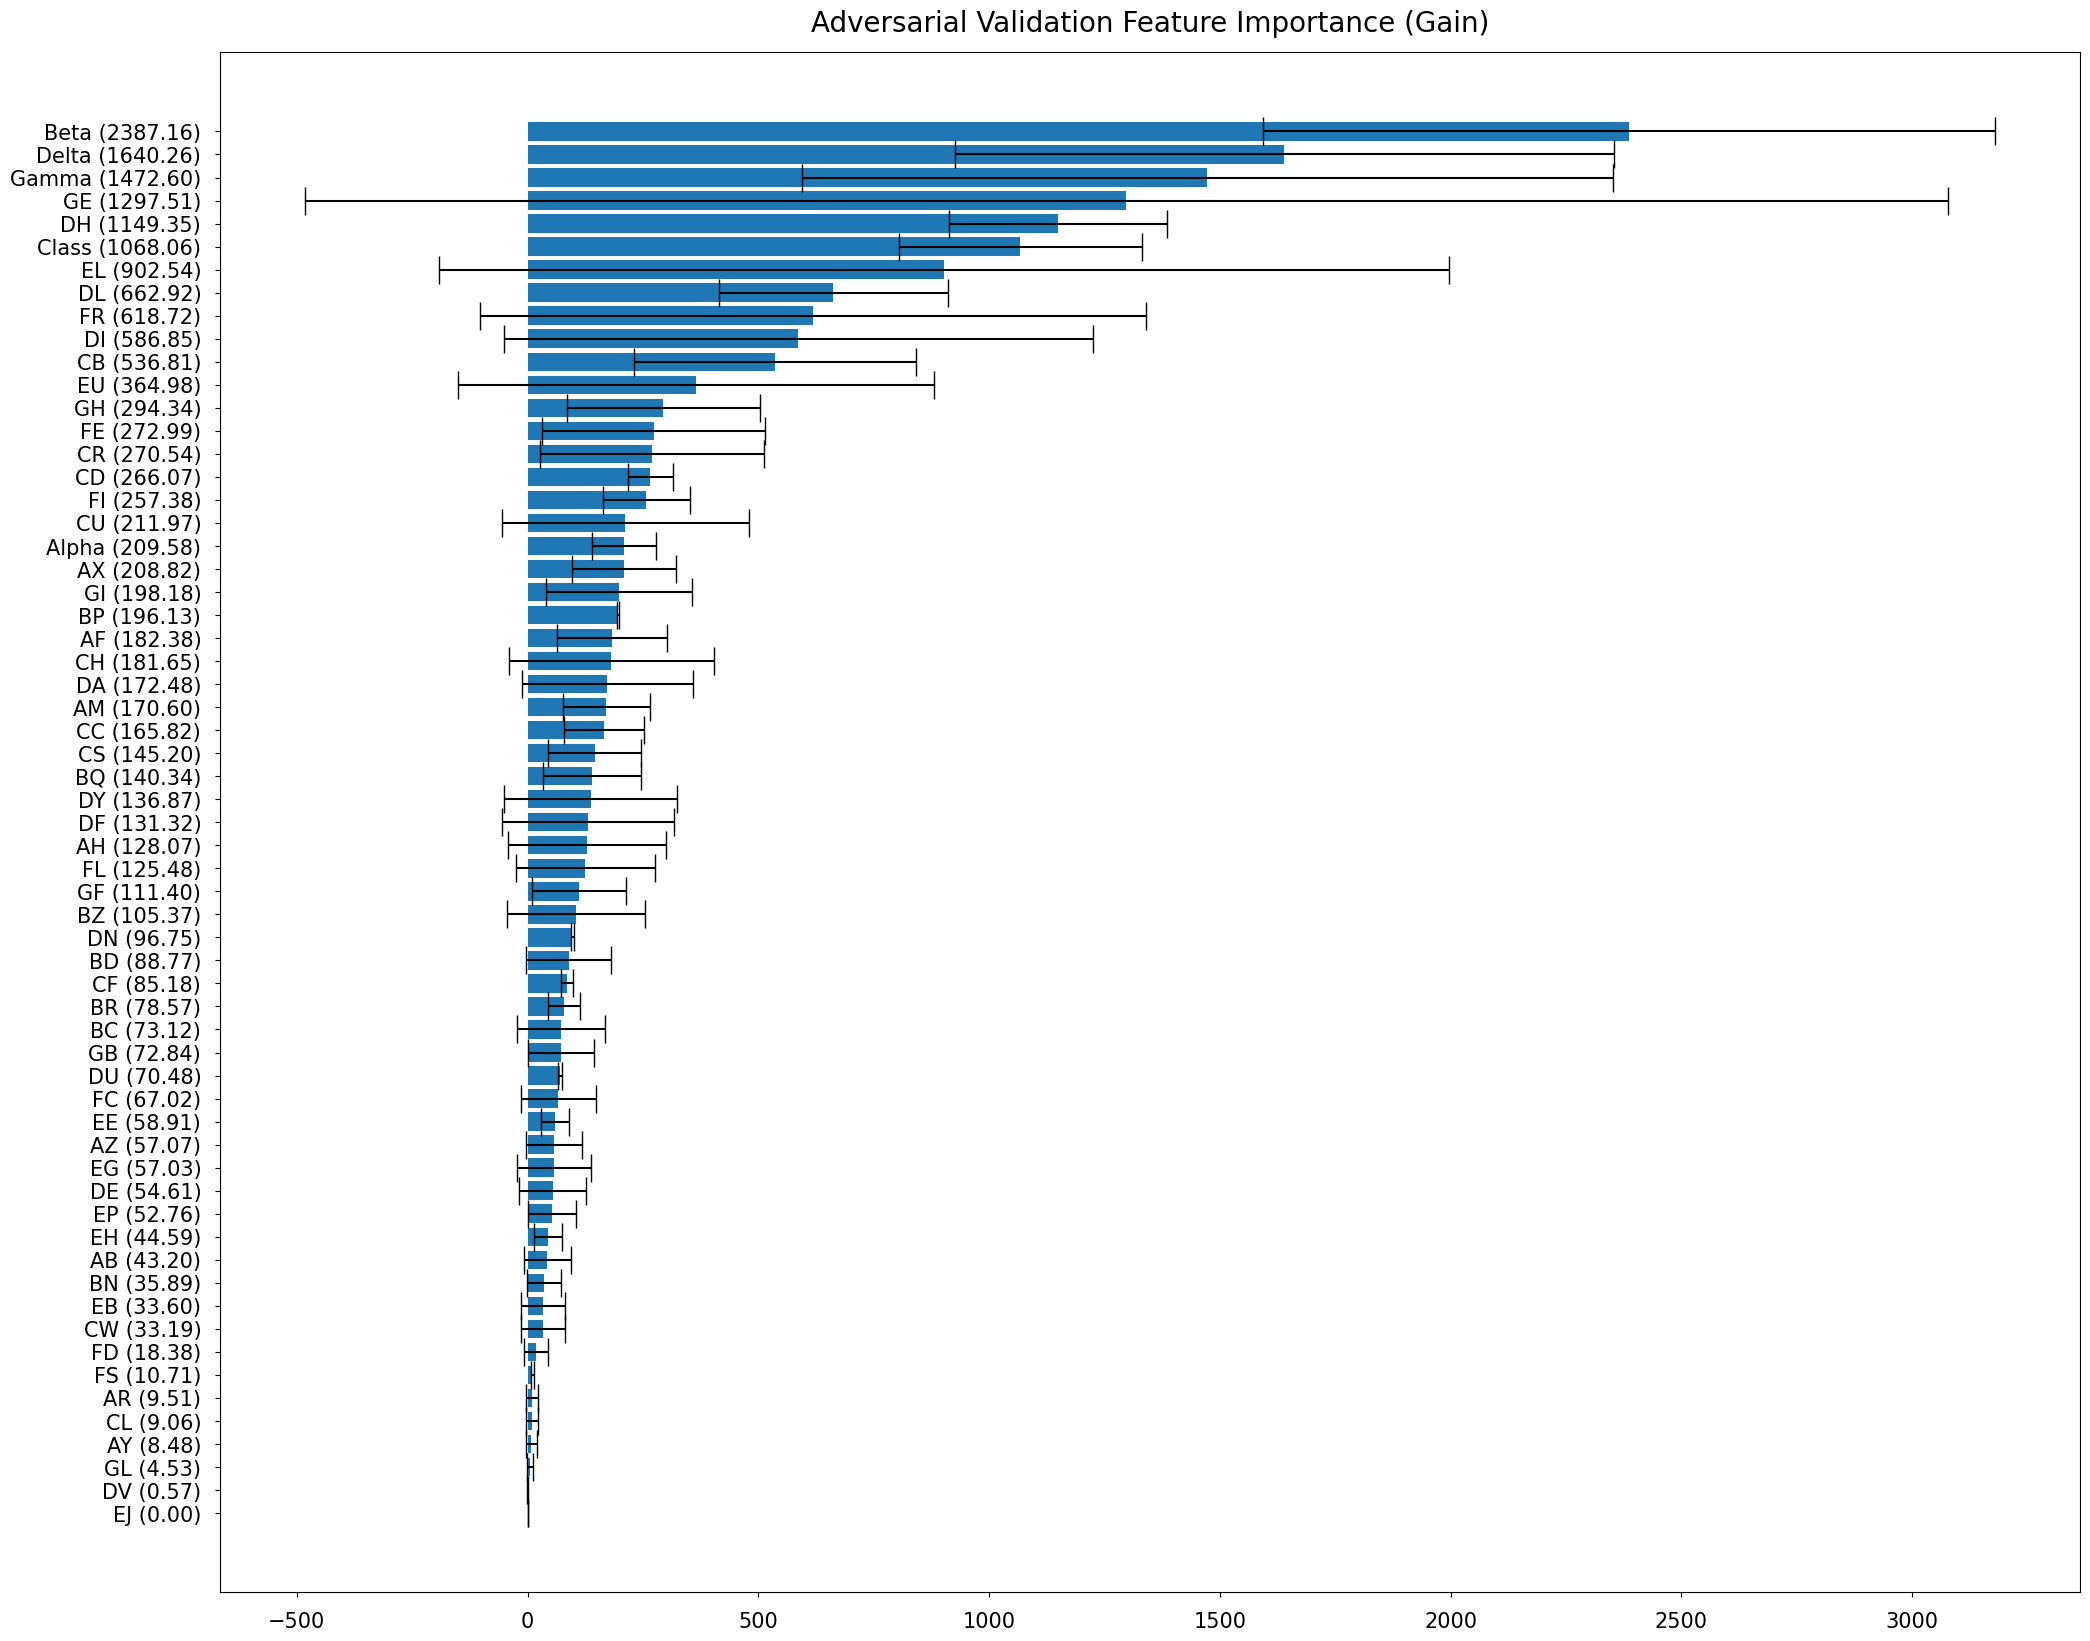

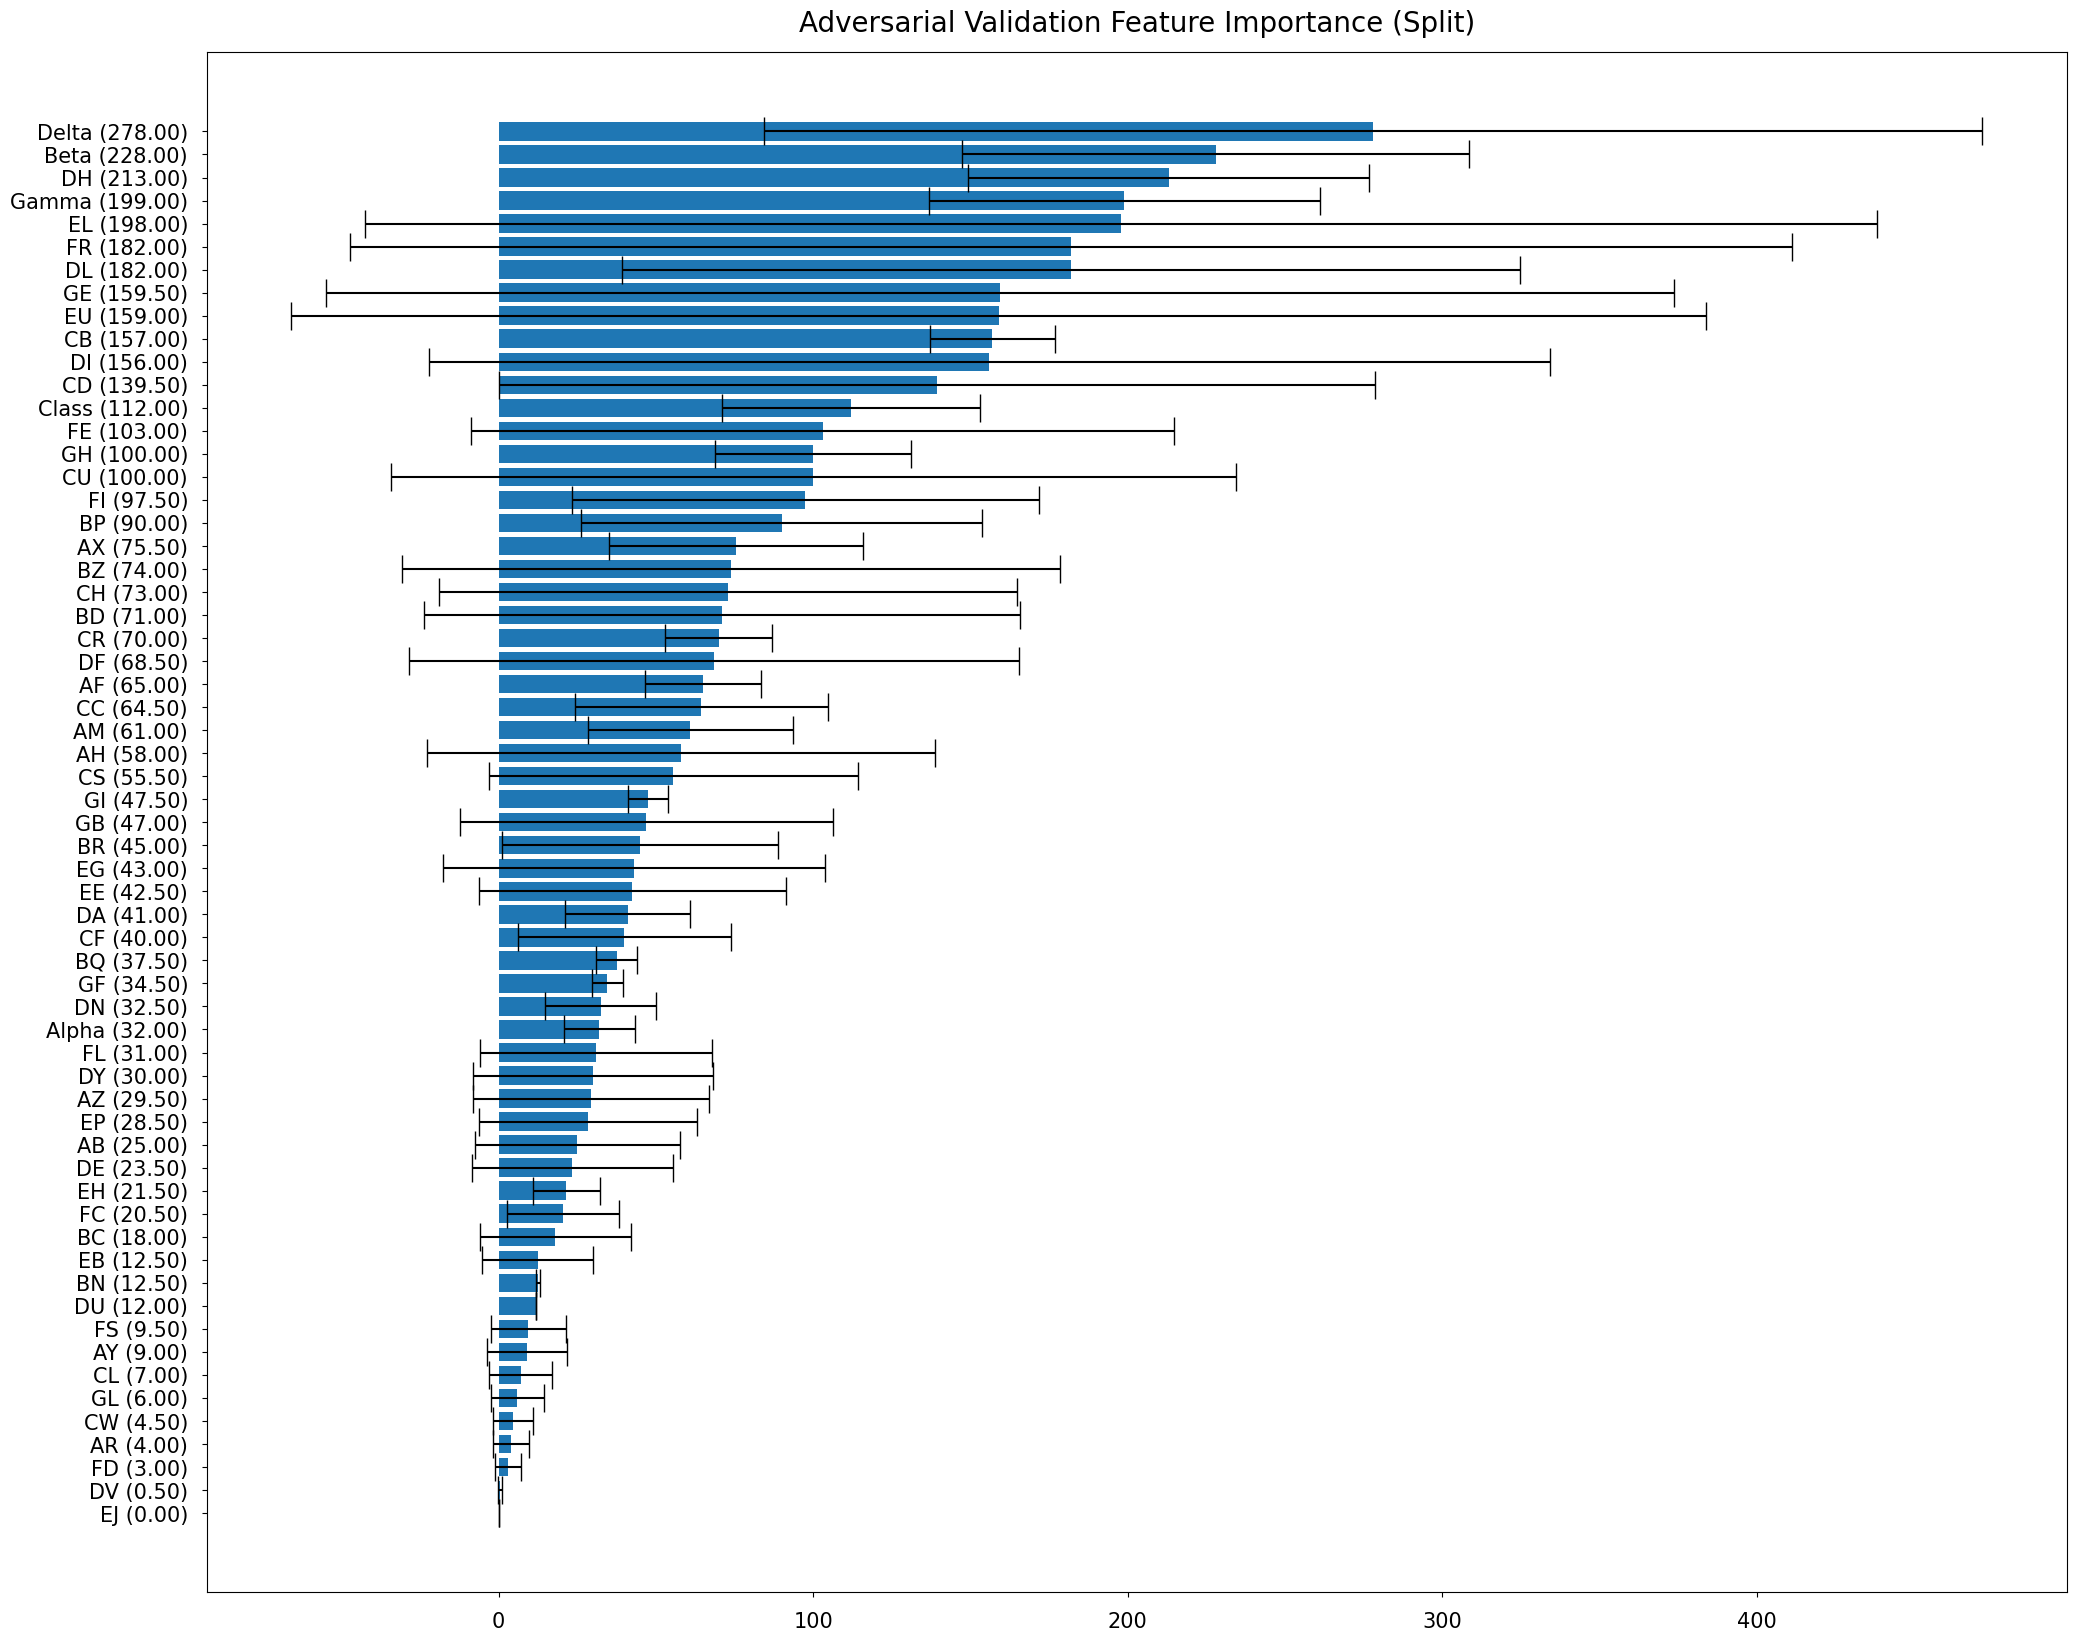

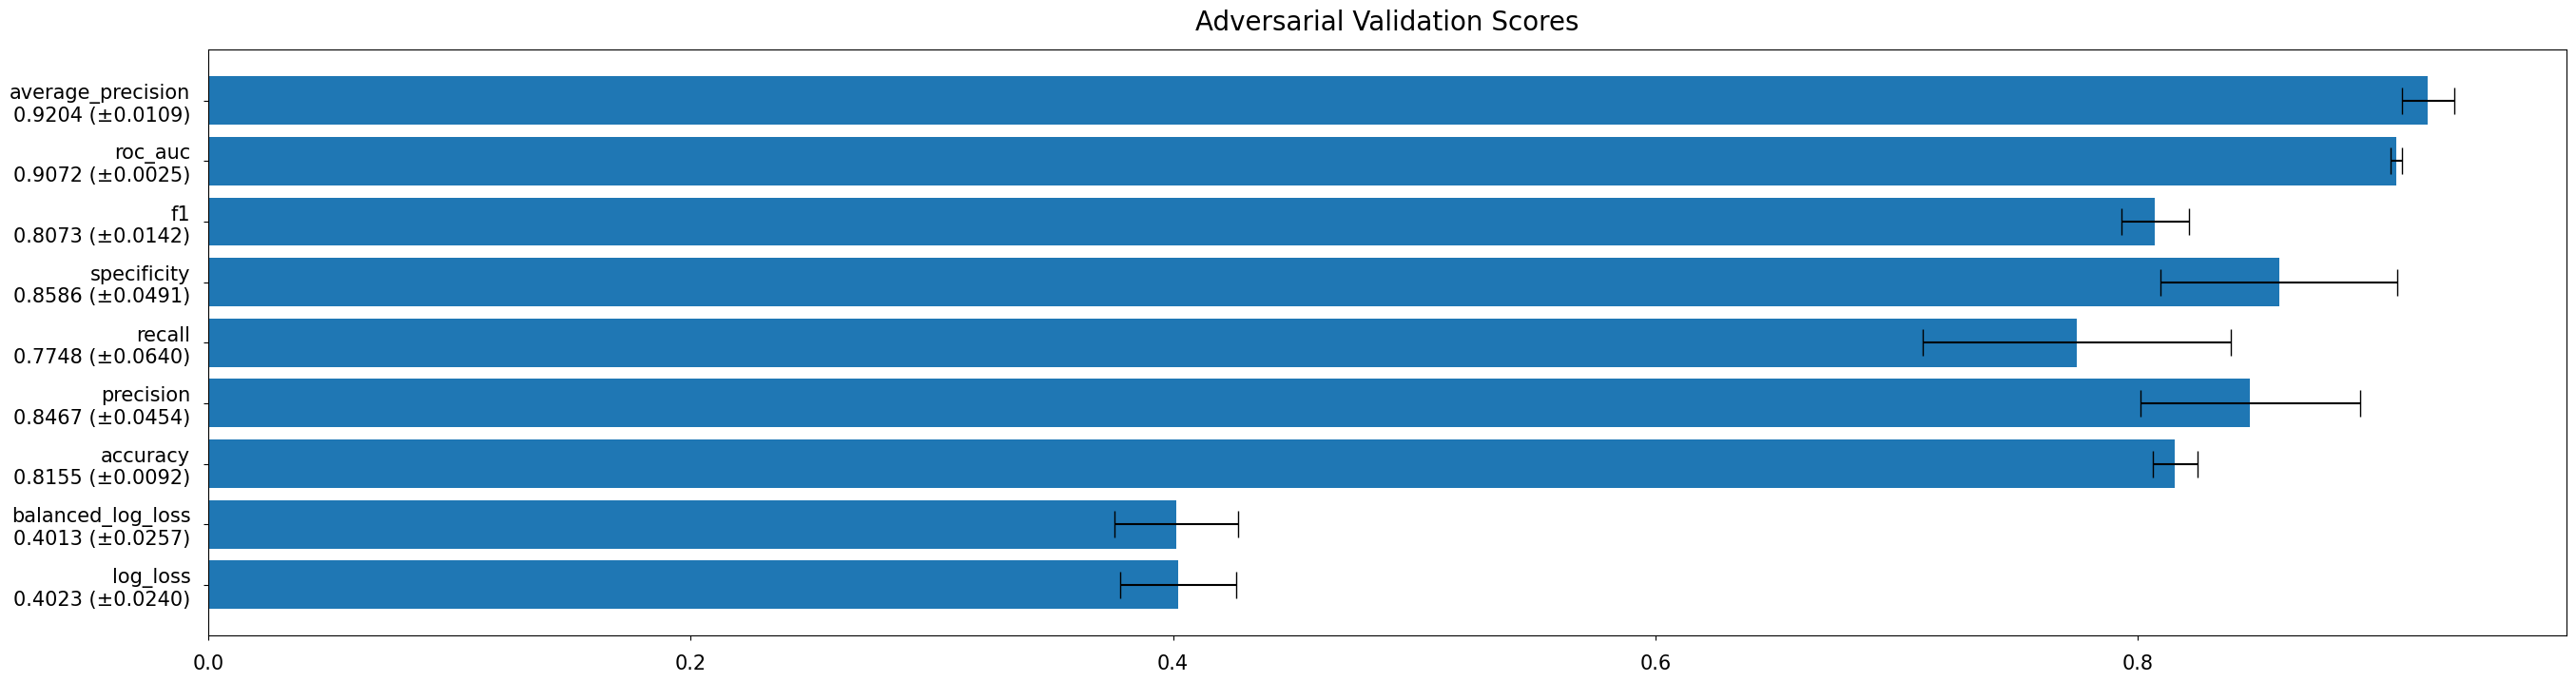

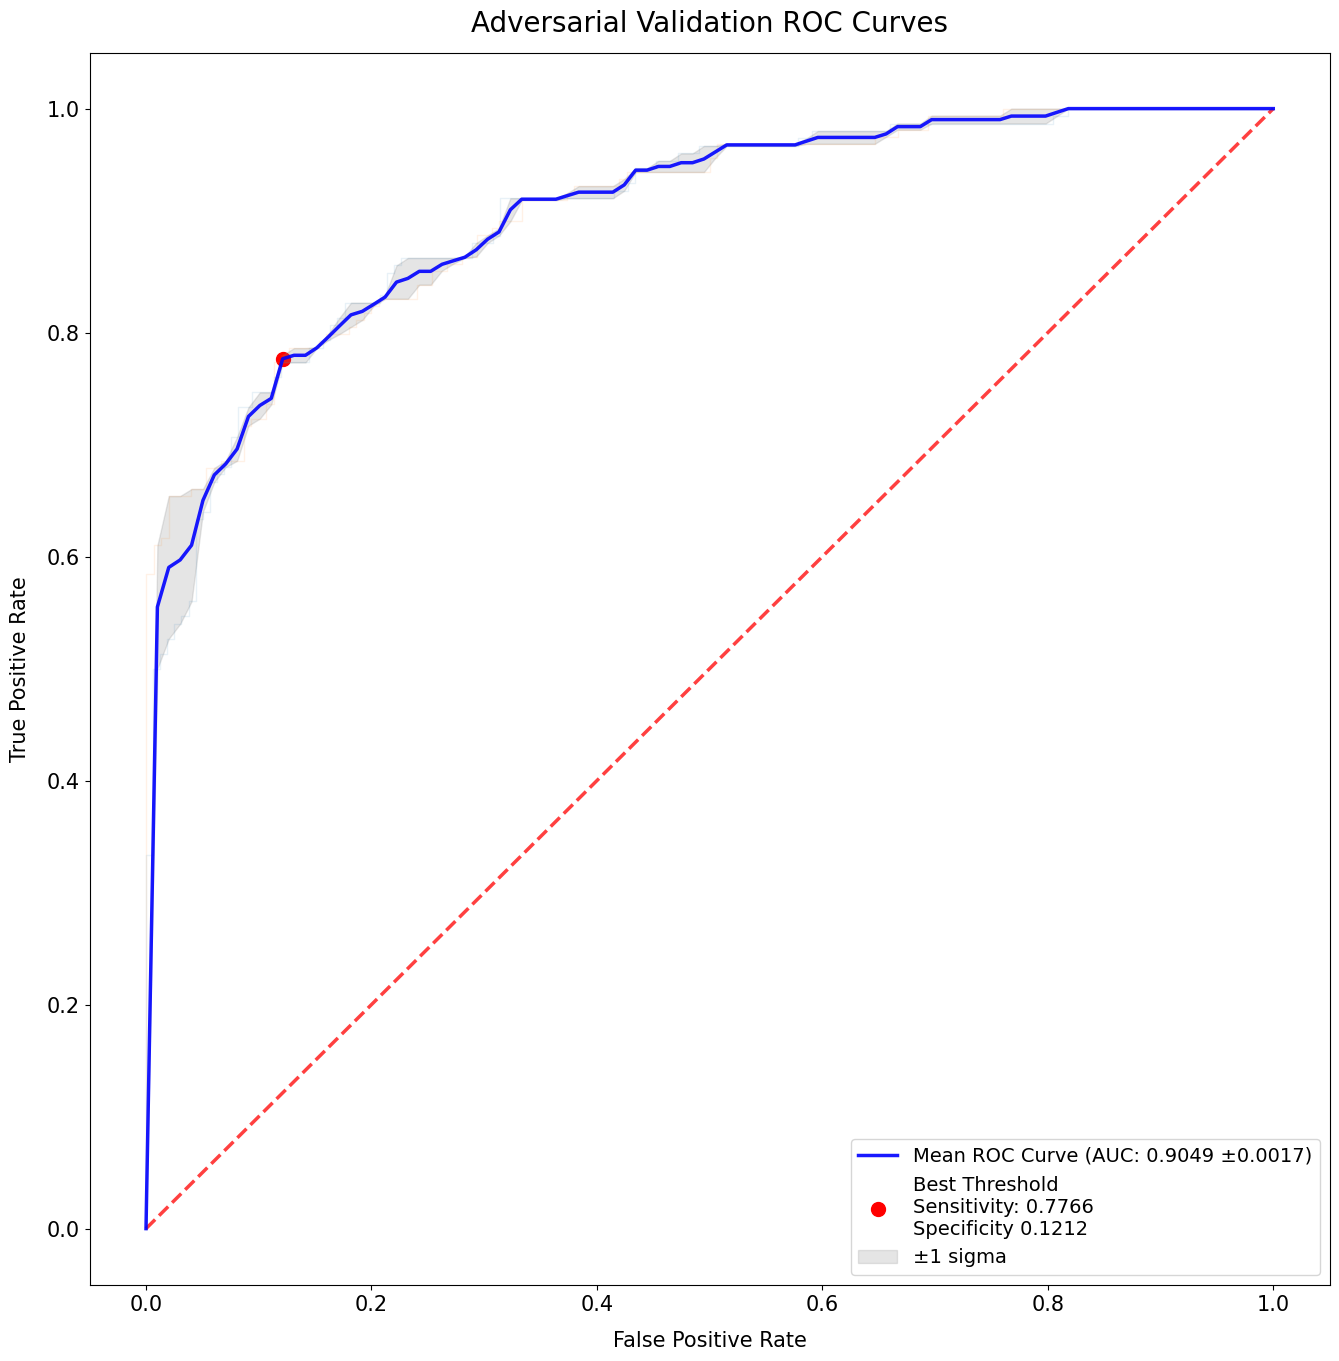

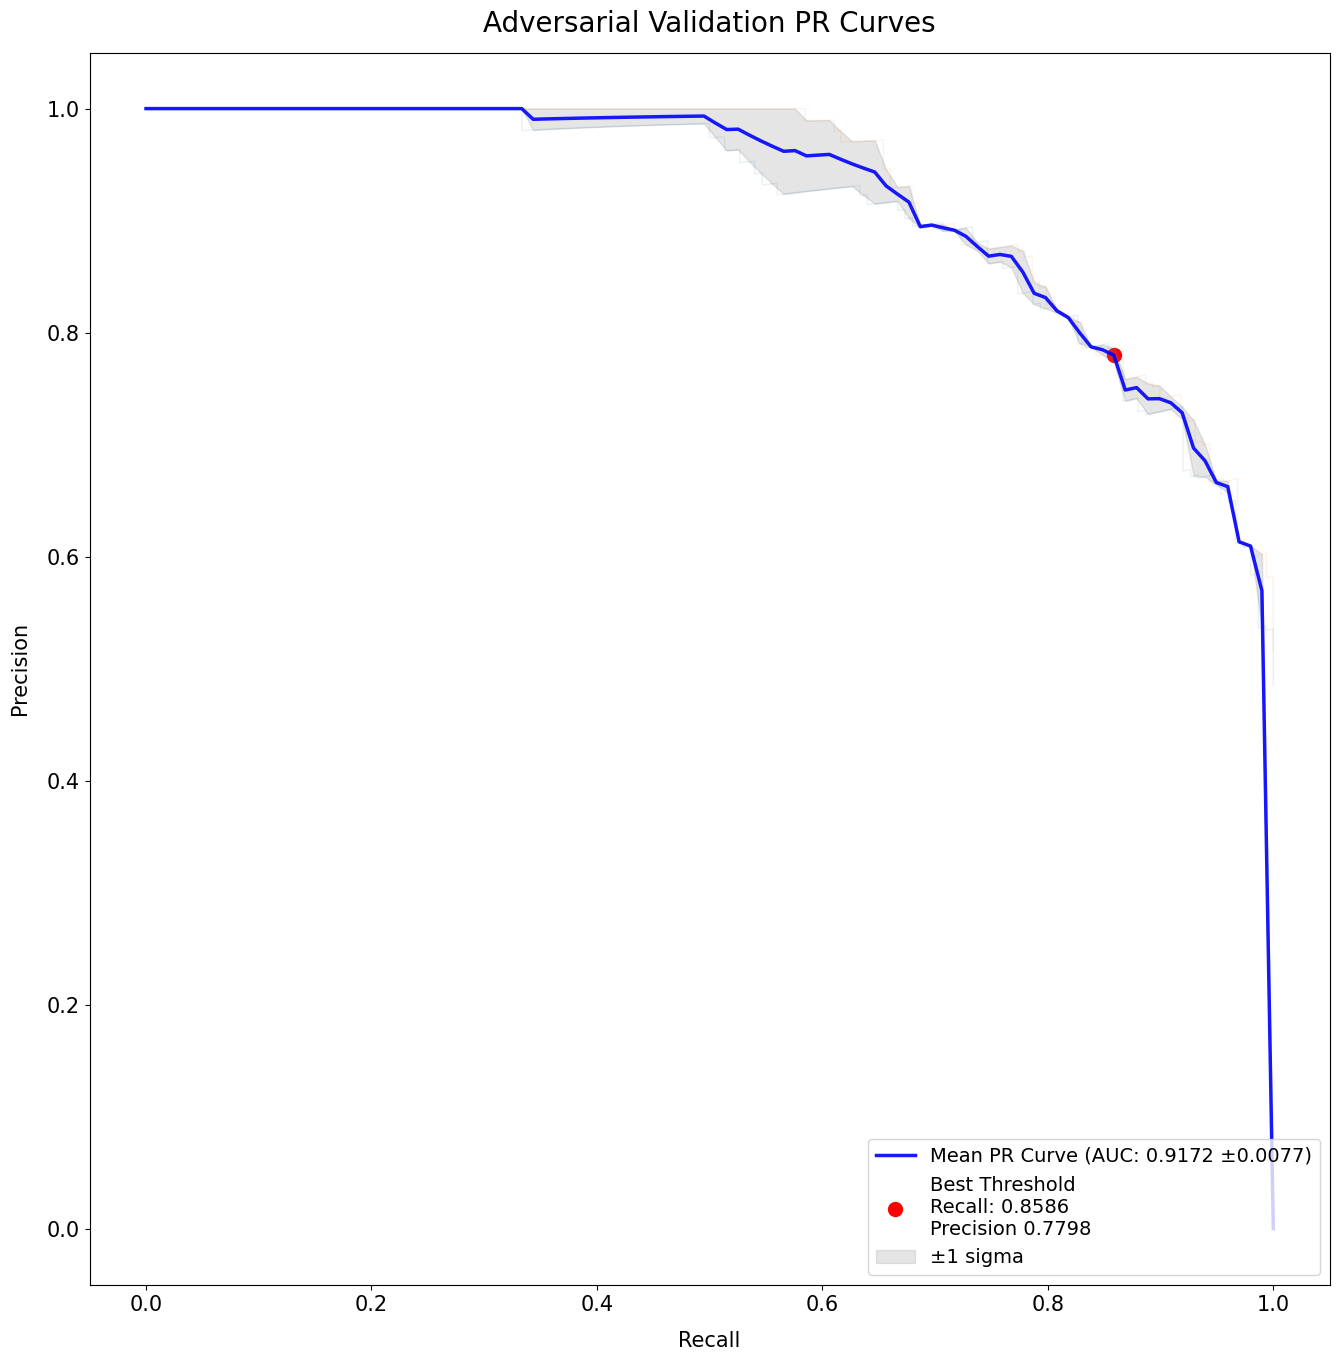

In [11]:
df_adversarial_validation = df_train.copy(deep=True)

# All Epsilon == nan cases are negative so they can be removed 
drop_na_epsilon = False
if drop_na_epsilon:
    df_adversarial_validation = df_adversarial_validation.loc[df_adversarial_validation['Epsilon'].notna()]
    
# Adversarial validation dataset is sorted by Epsilon because test set is ahead of training set
df_adversarial_validation.sort_values(by='Epsilon', ascending=True, inplace=True)
df_adversarial_validation.reset_index(drop=True, inplace=True)
# Adversarial validation splits are done from the middle after sorting the dataset by Epsilon
adversarial_validation_offset = df_adversarial_validation.shape[0] // 2
df_adversarial_validation.loc[:adversarial_validation_offset, 'adversarial_validation_target'] = 0
df_adversarial_validation.loc[adversarial_validation_offset:, 'adversarial_validation_target'] = 1
# Dataset has to be shuffled again because first N // 2 rows have the same class
df_adversarial_validation = df_adversarial_validation.sample(frac=1, random_state=42).reset_index(drop=True)
adversarial_validation_target = 'adversarial_validation_target'

df_adversarial_validation['fold1'] = 0
df_adversarial_validation.loc[:adversarial_validation_offset, 'fold1'] = 1
df_adversarial_validation['fold2'] = 0
df_adversarial_validation.loc[adversarial_validation_offset:, 'fold2'] = 1
adversarial_validation_folds = ['fold1', 'fold2']

adversarial_validation_scores = []
adversarial_validation_curves = []

df_adversarial_validation_feature_importance_gain = pd.DataFrame(
    data=np.zeros((len(features), len(adversarial_validation_folds))),
    index=features,
    columns=adversarial_validation_folds
)
df_adversarial_validation_feature_importance_split = pd.DataFrame(
    data=np.zeros((len(features), len(adversarial_validation_folds))),
    index=features,
    columns=adversarial_validation_folds
)

for fold in adversarial_validation_folds:
    
    training_idx = df_adversarial_validation[fold] == 0
    validation_idx = df_adversarial_validation[fold] == 1
    
    training_dataset = lgb.Dataset(
        df_adversarial_validation.loc[training_idx, features],
        label=df_adversarial_validation.loc[training_idx, adversarial_validation_target],
    )
    validation_dataset = lgb.Dataset(
        df_adversarial_validation.loc[validation_idx, features],
        label=df_adversarial_validation.loc[validation_idx, adversarial_validation_target],
    )

    model = lgb.train(
        params={
            'num_leaves': 8,
            'learning_rate': 0.01,
            'bagging_fraction': 1.0,
            'bagging_freq': 1,
            'feature_fraction': 1.0,
            'feature_fraction_bynode': 1.0,
            'min_data_in_leaf': 8,
            'min_gain_to_split': 0,
            'lambda_l1': 0.,
            'lambda_l2': 0.,
            'max_bin': 255,
            'max_depth': -1,
            'boost_from_average': True,
            'objective': 'binary',
            'metric': 'auc',
            'seed': 42,
            'feature_fraction_seed': 42,
            'bagging_seed': 42,
            'drop_seed': 42,
            'data_random_seed': 42,
            'boosting_type': 'gbdt',
            'verbose': 1,
            'n_jobs': -1,
        },
        train_set=training_dataset,
        valid_sets=[training_dataset, validation_dataset],
        num_boost_round=10000,
        callbacks=[
            lgb.early_stopping(500),
            lgb.log_evaluation(250)
        ]
    )

    df_adversarial_validation_feature_importance_gain[fold] = model.feature_importance(importance_type='gain')
    df_adversarial_validation_feature_importance_split[fold] = model.feature_importance(importance_type='split')
    
    val_predictions = model.predict(df_adversarial_validation.loc[validation_idx, features])
    df_adversarial_validation.loc[validation_idx, 'lightgbm_prediction'] = val_predictions
    val_scores = classification_scores(
        y_true=df_adversarial_validation.loc[validation_idx, adversarial_validation_target],
        y_pred=df_adversarial_validation.loc[validation_idx, 'lightgbm_prediction'],
    )
    adversarial_validation_scores.append(val_scores)
    print(f'Fold {fold} - Validation Scores: {json.dumps(val_scores, indent=2)}')
    val_curves = classification_curves(
        y_true=df_adversarial_validation.loc[validation_idx, adversarial_validation_target],
        y_pred=df_adversarial_validation.loc[validation_idx, 'lightgbm_prediction'],
    )
    adversarial_validation_curves.append(val_curves)
    
df_adversarial_validation_scores = pd.DataFrame(adversarial_validation_scores)
print(
    f'''
    Adversarial Validation Mean Validation Scores
    {json.dumps(df_adversarial_validation_scores.mean(axis=0).to_dict(), indent=2)}
    and Standard Deviations
    ±{json.dumps(df_adversarial_validation_scores.std(axis=0).to_dict(), indent=2)}
    '''
)

adversarial_validation_oof_scores = classification_scores(
    y_true=df_adversarial_validation.loc[:, adversarial_validation_target],
    y_pred=df_adversarial_validation.loc[:, 'lightgbm_prediction'],
)
print(f'OOF Scores: {json.dumps(adversarial_validation_oof_scores, indent=2)}')

for importance_type, df_feature_importance in zip(['gain', 'split'], [df_adversarial_validation_feature_importance_gain, df_adversarial_validation_feature_importance_split]):
    df_feature_importance['mean'] = df_feature_importance[adversarial_validation_folds].mean(axis=1)
    df_feature_importance['std'] = df_feature_importance[adversarial_validation_folds].std(axis=1).fillna(0)
    df_feature_importance.sort_values(by='mean', ascending=False, inplace=True)
    visualize_feature_importance(
        df_feature_importance=df_feature_importance,
        title=f'Adversarial Validation Feature Importance ({importance_type.capitalize()})'
    )

visualize_scores(df_scores=df_adversarial_validation_scores, title='Adversarial Validation Scores')
visualize_roc_curves([curve['roc'] for curve in adversarial_validation_curves], title='Adversarial Validation ROC Curves')
visualize_pr_curves([curve['pr'] for curve in adversarial_validation_curves], title='Adversarial Validation PR Curves')

del df_adversarial_validation, adversarial_validation_offset, adversarial_validation_target
del adversarial_validation_scores, adversarial_validation_curves
del df_adversarial_validation_feature_importance_gain, df_adversarial_validation_feature_importance_split
del df_adversarial_validation_scores, adversarial_validation_oof_scores

In [12]:
def get_feature_dependencies(df, independent_variable, dependent_variable):
    
    independent_variable_unique_counts = []
        
    for value in df[independent_variable].unique():
        independent_variable_unique_counts.append(df.loc[df[independent_variable] == value][dependent_variable].value_counts().shape[0])

    df_unique_counts = pd.DataFrame(data=independent_variable_unique_counts, index=df[independent_variable].unique(), columns=[f'{dependent_variable}_unique_count'])
    df_unique_counts = df_unique_counts.sort_values(by=f'{dependent_variable}_unique_count', ascending=False)
    
    return df_unique_counts


In [13]:
df_train_feature_statistics = df_train[features].agg(['var', 'std', 'nunique', lambda x: x.isnull().sum()]).T
df_train_feature_statistics.sort_values(by='var', ascending=False, inplace=True)
df_train_feature_statistics.tail(50)

var           std  nunique  <lambda>
DE     5.133008e+09  71645.010717    616.0       0.0
BP     1.883968e+09  43404.695656    612.0       0.0
CC     1.860743e+09  43136.331111    602.0       3.0
BQ     1.371682e+09  37036.226875    515.0      60.0
GE     1.065527e+09  32642.409818    264.0       0.0
FC     8.400209e+08  28983.113555    600.0       1.0
DI     5.227802e+08  22864.387635    571.0       0.0
AM     5.069146e+08  22514.764634    605.0       0.0
CB     2.994594e+08  17304.896285    553.0       2.0
AH     2.154715e+08  14678.947104    227.0       0.0
GI     1.988215e+08  14100.408797    615.0       0.0
DL     1.774826e+08  13322.257861    604.0       0.0
FD     1.189605e+08  10906.899363    337.0       0.0
BC     8.597876e+07   9272.473358    259.0       0.0
EP     5.452875e+07   7384.358580    275.0       0.0
DU     4.289918e+07   6549.746912    253.0       1.0
CD     4.233717e+07   6506.701607    584.0       0.0
DA     2.988507e+07   5466.723710    611.0       0.0
DF     2.968491e+07   5448.386328    137.0       0.0
CS     2.451868e+07   4951.633915    576.0       0.0
CF     1.991588e+07   4462.720613    586.0       0.0
DY     1.626588e+07   4033.098562    590.0       0.0
CR     1.405699e+07   3749.265786    595.0       0.0
GH     7.027613e+06   2650.964528    596.0       0.0
DN     5.550947e+06   2356.044743    576.0       0.0
AR     4.023587e+06   2005.888114    130.0       0.0
GB     1.153836e+06   1074.167573    560.0       0.0
EB     7.695374e+05    877.232798    439.0       0.0
AZ     4.765962e+05    690.359477    484.0       0.0
AY     4.684422e+05    684.428383    148.0       0.0
DV     3.285434e+05    573.187088     39.0       0.0
FI     2.832382e+05    532.201244    498.0       0.0
EE     2.607416e+05    510.628652    513.0       0.0
EH     9.221253e+04    303.665162    127.0       0.0
CL     9.120207e+04    301.996809    123.0       0.0
AX     8.296374e+04    288.034270    427.0       0.0
FS     3.714513e+04    192.730719    161.0       2.0
AB     1.201562e+04    109.615804    217.0       0.0
CU     9.534888e+03     97.646753    307.0       0.0
DH     1.709197e+03     41.342435    191.0       0.0
CH     1.384338e+03     37.206698    135.0       0.0
FL     1.321639e+02     11.496257    388.0       1.0
GL     1.066471e+02     10.327010    355.0       1.0
BN     9.703605e+01      9.850688     53.0       0.0
Gamma  1.838315e+00      1.355845      8.0       0.0
Alpha  5.505325e-01      0.741979      4.0       0.0
Delta  3.656412e-01      0.604683      4.0       0.0
Beta   2.548307e-01      0.504808      3.0       0.0
EJ     2.307194e-01      0.480333      2.0       0.0
Class  1.446358e-01      0.380310      2.0       0.0

## 6. Training and Validation


        Fold: fold1
        Training Shape: (493, 55) - Target Mean: 0.1724
        Validation: (124, 55) - Target Mean: 0.1855
        
[LightGBM] [Info] Number of positive: 85, number of negative: 408
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7275
[LightGBM] [Info] Number of data points in the train set: 493, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.172414 -> initscore=-1.568616
[LightGBM] [Info] Start training from score -1.568616
Training until validation scores don't improve for 500 rounds
[250]	training's balanced_log_loss: 0.198941	valid_1's balanced_log_loss: 0.327714
[500]	training's balanced_log_loss: 0.10149	valid_1's balanced_log_loss: 0.276989
[750]	training's balanced_log_loss: 0.053109	valid_1's balanced_log_loss: 0.270577
[1000]	training's balanced_log_loss: 0.0288558	valid_1's balan

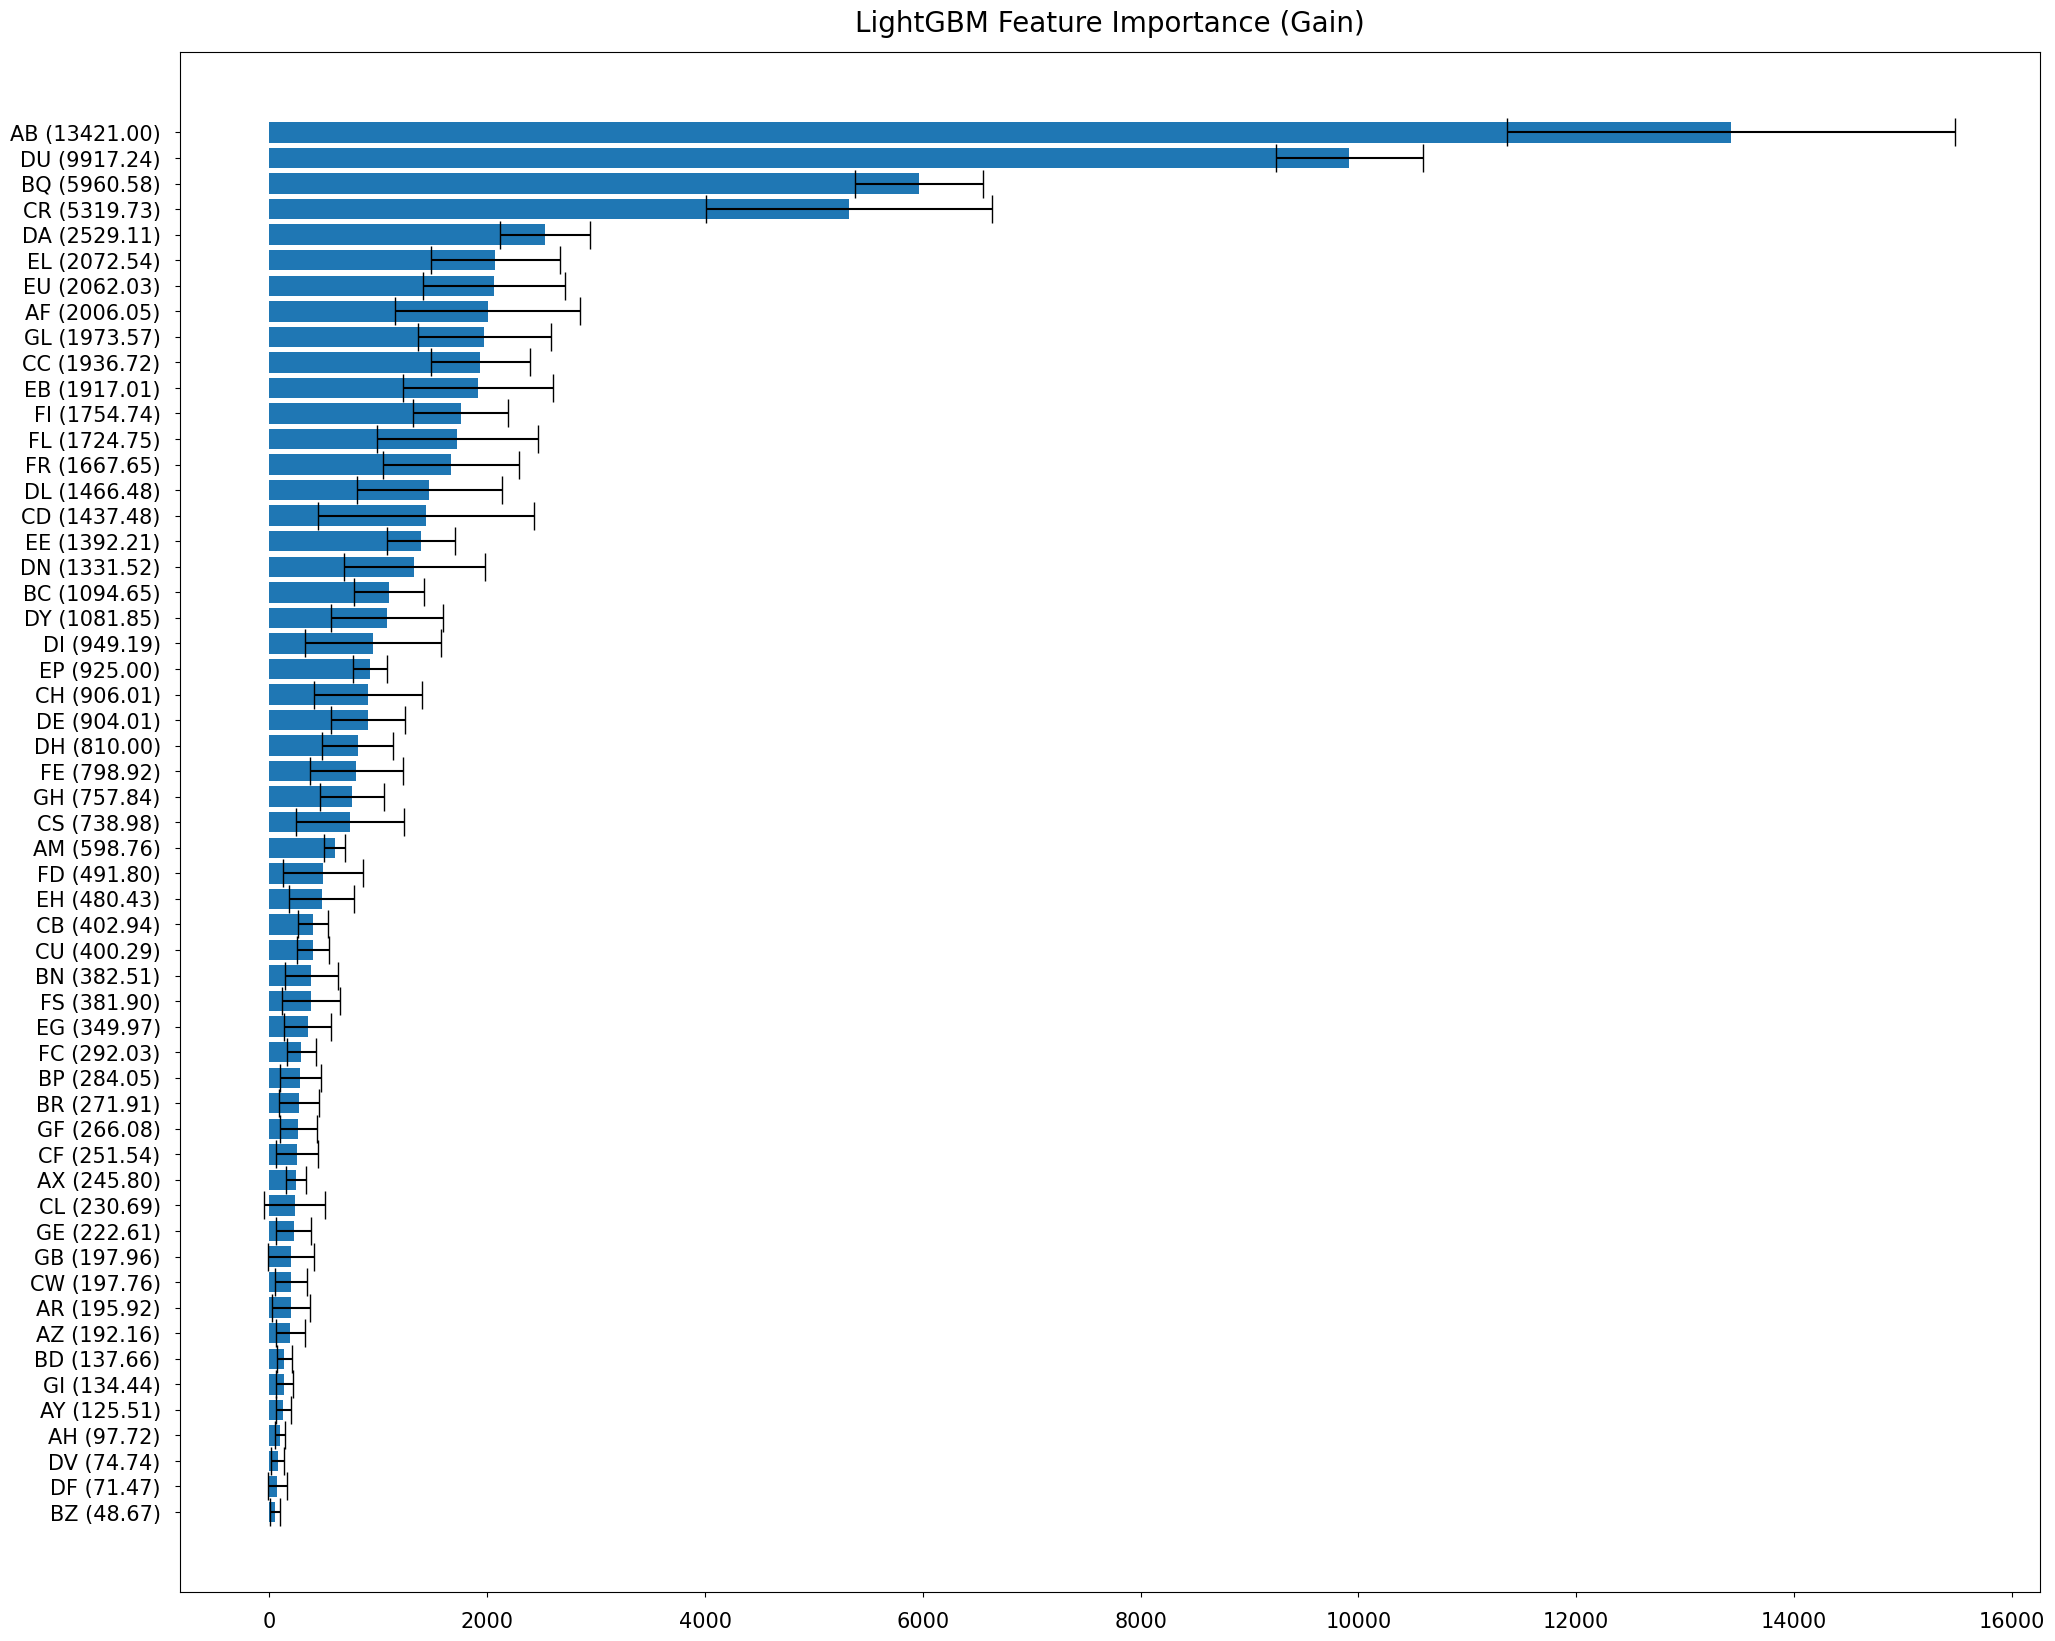

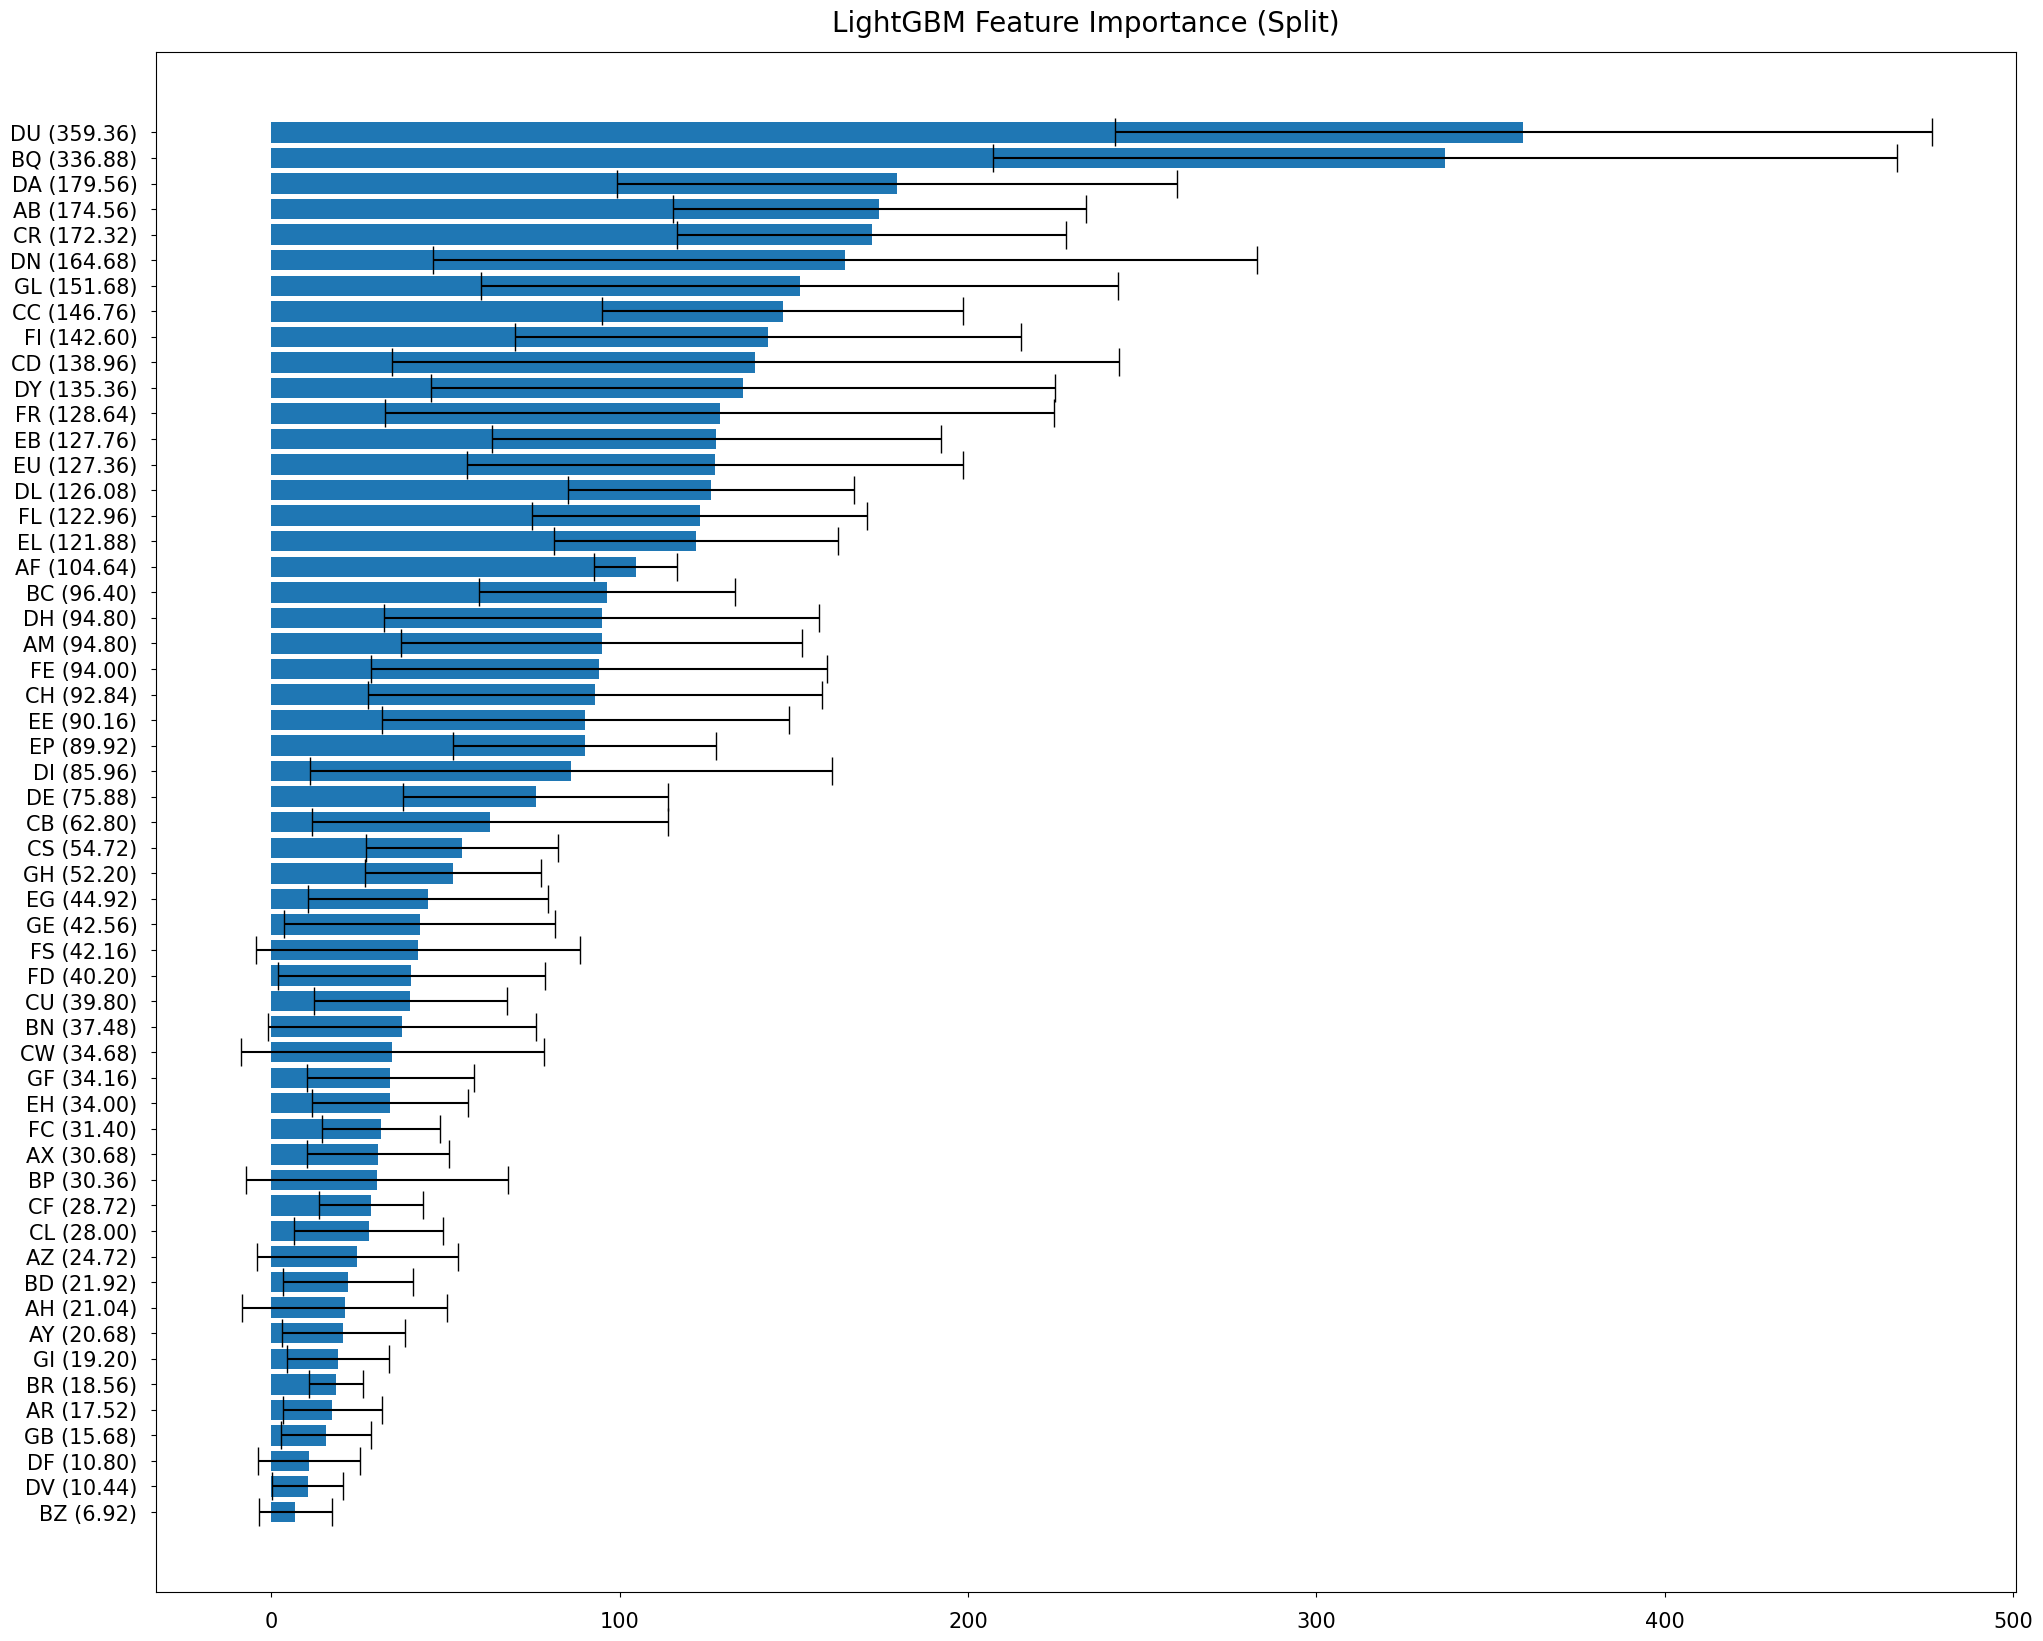

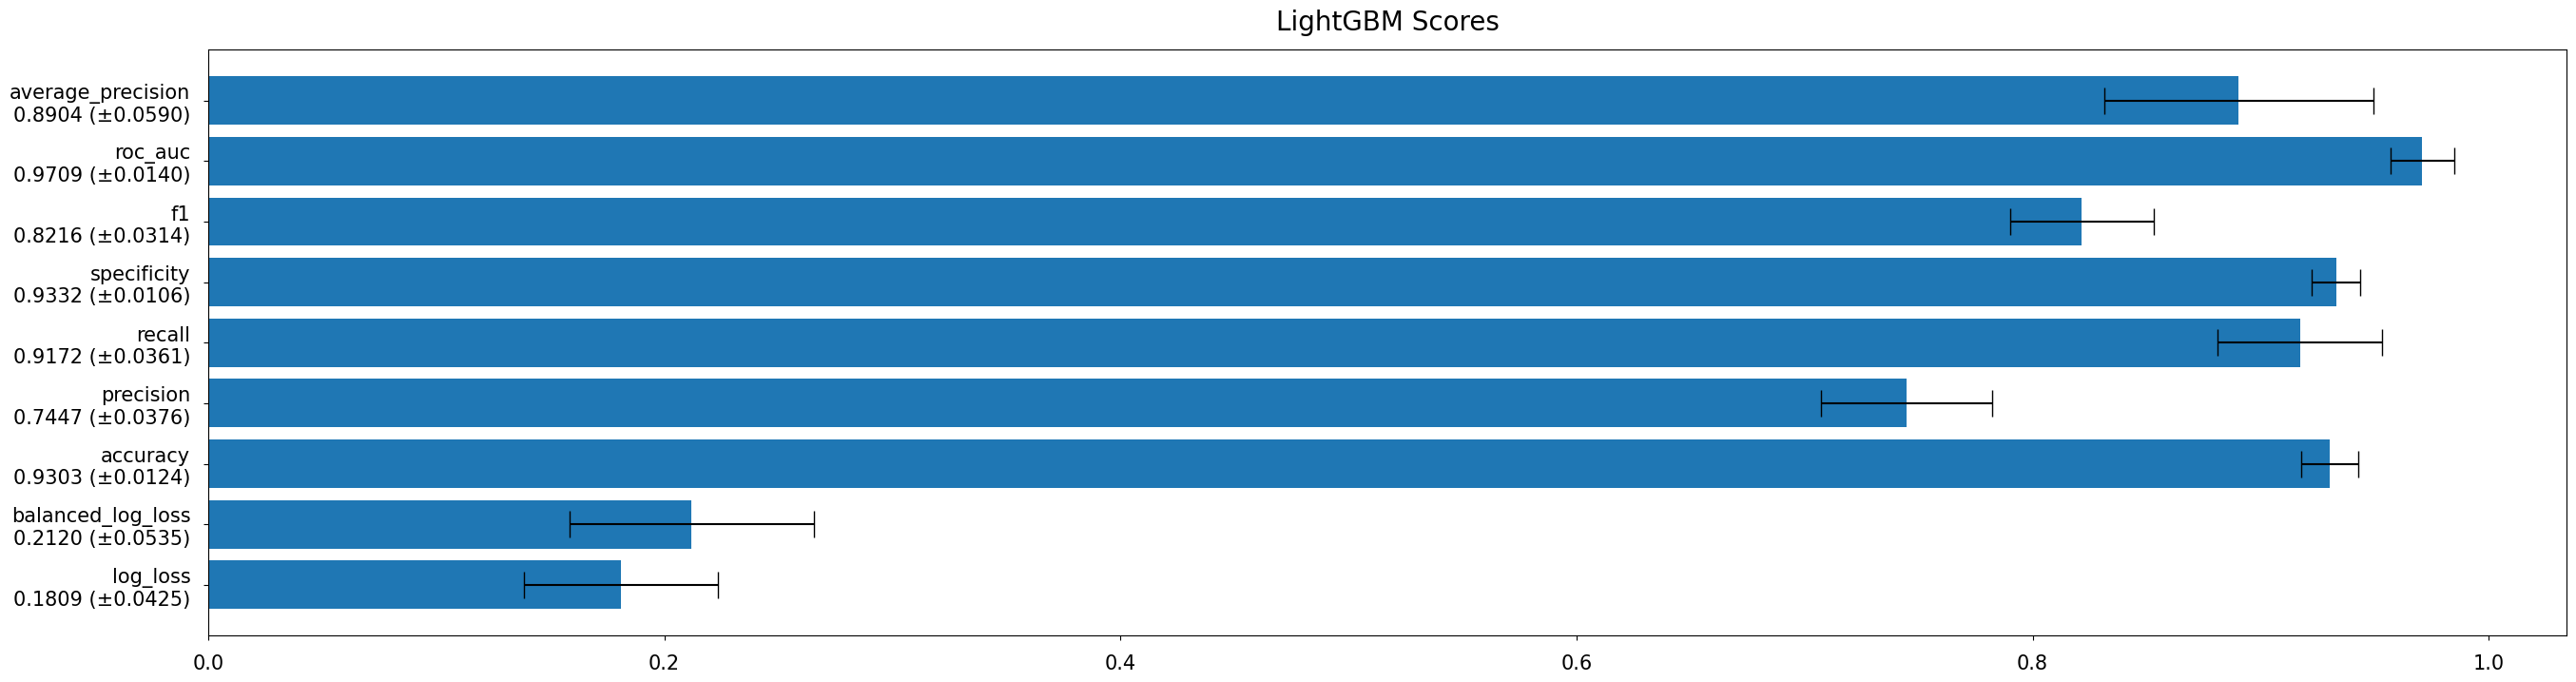

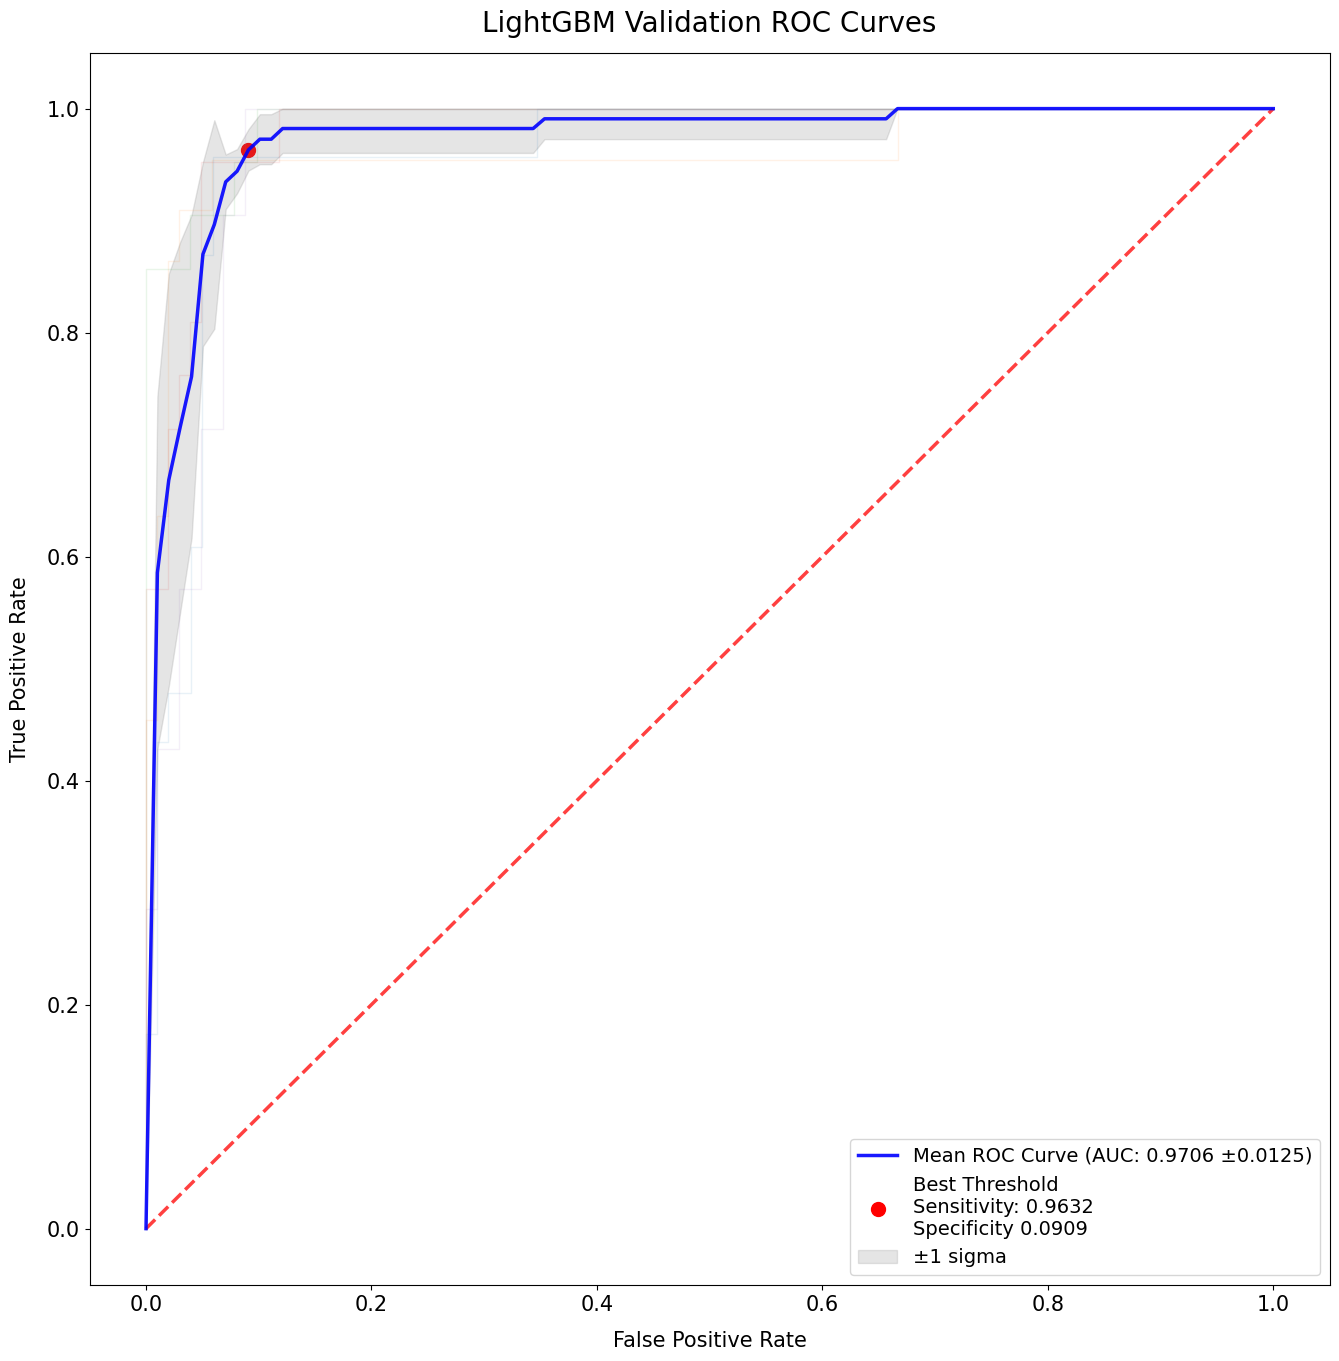

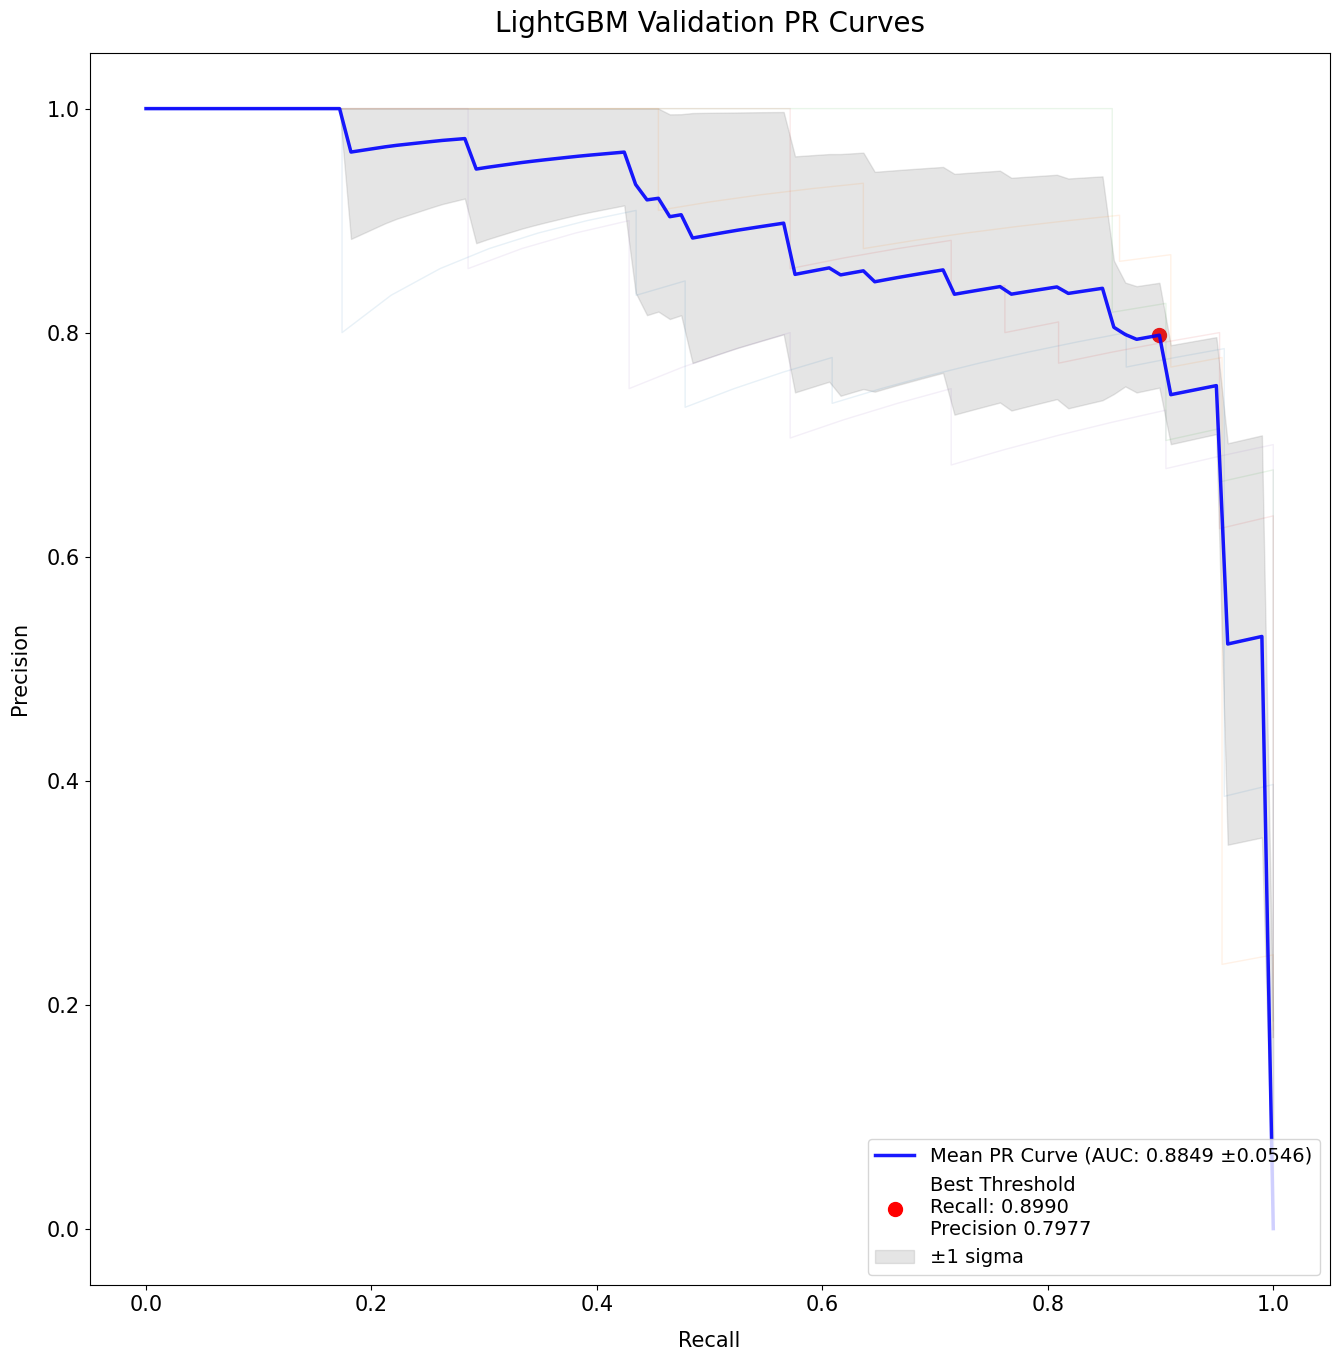

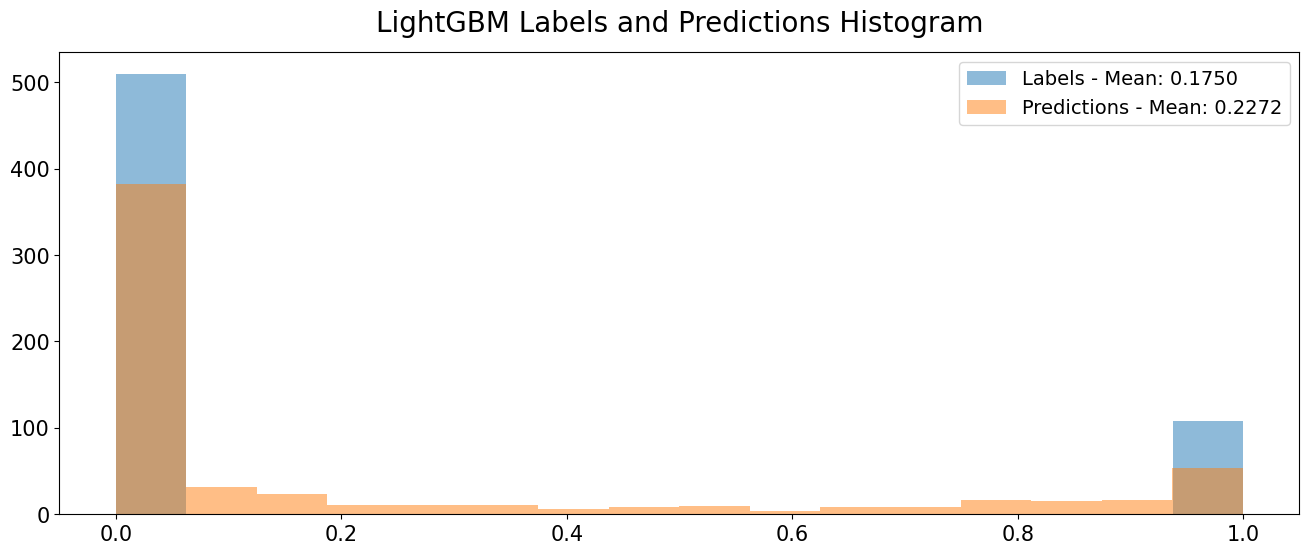

In [14]:
def lightgbm_balanced_log_loss(y_pred, training_dataset):
    
    """
    Calculate balanced log loss metric for LightGBM model

    Parameters
    ----------
    y_pred: numpy.ndarray of shape (n_samples)
        Predicted probabilities
        
    training_dataset: lightgbm.Dataset
        Training dataset

    Returns
    -------
    metric_name: str
        Name of the metric
        
    score: float
        Balanced log loss
        
    is_higher_better: bool
        Whether higher values of the score is better or not
    """

    metric_name = 'balanced_log_loss'
    score = balanced_log_loss(y_true=training_dataset.get_label(), y_pred=y_pred)
    is_higher_better = False
    
    return metric_name, score, is_higher_better


lightgbm_features = [
    'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ',
    'BC', 'BD', 'BN', 'BP', 'BQ', 'BR', 'BZ',
    'CB', 'CC', 'CD', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU', 'CW',
    'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
    'EB', 'EE', 'EG', 'EH', 'EL', 'EP', 'EU',
    'FC', 'FD', 'FE', 'FI', 'FL', 'FR', 'FS',
    'GB', 'GE', 'GF', 'GH', 'GI', 'GL',
    #'Epsilon_timestamp'
]
lightgbm_categorical_features = 'auto'
lightgbm_target = 'Class'
lightgbm_sample_weight = None
lightgbm_folds = ['fold1', 'fold2', 'fold3', 'fold4', 'fold5']
lightgbm_seeds = [42, 0, 1337, 1962022, 721991]

lightgbm_model_parameters = {
    'num_leaves': 5,
    'learning_rate': 0.01,
    'bagging_fraction': 0.9,
    'bagging_freq': 1,
    'feature_fraction': 0.9,
    'feature_fraction_bynode': 0.9,
    'min_data_in_leaf': 25,
    'min_gain_to_split': 0.00001,
    'lambda_l1': 0.,
    'lambda_l2': 0.,
    'max_bin': 255,
    'max_depth': -1,
    'boost_from_average': True,
    'objective': 'binary',
    'scale_pos_weight': 15,
    'metric': 'None',
    'seed': None,
    'feature_fraction_seed': None,
    'bagging_seed': None,
    'drop_seed': None,
    'data_random_seed': None,
    'boosting_type': 'gbdt',
    'verbose': 1,
    'n_jobs': -1,
}

lightgbm_fit_parameters = {
    'boosting_rounds': 10000,
    'log_evaluation': 250,
    'early_stopping': 500,
}

df_lightgbm_feature_importance_gain = pd.DataFrame(
    data=np.zeros((len(lightgbm_features), len(lightgbm_folds))),
    index=lightgbm_features,
    columns=lightgbm_folds
)
df_lightgbm_feature_importance_split = pd.DataFrame(
    data=np.zeros((len(lightgbm_features), len(lightgbm_folds))),
    index=lightgbm_features,
    columns=lightgbm_folds
)
lightgbm_scores = []
lightgbm_curves = []
lightgbm_best_iterations = []
lightgbm_positive_min_predictions = []
lightgbm_negative_max_predictions = []

for fold in lightgbm_folds:

    training_idx = df_train[fold] == 0
    validation_idx = df_train[fold] == 1

    print(
        f'''
        Fold: {fold}
        Training Shape: ({np.sum(training_idx)}, {len(lightgbm_features)}) - Target Mean: {df_train.loc[training_idx, lightgbm_target].mean():.4f}
        Validation: ({np.sum(validation_idx)}, {len(lightgbm_features)}) - Target Mean: {df_train.loc[validation_idx, lightgbm_target].mean():.4f}
        '''
    )
    
    val_predictions = np.zeros(np.sum(validation_idx))
    
    for seed in lightgbm_seeds:
                
        lightgbm_model_parameters.update({
            'seed': seed,
            'feature_fraction_seed': seed,
            'bagging_seed': seed,
            'drop_seed': seed,
            'data_random_seed': seed,
        })
        
        training_dataset = lgb.Dataset(
            df_train.loc[training_idx, lightgbm_features],
            label=df_train.loc[training_idx, lightgbm_target],
            weight=lightgbm_sample_weight,
            categorical_feature=lightgbm_categorical_features
        )
        validation_dataset = lgb.Dataset(
            df_train.loc[validation_idx, lightgbm_features],
            label=df_train.loc[validation_idx, lightgbm_target],
            weight=lightgbm_sample_weight,
            categorical_feature=lightgbm_categorical_features
        )

        model = lgb.train(
            params=lightgbm_model_parameters,
            train_set=training_dataset,
            valid_sets=[training_dataset, validation_dataset],
            num_boost_round=lightgbm_fit_parameters['boosting_rounds'],
            callbacks=[
                lgb.early_stopping(lightgbm_fit_parameters['early_stopping']),
                lgb.log_evaluation(lightgbm_fit_parameters['log_evaluation'])
            ],
            feval=lightgbm_balanced_log_loss
        )
        lightgbm_best_iterations.append(model.best_iteration)

        df_lightgbm_feature_importance_gain[fold] += (model.feature_importance(importance_type='gain') / len(lightgbm_seeds))
        df_lightgbm_feature_importance_split[fold] += (model.feature_importance(importance_type='split') / len(lightgbm_seeds))

        val_predictions += (model.predict(df_train.loc[validation_idx, lightgbm_features]) / len(lightgbm_seeds))
        
    df_train.loc[validation_idx, 'lightgbm_prediction'] = val_predictions
    val_scores = classification_scores(
        y_true=df_train.loc[validation_idx, lightgbm_target],
        y_pred=df_train.loc[validation_idx, 'lightgbm_prediction'],
    )
    lightgbm_scores.append(val_scores)
    print(f'Fold {fold} - Validation Scores: {json.dumps(val_scores, indent=2)}')
    val_curves = classification_curves(
        y_true=df_train.loc[validation_idx, lightgbm_target],
        y_pred=df_train.loc[validation_idx, 'lightgbm_prediction'],
    )
    lightgbm_curves.append(val_curves)
    lightgbm_positive_min_predictions.append(df_train.loc[validation_idx & df_train[lightgbm_target] == 1, 'lightgbm_prediction'].min())
    lightgbm_negative_max_predictions.append(df_train.loc[validation_idx & df_train[lightgbm_target] == 0, 'lightgbm_prediction'].max())

df_lightgbm_scores = pd.DataFrame(lightgbm_scores)
print(
    f'''
    LightGBM Mean Validation Scores
    {json.dumps(df_lightgbm_scores.mean(axis=0).to_dict(), indent=2)}
    and Standard Deviations
    ±{json.dumps(df_lightgbm_scores.std(axis=0).to_dict(), indent=2)}
    '''
)

oof_scores = classification_scores(
    y_true=df_train.loc[:, lightgbm_target],
    y_pred=df_train.loc[:, 'lightgbm_prediction'],
)
print(f'OOF Scores: {json.dumps(oof_scores, indent=2)}')
print(f'Best Iterations {lightgbm_best_iterations} - Mean: {np.mean(lightgbm_best_iterations):.2f} Std: {np.std(lightgbm_best_iterations):.2f} Min: {np.min(lightgbm_best_iterations)} Max: {np.max(lightgbm_best_iterations)}')
print(f'Positive Min Predictions {lightgbm_positive_min_predictions} - Mean: {np.mean(lightgbm_positive_min_predictions):.2f} Std: {np.std(lightgbm_positive_min_predictions):.2f} Min: {np.min(lightgbm_positive_min_predictions)} Max: {np.max(lightgbm_positive_min_predictions)}')
print(f'Negative Max Predictions {lightgbm_negative_max_predictions} - Mean: {np.mean(lightgbm_negative_max_predictions):.2f} Std: {np.std(lightgbm_negative_max_predictions):.2f} Min: {np.min(lightgbm_negative_max_predictions)} Max: {np.max(lightgbm_negative_max_predictions)}')

for importance_type, df_feature_importance in zip(['gain', 'split'], [df_lightgbm_feature_importance_gain, df_lightgbm_feature_importance_split]):
    df_feature_importance['mean'] = df_feature_importance[lightgbm_folds].mean(axis=1)
    df_feature_importance['std'] = df_feature_importance[lightgbm_folds].std(axis=1).fillna(0)
    df_feature_importance.sort_values(by='mean', ascending=False, inplace=True)
    visualize_feature_importance(
        df_feature_importance=df_feature_importance,
        title=f'LightGBM Feature Importance ({importance_type.capitalize()})'
    )

visualize_scores(df_scores=df_lightgbm_scores, title='LightGBM Scores')
visualize_roc_curves(roc_curves=[curve['roc'] for curve in lightgbm_curves], title='LightGBM Validation ROC Curves')
visualize_pr_curves(pr_curves=[curve['pr'] for curve in lightgbm_curves], title='LightGBM Validation PR Curves')
visualize_predictions(y_true=df_train['Class'], y_pred=df_train['lightgbm_prediction'], title='LightGBM Labels and Predictions Histogram')


        Fold: fold1
        Training Shape: (493, 55) - Target Mean: 0.1724
        Validation: (124, 55) - Target Mean: 0.1855
        
[0]	train-balanced_log_loss:0.68702	val-balanced_log_loss:0.68768
[250]	train-balanced_log_loss:0.21229	val-balanced_log_loss:0.32062
[500]	train-balanced_log_loss:0.10924	val-balanced_log_loss:0.26818
[750]	train-balanced_log_loss:0.06805	val-balanced_log_loss:0.25867
[1000]	train-balanced_log_loss:0.04986	val-balanced_log_loss:0.26281
[1250]	train-balanced_log_loss:0.04101	val-balanced_log_loss:0.26760
[1295]	train-balanced_log_loss:0.03977	val-balanced_log_loss:0.26908
[0]	train-balanced_log_loss:0.68715	val-balanced_log_loss:0.68803
[250]	train-balanced_log_loss:0.21054	val-balanced_log_loss:0.32453
[500]	train-balanced_log_loss:0.10658	val-balanced_log_loss:0.27123
[750]	train-balanced_log_loss:0.06685	val-balanced_log_loss:0.26898
[1000]	train-balanced_log_loss:0.04963	val-balanced_log_loss:0.27535
[1043]	train-balanced_log_loss:0.04776	val-bal

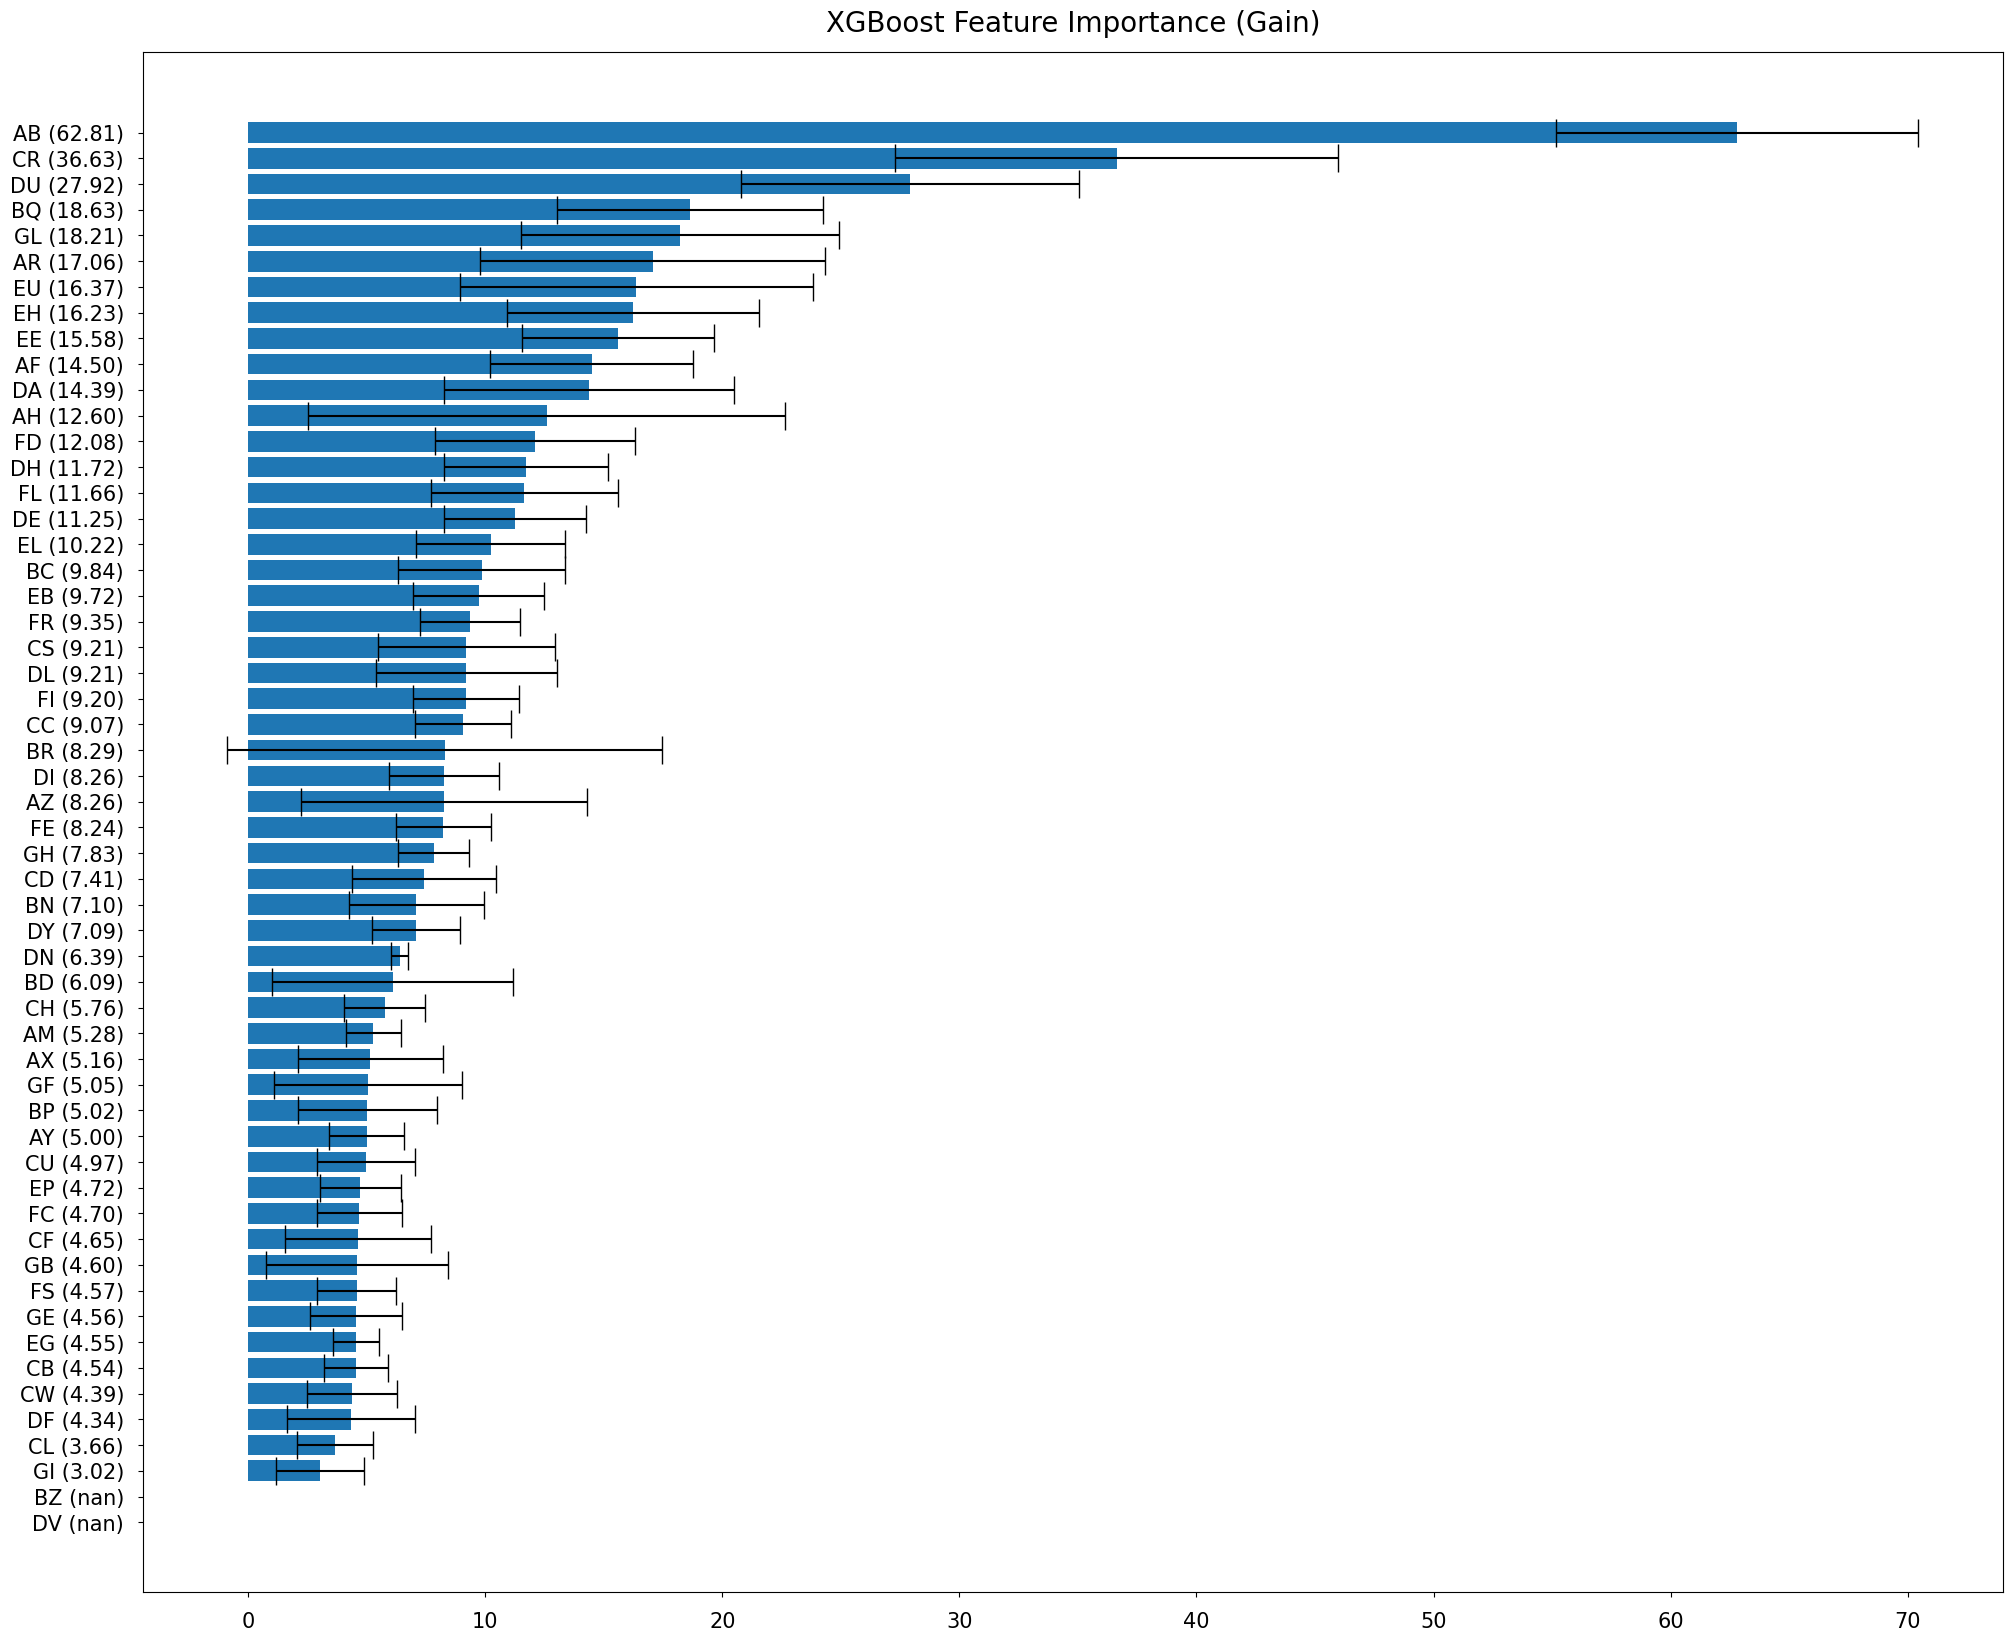

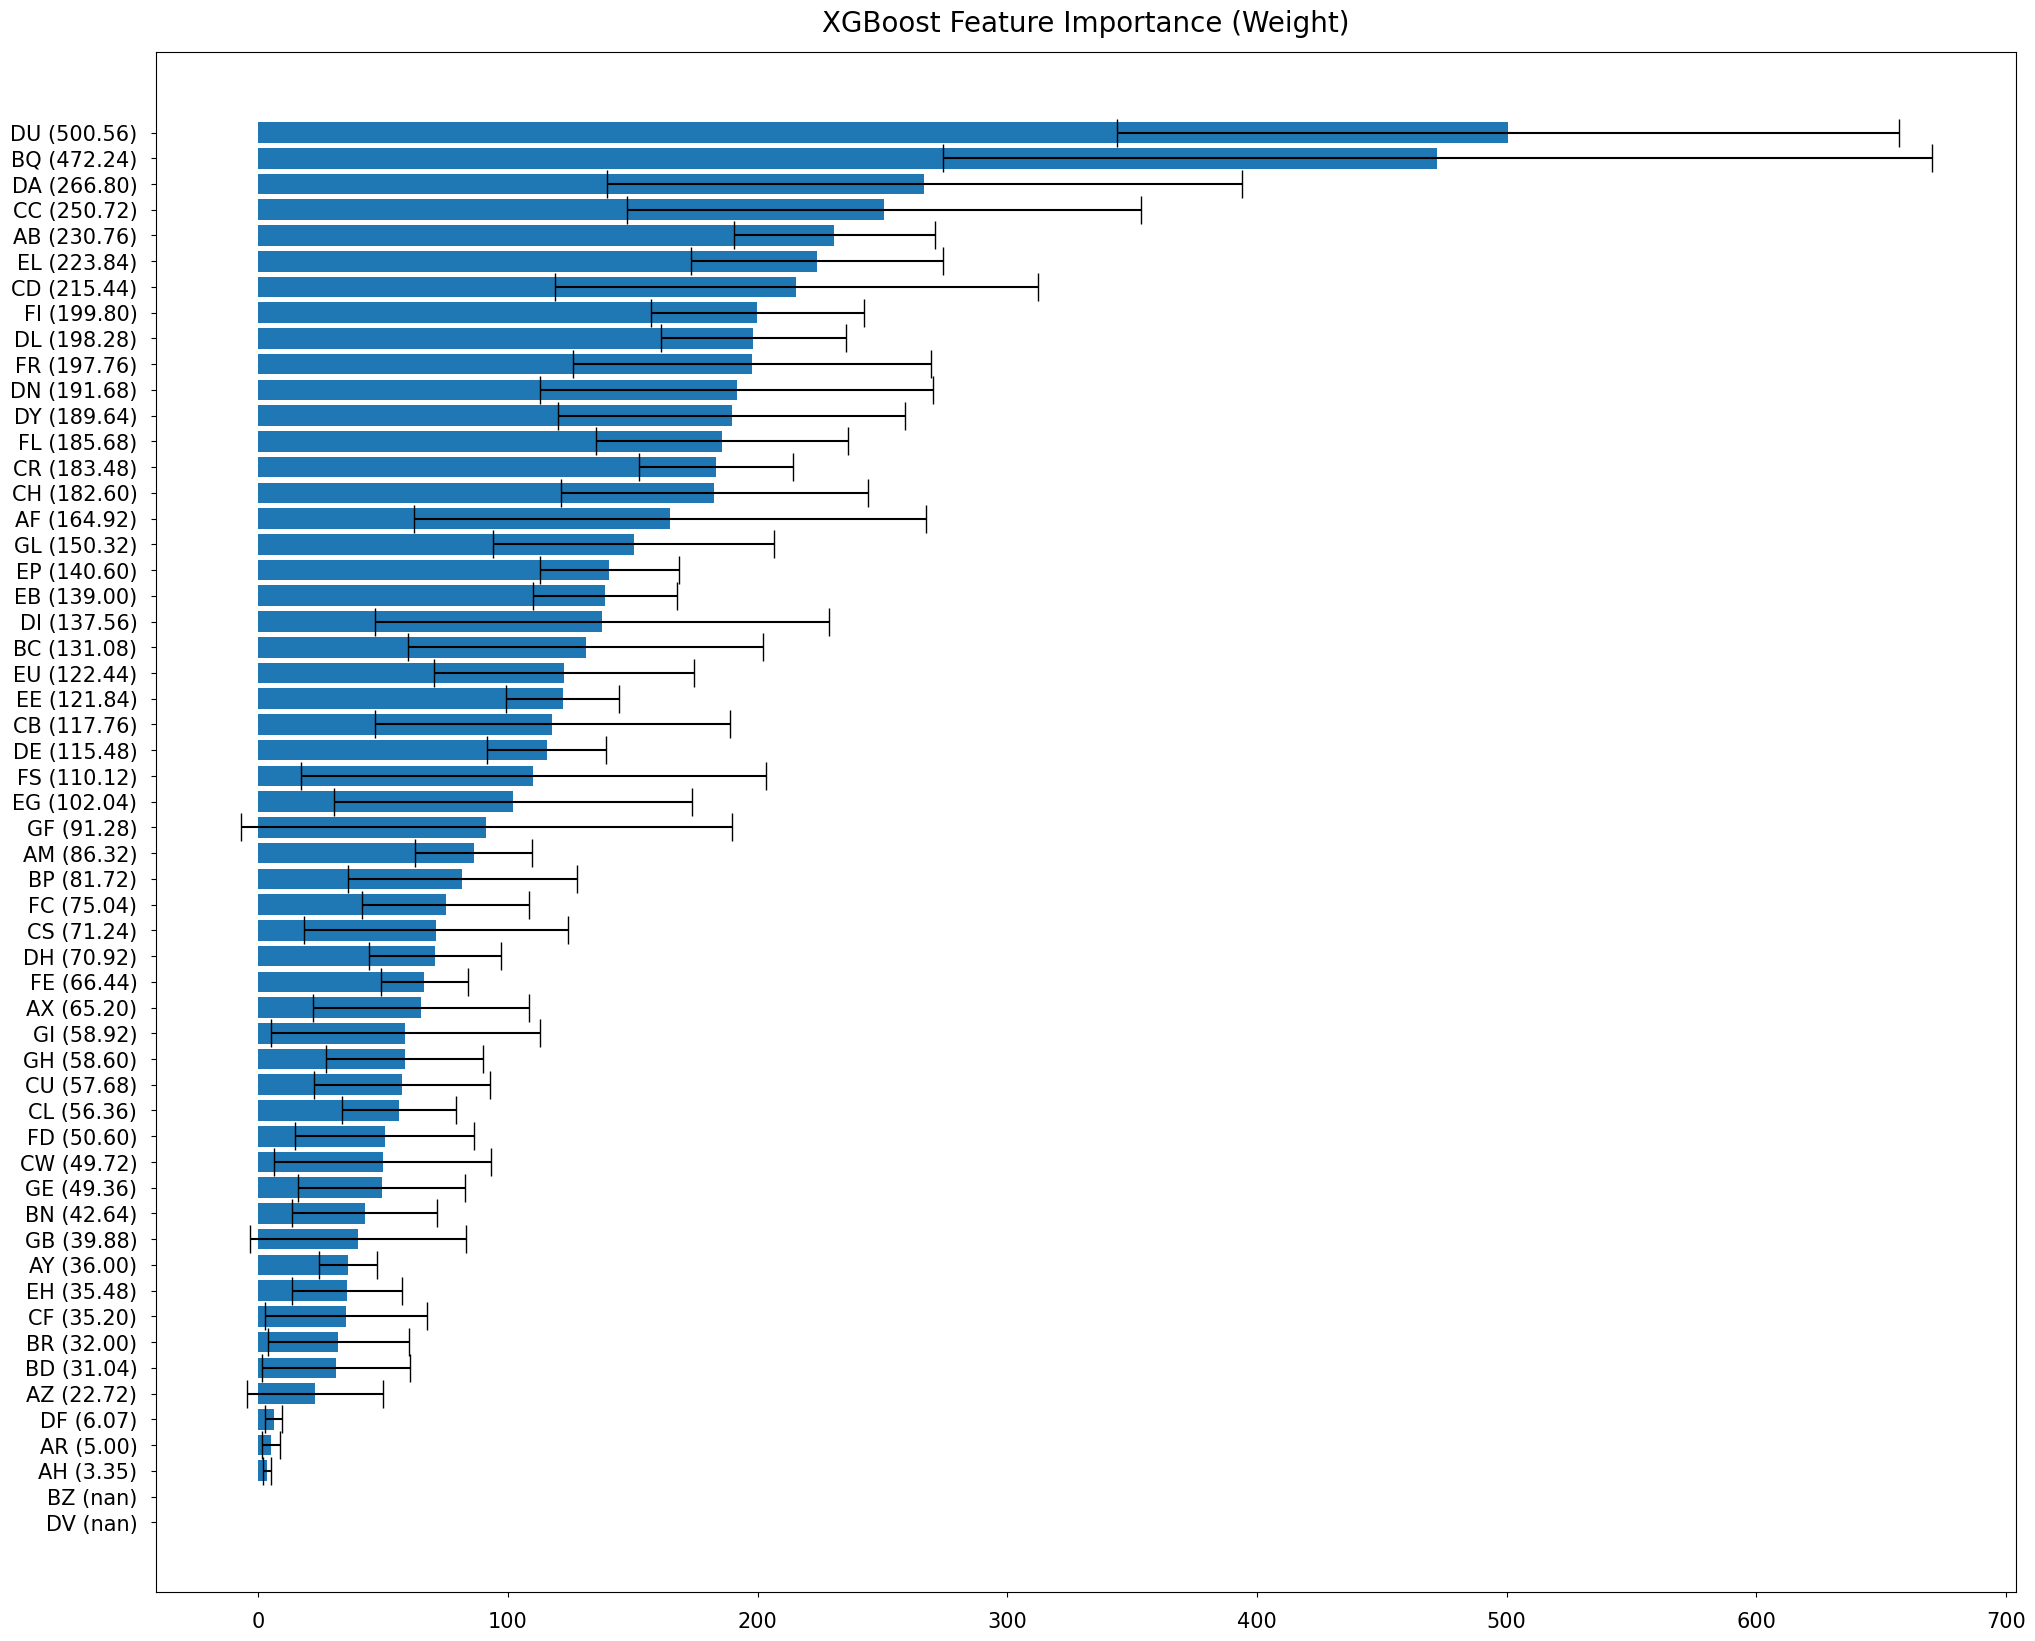

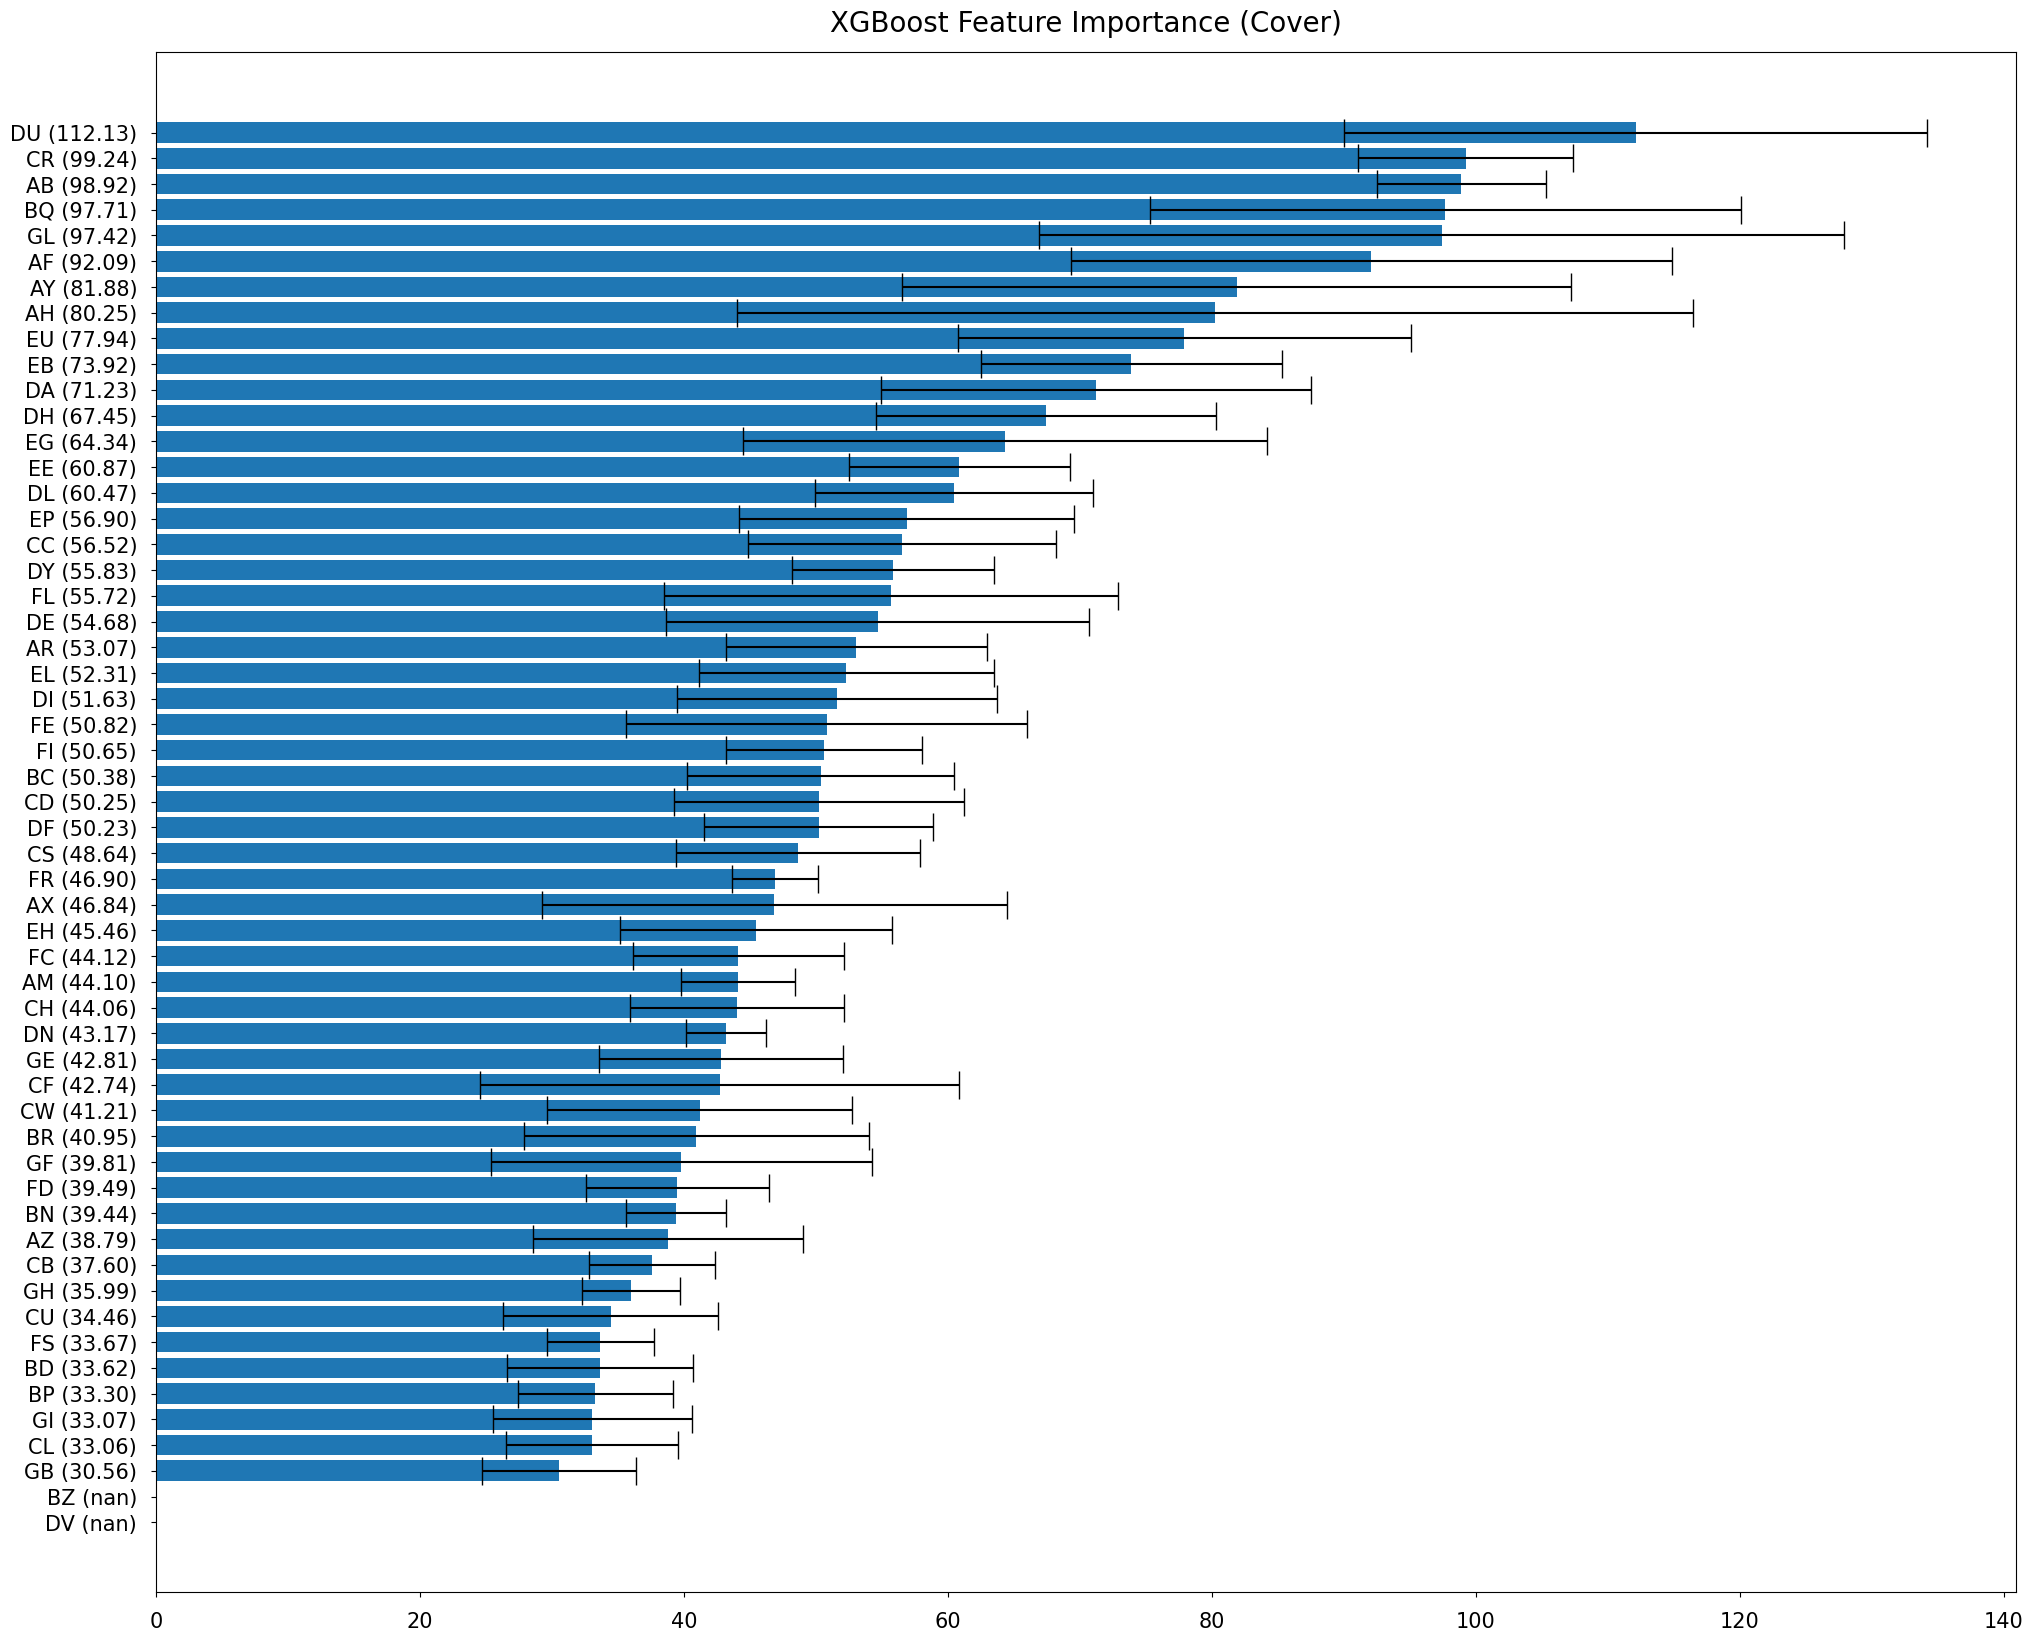

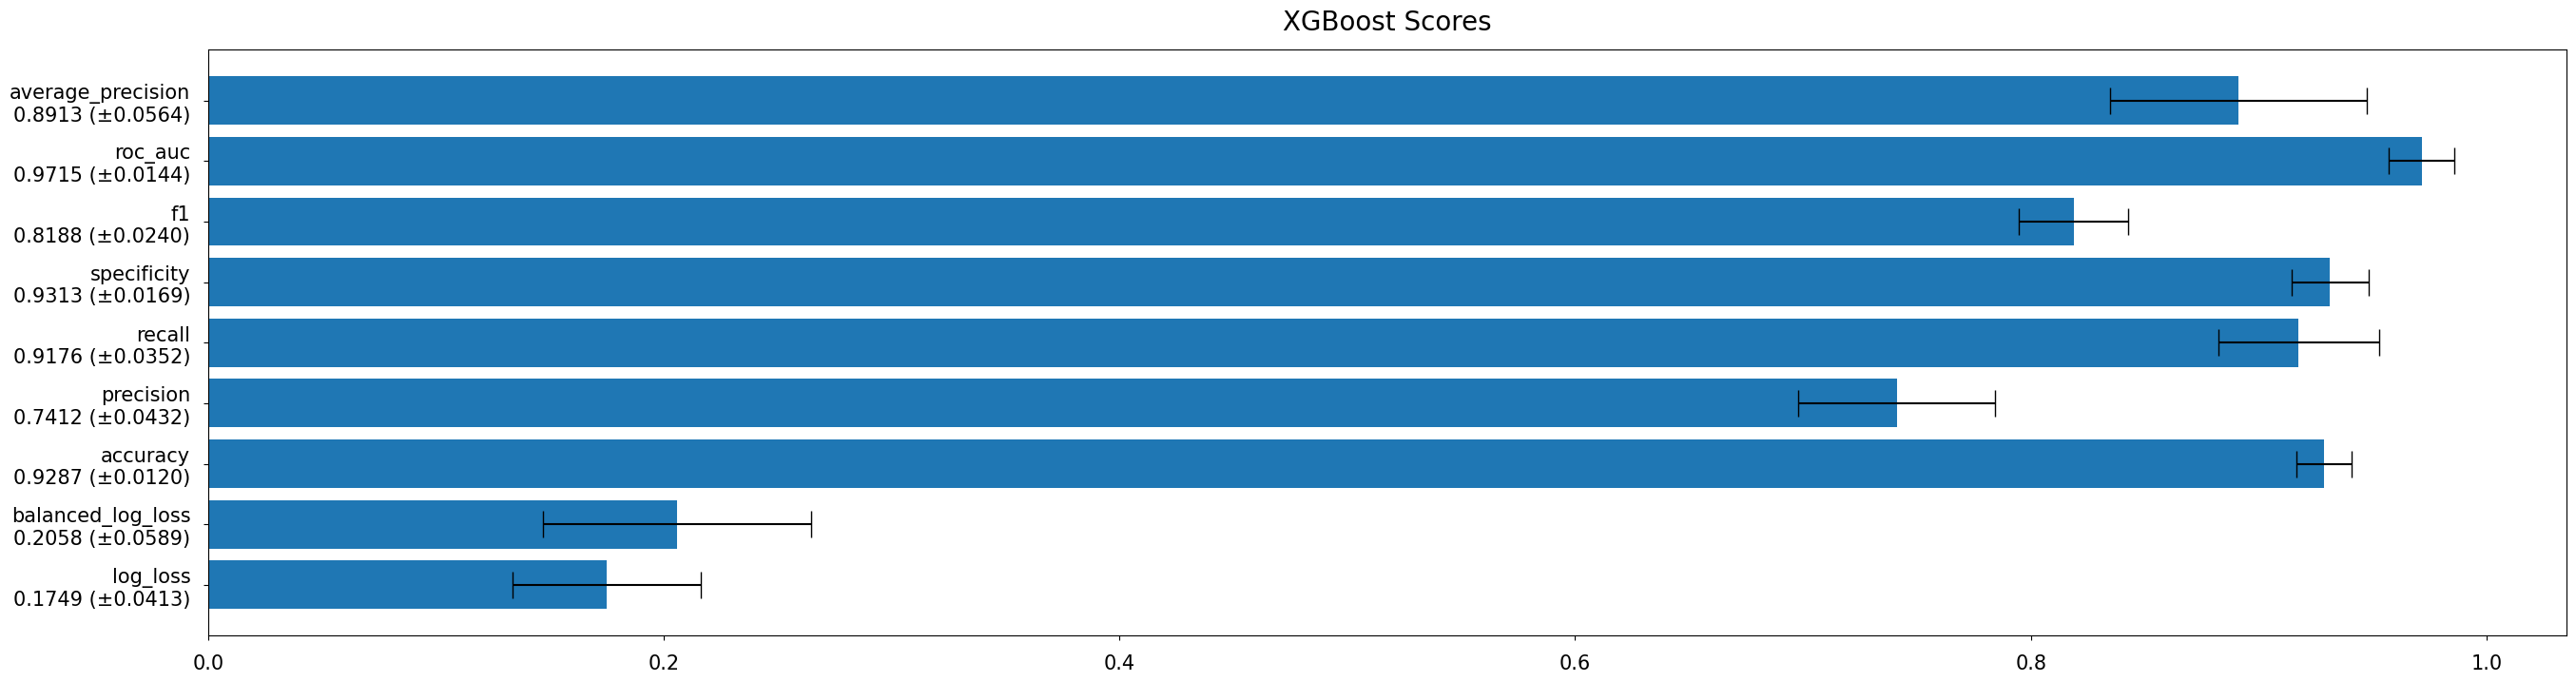

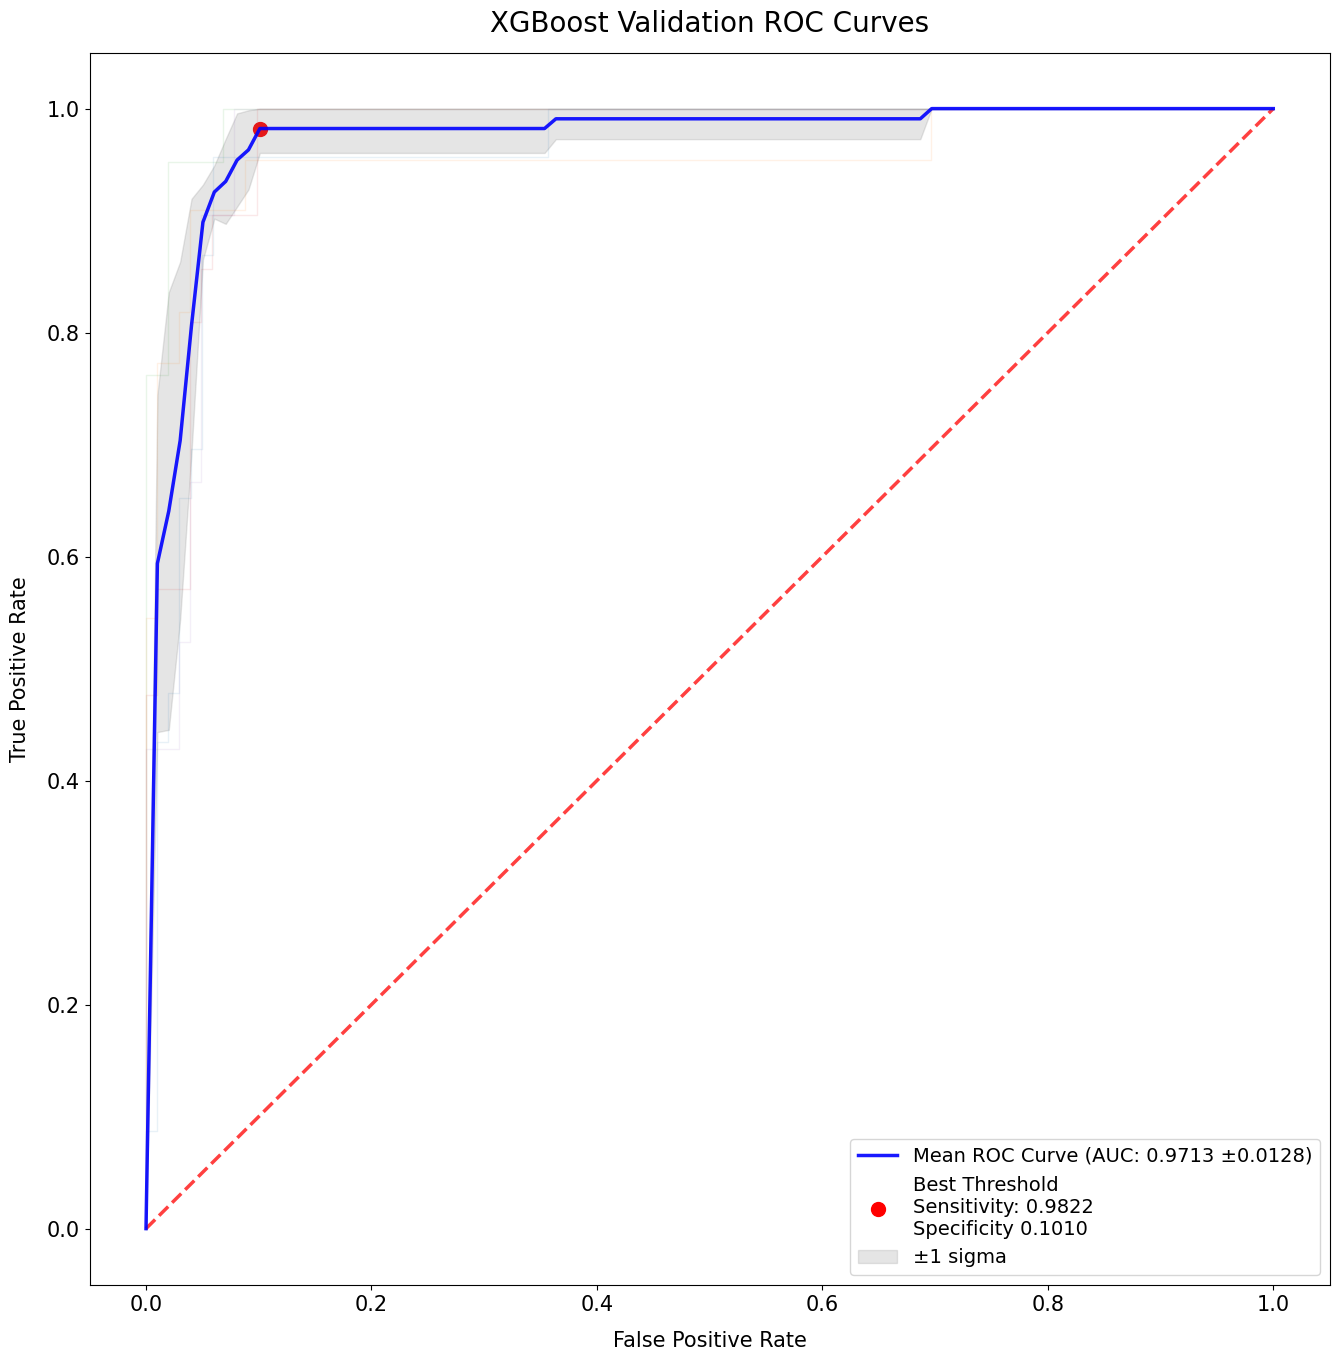

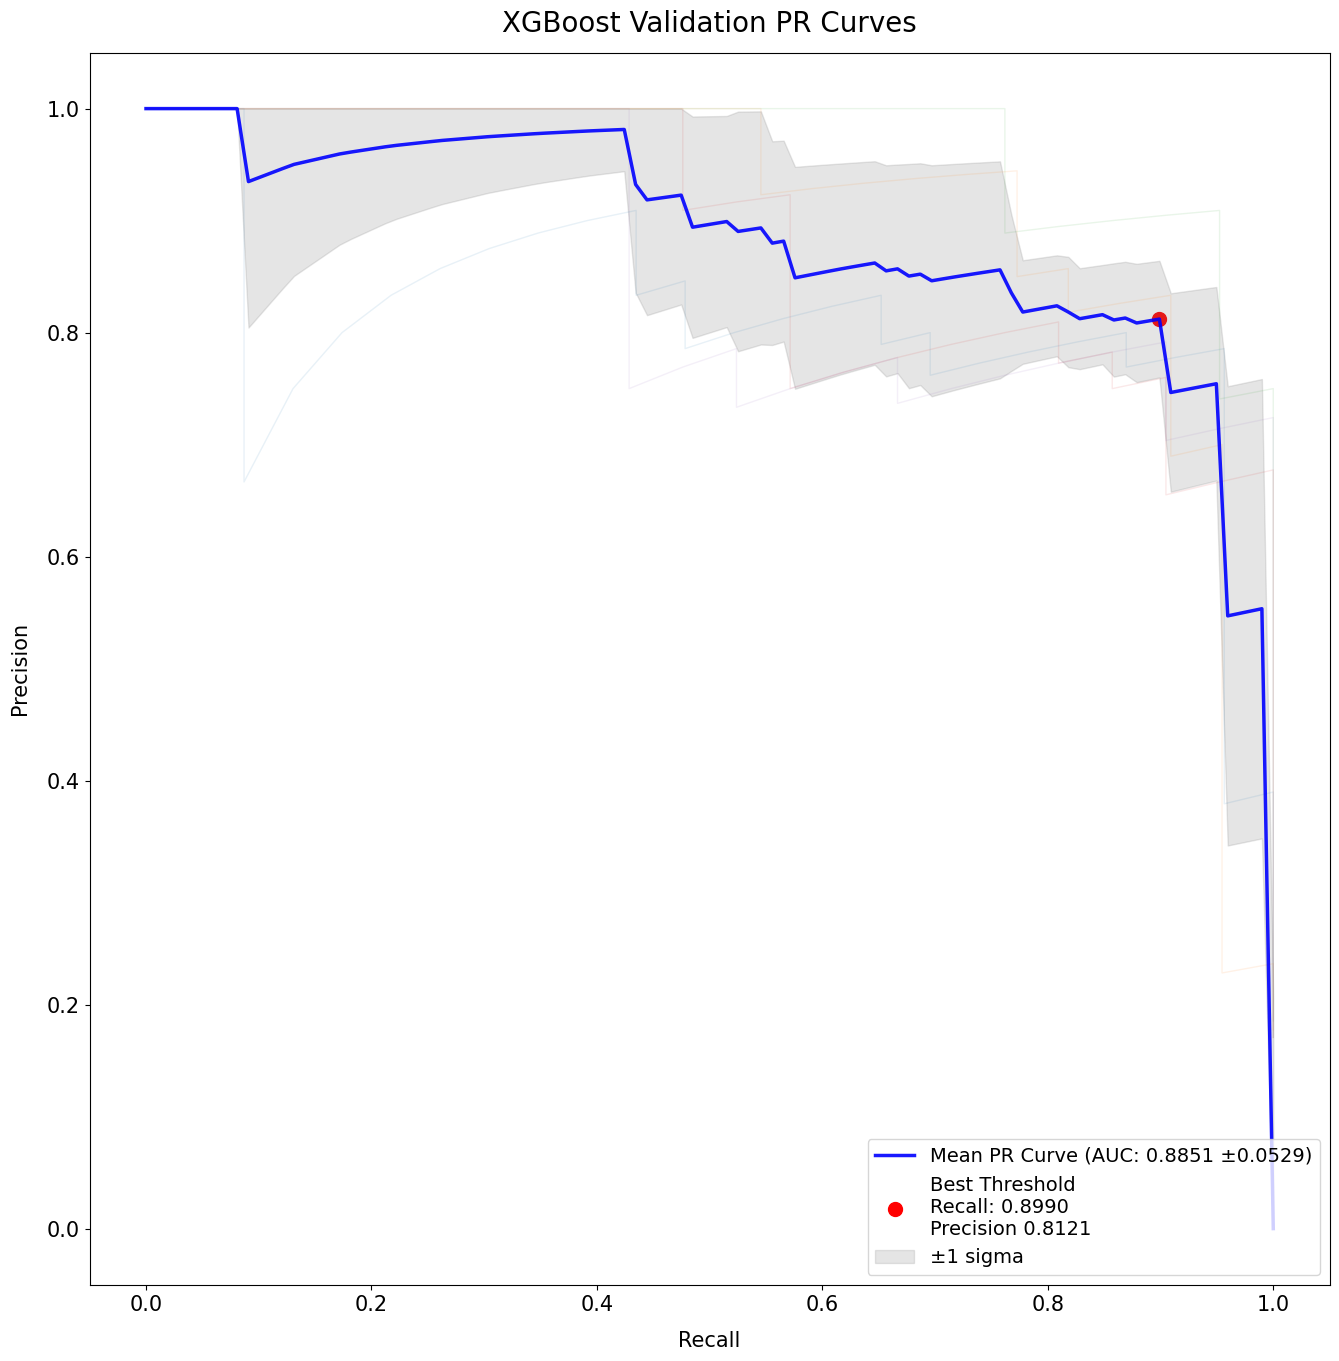

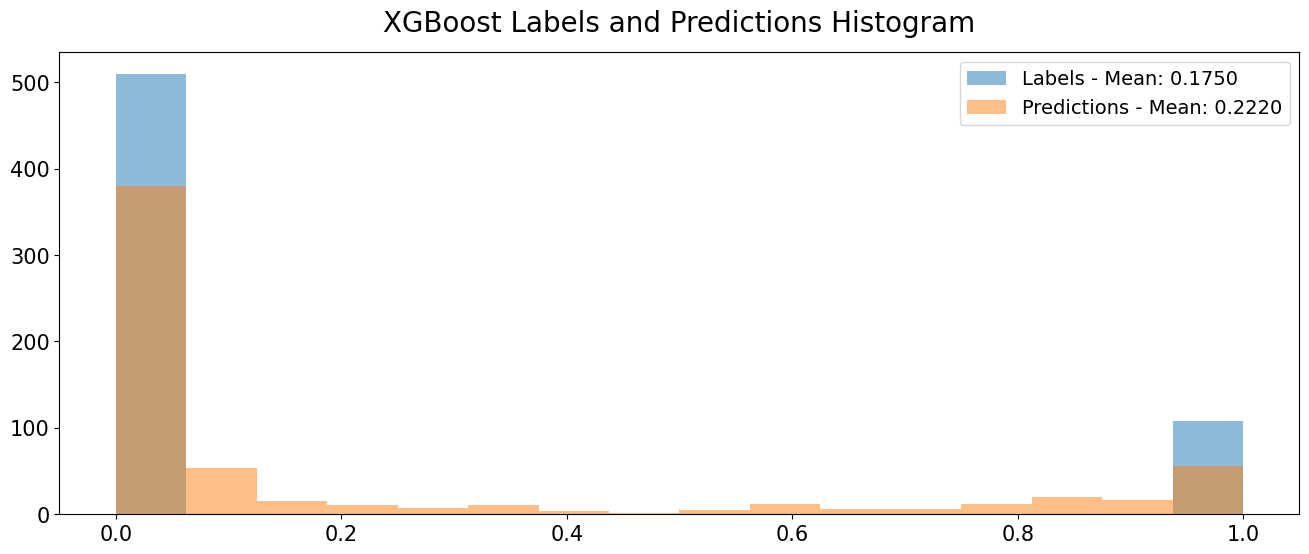

In [15]:
def xgboost_balanced_log_loss(y_pred, training_dataset):
    
    """
    Calculate balanced log loss metric for XGBoost model

    Parameters
    ----------
    y_pred: numpy.ndarray of shape (n_samples)
        Predicted probabilities
        
    training_dataset: xgboost.DMatrix
        Training dataset

    Returns
    -------
    metric_name: str
        Name of the metric
        
    score: float
        Balanced log loss
    """

    metric_name = 'balanced_log_loss'
    score = balanced_log_loss(y_true=training_dataset.get_label(), y_pred=y_pred)
    
    return metric_name, score


xgboost_features = [
    'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ',
    'BC', 'BD', 'BN', 'BP', 'BQ', 'BR', 'BZ',
    'CB', 'CC', 'CD', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU', 'CW',
    'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
    'EB', 'EE', 'EG', 'EH', 'EL', 'EP', 'EU',
    'FC', 'FD', 'FE', 'FI', 'FL', 'FR', 'FS',
    'GB', 'GE', 'GF', 'GH', 'GI', 'GL',
    #'Epsilon_timestamp'
]
xgboost_target = 'Class'
xgboost_folds = ['fold1', 'fold2', 'fold3', 'fold4', 'fold5']
xgboost_seeds = [42, 0, 1337, 1962022, 721991]

xgboost_model_parameters = {
    'learning_rate': 0.01,
    'colsample_bytree': 0.9, 
    'colsample_bylevel': 0.9,
    'colsample_bynode': 0.9,
    'subsample': 0.9,
    'max_depth': 3,
    'gamma': 0.1,
    'min_child_weight': 10,
    'lambda': 0.01,
    'alpha': 0.01,
    'objective': 'binary:logistic',
    'disable_default_eval_metric': True,
    'scale_pos_weight': 15,
    'seed': None,
    'tree_method': 'auto',
    'n_jobs': -1,
}

xgboost_fit_parameters = {
    'boosting_rounds': 10000,
    'verbose_eval': 250,
    'early_stopping_rounds': 500,
}

df_xgboost_feature_importance_gain = pd.DataFrame(
    data=np.zeros((len(xgboost_features), len(xgboost_folds))),
    index=xgboost_features,
    columns=xgboost_folds
)
df_xgboost_feature_importance_weight = pd.DataFrame(
    data=np.zeros((len(xgboost_features), len(xgboost_folds))),
    index=xgboost_features,
    columns=xgboost_folds
)
df_xgboost_feature_importance_cover = pd.DataFrame(
    data=np.zeros((len(xgboost_features), len(xgboost_folds))),
    index=xgboost_features,
    columns=xgboost_folds
)
xgboost_scores = []
xgboost_curves = []
xgboost_best_iterations = []
xgboost_positive_min_predictions = []
xgboost_negative_max_predictions = []

for fold in xgboost_folds:

    training_idx = df_train[fold] == 0
    validation_idx = df_train[fold] == 1

    print(
        f'''
        Fold: {fold}
        Training Shape: ({np.sum(training_idx)}, {len(xgboost_features)}) - Target Mean: {df_train.loc[training_idx, xgboost_target].mean():.4f}
        Validation: ({np.sum(validation_idx)}, {len(xgboost_features)}) - Target Mean: {df_train.loc[validation_idx, xgboost_target].mean():.4f}
        '''
    )
    
    val_predictions = np.zeros(np.sum(validation_idx))
    
    for seed in xgboost_seeds:
                
        xgboost_model_parameters.update({
            'seed': seed
        })
        
        training_dataset = xgb.DMatrix(
            df_train.loc[training_idx, xgboost_features],
            label=df_train.loc[training_idx, xgboost_target]
        )
        validation_dataset = xgb.DMatrix(
            df_train.loc[validation_idx, xgboost_features],
            label=df_train.loc[validation_idx, xgboost_target]
        )

        model = xgb.train(
            params=xgboost_model_parameters,
            dtrain=training_dataset,
            evals=[(training_dataset, 'train'), (validation_dataset, 'val')],
            num_boost_round=xgboost_fit_parameters['boosting_rounds'],
            early_stopping_rounds=xgboost_fit_parameters['early_stopping_rounds'],
            verbose_eval=xgboost_fit_parameters['verbose_eval'],
            custom_metric=xgboost_balanced_log_loss,
            maximize=False 
        )
        xgboost_best_iterations.append(model.best_iteration)

        df_xgboost_feature_importance_gain[fold] += (pd.Series(model.get_score(importance_type='gain')).fillna(0) / len(xgboost_seeds))
        df_xgboost_feature_importance_weight[fold] += (pd.Series(model.get_score(importance_type='weight')).fillna(0) / len(xgboost_seeds))
        df_xgboost_feature_importance_cover[fold] += (pd.Series(model.get_score(importance_type='cover')).fillna(0) / len(xgboost_seeds))

        val_predictions += (model.predict(xgb.DMatrix(df_train.loc[validation_idx, xgboost_features])) / len(xgboost_seeds))

    df_train.loc[validation_idx, 'xgboost_prediction'] = val_predictions
    val_scores = classification_scores(
        y_true=df_train.loc[validation_idx, xgboost_target],
        y_pred=df_train.loc[validation_idx, 'xgboost_prediction'],
    )
    xgboost_scores.append(val_scores)
    print(f'Fold {fold} - Validation Scores: {json.dumps(val_scores, indent=2)}')
    val_curves = classification_curves(
        y_true=df_train.loc[validation_idx, xgboost_target],
        y_pred=df_train.loc[validation_idx, 'xgboost_prediction'],
    )
    xgboost_curves.append(val_curves)
    xgboost_positive_min_predictions.append(df_train.loc[validation_idx & df_train[xgboost_target] == 1, 'xgboost_prediction'].min())
    xgboost_negative_max_predictions.append(df_train.loc[validation_idx & df_train[xgboost_target] == 0, 'xgboost_prediction'].max())

df_xgboost_scores = pd.DataFrame(xgboost_scores)
print(
    f'''
    XGBoost Mean Validation Scores
    {json.dumps(df_xgboost_scores.mean(axis=0).to_dict(), indent=2)}
    and Standard Deviations
    ±{json.dumps(df_xgboost_scores.std(axis=0).to_dict(), indent=2)}
    '''
)

oof_scores = classification_scores(
    y_true=df_train.loc[:, xgboost_target],
    y_pred=df_train.loc[:, 'xgboost_prediction'],
)
print(f'OOF Scores: {json.dumps(oof_scores, indent=2)}')
print(f'Best Iterations {xgboost_best_iterations} - Mean: {np.mean(xgboost_best_iterations):.2f} Std: {np.std(xgboost_best_iterations):.2f} Min: {np.min(xgboost_best_iterations)} Max: {np.max(xgboost_best_iterations)}')
print(f'Positive Min Predictions {xgboost_positive_min_predictions} - Mean: {np.mean(xgboost_positive_min_predictions):.2f} Std: {np.std(xgboost_positive_min_predictions):.2f} Min: {np.min(xgboost_positive_min_predictions)} Max: {np.max(xgboost_positive_min_predictions)}')
print(f'Negative Max Predictions {xgboost_negative_max_predictions} - Mean: {np.mean(xgboost_negative_max_predictions):.2f} Std: {np.std(xgboost_negative_max_predictions):.2f} Min: {np.min(xgboost_negative_max_predictions)} Max: {np.max(xgboost_negative_max_predictions)}')

for importance_type, df_feature_importance in zip(['gain', 'weight', 'cover'], [df_xgboost_feature_importance_gain, df_xgboost_feature_importance_weight, df_xgboost_feature_importance_cover]):
    df_feature_importance['mean'] = df_feature_importance[xgboost_folds].mean(axis=1)
    df_feature_importance['std'] = df_feature_importance[xgboost_folds].std(axis=1).fillna(0)
    df_feature_importance.sort_values(by='mean', ascending=False, inplace=True)
    visualize_feature_importance(
        df_feature_importance=df_feature_importance,
        title=f'XGBoost Feature Importance ({importance_type.capitalize()})'
    )
    
visualize_scores(df_scores=df_xgboost_scores, title='XGBoost Scores')
visualize_roc_curves(roc_curves=[curve['roc'] for curve in xgboost_curves], title='XGBoost Validation ROC Curves')
visualize_pr_curves(pr_curves=[curve['pr'] for curve in xgboost_curves], title='XGBoost Validation PR Curves')
visualize_predictions(y_true=df_train['Class'], y_pred=df_train['xgboost_prediction'], title='XGBoost Labels and Predictions Histogram')


        Fold: fold1
        Training Shape: (493, 55) - Target Mean: 0.1724
        Validation: (124, 55) - Target Mean: 0.1855
        
0:	learn: 0.6224078	test: 0.6223773	test1: 0.6109220	best: 0.6109220 (0)	total: 57ms	remaining: 9m 29s


250:	learn: 0.1648529	test: 0.1648431	test1: 0.3274618	best: 0.3273521 (249)	total: 328ms	remaining: 12.7s
500:	learn: 0.0813075	test: 0.0813271	test1: 0.3189543	best: 0.3127447 (445)	total: 598ms	remaining: 11.3s
750:	learn: 0.0417577	test: 0.0417989	test1: 0.3301719	best: 0.3127447 (445)	total: 856ms	remaining: 10.5s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.3127447269
bestIteration = 445

Shrink model to first 446 iterations.


0:	learn: 0.6170184	test: 0.6169814	test1: 0.6058209	best: 0.6058209 (0)	total: 1.44ms	remaining: 14.4s
250:	learn: 0.1644337	test: 0.1644282	test1: 0.3271391	best: 0.3257293 (245)	total: 283ms	remaining: 11s
500:	learn: 0.0822598	test: 0.0823078	test1: 0.3215614	best: 0.3142387 (374)	total: 531ms	remaining: 10.1s
750:	learn: 0.0424865	test: 0.0425375	test1: 0.3245378	best: 0.3142387 (374)	total: 788ms	remaining: 9.7s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.3142386866
bestIteration = 374

Shrink model to first 375 iterations.
0:	learn: 0.6155031	test: 0.6154679	test1: 0.6032390	best: 0.6032390 (0)	total: 1.33ms	remaining: 13.3s


250:	learn: 0.1658455	test: 0.1658737	test1: 0.3135739	best: 0.3134662 (249)	total: 278ms	remaining: 10.8s
500:	learn: 0.0799960	test: 0.0800543	test1: 0.3117434	best: 0.3040024 (392)	total: 546ms	remaining: 10.3s
750:	learn: 0.0426925	test: 0.0427535	test1: 0.3313106	best: 0.3040024 (392)	total: 816ms	remaining: 10s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.3040024355
bestIteration = 392

Shrink model to first 393 iterations.


0:	learn: 0.6209704	test: 0.6209389	test1: 0.6105755	best: 0.6105755 (0)	total: 1.35ms	remaining: 13.5s
250:	learn: 0.1644095	test: 0.1644066	test1: 0.3074636	best: 0.3074636 (250)	total: 272ms	remaining: 10.6s
500:	learn: 0.0786753	test: 0.0787106	test1: 0.2957382	best: 0.2947628 (492)	total: 535ms	remaining: 10.2s
750:	learn: 0.0419132	test: 0.0419632	test1: 0.3067680	best: 0.2934848 (531)	total: 813ms	remaining: 10s
1000:	learn: 0.0264918	test: 0.0265296	test1: 0.3244855	best: 0.2934848 (531)	total: 1.07s	remaining: 9.62s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.2934847527
bestIteration = 531

Shrink model to first 532 iterations.
0:	learn: 0.6223576	test: 0.6223241	test1: 0.6087733	best: 0.6087733 (0)	total: 1.63ms	remaining: 16.3s


250:	learn: 0.1636671	test: 0.1637054	test1: 0.3270561	best: 0.3270561 (250)	total: 277ms	remaining: 10.8s
500:	learn: 0.0787170	test: 0.0787889	test1: 0.3200474	best: 0.3162965 (366)	total: 546ms	remaining: 10.3s
750:	learn: 0.0416744	test: 0.0417435	test1: 0.3295321	best: 0.3162965 (366)	total: 814ms	remaining: 10s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.3162965258
bestIteration = 366

Shrink model to first 367 iterations.
Fold fold1 - Validation Scores: {
  "log_loss": 0.25109205540154167,
  "balanced_log_loss": 0.28563589040864507,
  "accuracy": 0.9274193548387096,
  "precision": 0.7692307692307693,
  "recall": 0.8695652173913043,
  "specificity": 0.9405940594059405,
  "f1": 0.8163265306122449,
  "roc_auc": 0.9547998278088679,
  "average_precision": 0.7849928049282665
}

        Fold: fold2
        Training Shape: (493, 55) - Target Mean: 0.1744
        Validation: (124, 55) - Target Mean: 0.1774
        


0:	learn: 0.6205285	test: 0.6204953	test1: 0.6173748	best: 0.6173748 (0)	total: 1.87ms	remaining: 18.7s
250:	learn: 0.1640820	test: 0.1641319	test1: 0.2774575	best: 0.2768353 (248)	total: 280ms	remaining: 10.9s
500:	learn: 0.0846313	test: 0.0846927	test1: 0.2568401	best: 0.2568401 (500)	total: 552ms	remaining: 10.5s
750:	learn: 0.0509941	test: 0.0510816	test1: 0.2414059	best: 0.2410538 (744)	total: 825ms	remaining: 10.2s
1000:	learn: 0.0299749	test: 0.0300416	test1: 0.2427832	best: 0.2402680 (765)	total: 1.1s	remaining: 9.91s
1250:	learn: 0.0196274	test: 0.0196961	test1: 0.2483072	best: 0.2402680 (765)	total: 1.37s	remaining: 9.61s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.2402680026
bestIteration = 765

Shrink model to first 766 iterations.
0:	learn: 0.6139197	test: 0.6138833	test1: 0.6099533	best: 0.6099533 (0)	total: 1.32ms	remaining: 13.2s


250:	learn: 0.1686621	test: 0.1687115	test1: 0.2842487	best: 0.2842487 (250)	total: 276ms	remaining: 10.7s
500:	learn: 0.0902685	test: 0.0903302	test1: 0.2586462	best: 0.2586462 (500)	total: 533ms	remaining: 10.1s
750:	learn: 0.0462650	test: 0.0463229	test1: 0.2426460	best: 0.2421443 (746)	total: 804ms	remaining: 9.91s
1000:	learn: 0.0326793	test: 0.0327325	test1: 0.2426113	best: 0.2395619 (926)	total: 1.07s	remaining: 9.64s
1250:	learn: 0.0207653	test: 0.0208346	test1: 0.2480180	best: 0.2395619 (926)	total: 1.39s	remaining: 9.7s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.2395618946
bestIteration = 926

Shrink model to first 927 iterations.


0:	learn: 0.6122354	test: 0.6121995	test1: 0.6092457	best: 0.6092457 (0)	total: 1.31ms	remaining: 13.1s
250:	learn: 0.1632998	test: 0.1633864	test1: 0.2996993	best: 0.2996993 (250)	total: 274ms	remaining: 10.6s
500:	learn: 0.0906442	test: 0.0906960	test1: 0.2781427	best: 0.2781427 (500)	total: 535ms	remaining: 10.2s
750:	learn: 0.0497429	test: 0.0497985	test1: 0.2595538	best: 0.2589752 (742)	total: 813ms	remaining: 10s
1000:	learn: 0.0296145	test: 0.0296586	test1: 0.2600122	best: 0.2548743 (905)	total: 1.08s	remaining: 9.73s
1250:	learn: 0.0196639	test: 0.0197195	test1: 0.2664686	best: 0.2548743 (905)	total: 1.35s	remaining: 9.47s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.2548742543
bestIteration = 905

Shrink model to first 906 iterations.


0:	learn: 0.6203543	test: 0.6203252	test1: 0.6171267	best: 0.6171267 (0)	total: 1.37ms	remaining: 13.7s
250:	learn: 0.1633587	test: 0.1634473	test1: 0.2906507	best: 0.2906507 (250)	total: 280ms	remaining: 10.9s
500:	learn: 0.0892389	test: 0.0893217	test1: 0.2729838	best: 0.2723825 (497)	total: 538ms	remaining: 10.2s
750:	learn: 0.0496686	test: 0.0497261	test1: 0.2559554	best: 0.2544480 (690)	total: 804ms	remaining: 9.9s
1000:	learn: 0.0316882	test: 0.0317517	test1: 0.2521012	best: 0.2518405 (995)	total: 1.07s	remaining: 9.61s
1250:	learn: 0.0194925	test: 0.0195557	test1: 0.2588214	best: 0.2518055 (1032)	total: 1.34s	remaining: 9.39s
1500:	learn: 0.0143280	test: 0.0143811	test1: 0.2619721	best: 0.2518055 (1032)	total: 1.61s	remaining: 9.11s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.2518055038
bestIteration = 1032

Shrink model to first 1033 iterations.
0:	learn: 0.6191234	test: 0.6190879	test1: 0.6156502	best: 0.6156502 (0)	total: 1.34ms	remaining: 13.4s


250:	learn: 0.1617627	test: 0.1618274	test1: 0.2982977	best: 0.2955296 (232)	total: 279ms	remaining: 10.8s
500:	learn: 0.0888153	test: 0.0888979	test1: 0.2753723	best: 0.2752735 (498)	total: 554ms	remaining: 10.5s
750:	learn: 0.0499279	test: 0.0499906	test1: 0.2587684	best: 0.2581640 (734)	total: 824ms	remaining: 10.1s
1000:	learn: 0.0320719	test: 0.0321247	test1: 0.2577434	best: 0.2557760 (916)	total: 1.09s	remaining: 9.82s
1250:	learn: 0.0215356	test: 0.0215956	test1: 0.2625040	best: 0.2557760 (916)	total: 1.36s	remaining: 9.55s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.255776004
bestIteration = 916

Shrink model to first 917 iterations.
Fold fold2 - Validation Scores: {
  "log_loss": 0.1940062520921686,
  "balanced_log_loss": 0.22806818982417343,
  "accuracy": 0.9354838709677419,
  "precision": 0.75,
  "recall": 0.9545454545454546,
  "specificity": 0.9313725490196079,
  "f1": 0.84,
  "roc_auc": 0.9598930481283423,
  "average_precision": 0.9235679195337443


250:	learn: 0.1811290	test: 0.1811586	test1: 0.2367703	best: 0.2367703 (250)	total: 281ms	remaining: 10.9s
500:	learn: 0.0879030	test: 0.0879429	test1: 0.1860201	best: 0.1857656 (498)	total: 544ms	remaining: 10.3s
750:	learn: 0.0485934	test: 0.0486277	test1: 0.1680839	best: 0.1679882 (743)	total: 802ms	remaining: 9.88s
1000:	learn: 0.0275255	test: 0.0275700	test1: 0.1546212	best: 0.1545496 (995)	total: 1.08s	remaining: 9.71s
1250:	learn: 0.0180557	test: 0.0180967	test1: 0.1492965	best: 0.1492934 (1249)	total: 1.35s	remaining: 9.47s
1500:	learn: 0.0132612	test: 0.0133004	test1: 0.1480067	best: 0.1479199 (1327)	total: 1.63s	remaining: 9.2s
1750:	learn: 0.0100612	test: 0.0101085	test1: 0.1490160	best: 0.1479157 (1503)	total: 1.89s	remaining: 8.93s
2000:	learn: 0.0079021	test: 0.0079601	test1: 0.1414436	best: 0.1414436 (2000)	total: 2.16s	remaining: 8.65s
2250:	learn: 0.0065698	test: 0.0066228	test1: 0.1363981	best: 0.1363981 (2250)	total: 2.43s	remaining: 8.38s
2500:	learn: 0.0055641	test

250:	learn: 0.1774542	test: 0.1774650	test1: 0.2380532	best: 0.2380532 (250)	total: 277ms	remaining: 10.8s
500:	learn: 0.0873470	test: 0.0873728	test1: 0.1831151	best: 0.1829127 (497)	total: 546ms	remaining: 10.4s
750:	learn: 0.0475584	test: 0.0475833	test1: 0.1575040	best: 0.1575040 (750)	total: 821ms	remaining: 10.1s
1000:	learn: 0.0300201	test: 0.0300452	test1: 0.1476029	best: 0.1473221 (947)	total: 1.08s	remaining: 9.71s
1250:	learn: 0.0193507	test: 0.0193960	test1: 0.1394320	best: 0.1393783 (1245)	total: 1.35s	remaining: 9.45s
1500:	learn: 0.0138402	test: 0.0138788	test1: 0.1366803	best: 0.1353192 (1428)	total: 1.61s	remaining: 9.14s
1750:	learn: 0.0102220	test: 0.0102698	test1: 0.1351986	best: 0.1351986 (1750)	total: 1.89s	remaining: 8.9s
2000:	learn: 0.0079170	test: 0.0079770	test1: 0.1294889	best: 0.1294889 (2000)	total: 2.16s	remaining: 8.63s
2250:	learn: 0.0063824	test: 0.0064404	test1: 0.1229992	best: 0.1229992 (2250)	total: 2.43s	remaining: 8.36s
2500:	learn: 0.0053909	test

250:	learn: 0.1819509	test: 0.1819998	test1: 0.2327101	best: 0.2327101 (250)	total: 268ms	remaining: 10.4s
500:	learn: 0.0891766	test: 0.0892604	test1: 0.1836240	best: 0.1836240 (500)	total: 525ms	remaining: 9.95s
750:	learn: 0.0467483	test: 0.0467993	test1: 0.1663755	best: 0.1663755 (750)	total: 773ms	remaining: 9.52s
1000:	learn: 0.0295008	test: 0.0295477	test1: 0.1550753	best: 0.1550533 (998)	total: 1.03s	remaining: 9.25s
1250:	learn: 0.0201851	test: 0.0202341	test1: 0.1514937	best: 0.1509451 (1238)	total: 1.3s	remaining: 9.13s
1500:	learn: 0.0141125	test: 0.0141668	test1: 0.1478847	best: 0.1475825 (1497)	total: 1.58s	remaining: 8.93s
1750:	learn: 0.0106393	test: 0.0106959	test1: 0.1477492	best: 0.1451110 (1637)	total: 1.84s	remaining: 8.68s
2000:	learn: 0.0082065	test: 0.0082617	test1: 0.1451523	best: 0.1447516 (1990)	total: 2.12s	remaining: 8.47s
2250:	learn: 0.0066696	test: 0.0067231	test1: 0.1443553	best: 0.1440827 (2246)	total: 2.4s	remaining: 8.25s
2500:	learn: 0.0056716	test:

0:	learn: 0.6177979	test: 0.6177655	test1: 0.6229265	best: 0.6229265 (0)	total: 1.44ms	remaining: 14.4s
250:	learn: 0.1808283	test: 0.1808892	test1: 0.2389061	best: 0.2389061 (250)	total: 275ms	remaining: 10.7s
500:	learn: 0.0847025	test: 0.0847757	test1: 0.1800453	best: 0.1796934 (498)	total: 545ms	remaining: 10.3s
750:	learn: 0.0419903	test: 0.0420465	test1: 0.1597163	best: 0.1591361 (740)	total: 819ms	remaining: 10.1s
1000:	learn: 0.0266814	test: 0.0267253	test1: 0.1514081	best: 0.1514081 (1000)	total: 1.09s	remaining: 9.79s
1250:	learn: 0.0181478	test: 0.0181976	test1: 0.1424464	best: 0.1422837 (1245)	total: 1.33s	remaining: 9.33s
1500:	learn: 0.0128553	test: 0.0129107	test1: 0.1351740	best: 0.1346981 (1478)	total: 1.61s	remaining: 9.12s
1750:	learn: 0.0097390	test: 0.0097947	test1: 0.1333738	best: 0.1325884 (1598)	total: 1.88s	remaining: 8.87s
2000:	learn: 0.0078214	test: 0.0078771	test1: 0.1264500	best: 0.1264500 (2000)	total: 2.15s	remaining: 8.62s
2250:	learn: 0.0065172	test: 0

250:	learn: 0.1758052	test: 0.1758475	test1: 0.2406934	best: 0.2406934 (250)	total: 277ms	remaining: 10.8s
500:	learn: 0.0882887	test: 0.0883597	test1: 0.1895589	best: 0.1893183 (498)	total: 546ms	remaining: 10.4s
750:	learn: 0.0441003	test: 0.0441533	test1: 0.1684123	best: 0.1680444 (730)	total: 818ms	remaining: 10.1s
1000:	learn: 0.0263344	test: 0.0263860	test1: 0.1606251	best: 0.1596435 (992)	total: 1.09s	remaining: 9.82s
1250:	learn: 0.0185650	test: 0.0186214	test1: 0.1525875	best: 0.1521496 (1245)	total: 1.37s	remaining: 9.57s
1500:	learn: 0.0131667	test: 0.0132170	test1: 0.1447490	best: 0.1441422 (1472)	total: 1.64s	remaining: 9.29s
1750:	learn: 0.0100084	test: 0.0100666	test1: 0.1405552	best: 0.1405033 (1747)	total: 1.9s	remaining: 8.97s
2000:	learn: 0.0080339	test: 0.0080891	test1: 0.1371603	best: 0.1368557 (1968)	total: 2.18s	remaining: 8.71s
2250:	learn: 0.0071137	test: 0.0071633	test1: 0.1366036	best: 0.1357202 (2033)	total: 2.45s	remaining: 8.44s
2500:	learn: 0.0061347	test

250:	learn: 0.1718282	test: 0.1718019	test1: 0.2767696	best: 0.2756828 (249)	total: 315ms	remaining: 12.2s
500:	learn: 0.0792907	test: 0.0793111	test1: 0.2348980	best: 0.2348980 (500)	total: 589ms	remaining: 11.2s
750:	learn: 0.0399296	test: 0.0399789	test1: 0.2267380	best: 0.2222963 (696)	total: 863ms	remaining: 10.6s
1000:	learn: 0.0239293	test: 0.0239792	test1: 0.2338934	best: 0.2222963 (696)	total: 1.14s	remaining: 10.2s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.222296267
bestIteration = 696

Shrink model to first 697 iterations.
0:	learn: 0.6173185	test: 0.6172886	test1: 0.6235882	best: 0.6235882 (0)	total: 1.33ms	remaining: 13.3s


250:	learn: 0.1750362	test: 0.1750166	test1: 0.2491353	best: 0.2491353 (250)	total: 278ms	remaining: 10.8s
500:	learn: 0.0794518	test: 0.0794786	test1: 0.2172241	best: 0.2172241 (500)	total: 548ms	remaining: 10.4s
750:	learn: 0.0386486	test: 0.0386864	test1: 0.2005932	best: 0.2000542 (748)	total: 814ms	remaining: 10s
1000:	learn: 0.0246031	test: 0.0246529	test1: 0.2078830	best: 0.2000542 (748)	total: 1.09s	remaining: 9.79s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.2000542281
bestIteration = 748

Shrink model to first 749 iterations.
0:	learn: 0.6137776	test: 0.6137450	test1: 0.6194739	best: 0.6194739 (0)	total: 1.18ms	remaining: 11.8s


250:	learn: 0.1733824	test: 0.1733904	test1: 0.2717807	best: 0.2717807 (250)	total: 277ms	remaining: 10.8s
500:	learn: 0.0816451	test: 0.0816783	test1: 0.2331716	best: 0.2331716 (500)	total: 547ms	remaining: 10.4s
750:	learn: 0.0382061	test: 0.0382468	test1: 0.2162592	best: 0.2137769 (734)	total: 818ms	remaining: 10.1s
1000:	learn: 0.0227108	test: 0.0227517	test1: 0.2219464	best: 0.2107139 (829)	total: 1.09s	remaining: 9.8s
1250:	learn: 0.0148731	test: 0.0149110	test1: 0.2268536	best: 0.2107139 (829)	total: 1.36s	remaining: 9.52s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.2107138685
bestIteration = 829

Shrink model to first 830 iterations.
0:	learn: 0.6180544	test: 0.6180208	test1: 0.6229793	best: 0.6229793 (0)	total: 1.44ms	remaining: 14.4s


250:	learn: 0.1711654	test: 0.1712006	test1: 0.2630757	best: 0.2625918 (249)	total: 275ms	remaining: 10.7s
500:	learn: 0.0815697	test: 0.0816301	test1: 0.2199065	best: 0.2184719 (496)	total: 543ms	remaining: 10.3s
750:	learn: 0.0382858	test: 0.0383377	test1: 0.2049239	best: 0.2040140 (629)	total: 818ms	remaining: 10.1s
1000:	learn: 0.0234804	test: 0.0235365	test1: 0.2077082	best: 0.2040140 (629)	total: 1.09s	remaining: 9.81s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.204013979
bestIteration = 629

Shrink model to first 630 iterations.


0:	learn: 0.6183500	test: 0.6183150	test1: 0.6247086	best: 0.6247086 (0)	total: 1.39ms	remaining: 13.9s
250:	learn: 0.1729659	test: 0.1730961	test1: 0.2610583	best: 0.2610583 (250)	total: 273ms	remaining: 10.6s
500:	learn: 0.0793492	test: 0.0794498	test1: 0.2156863	best: 0.2156863 (500)	total: 522ms	remaining: 9.9s
750:	learn: 0.0385759	test: 0.0386547	test1: 0.2141439	best: 0.2110651 (644)	total: 798ms	remaining: 9.83s
1000:	learn: 0.0239187	test: 0.0239875	test1: 0.2092485	best: 0.2082614 (986)	total: 1.07s	remaining: 9.59s
1250:	learn: 0.0171240	test: 0.0171771	test1: 0.2067190	best: 0.2047516 (1062)	total: 1.33s	remaining: 9.32s
1500:	learn: 0.0130598	test: 0.0131189	test1: 0.2114217	best: 0.2047516 (1062)	total: 1.6s	remaining: 9.09s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.2047515857
bestIteration = 1062

Shrink model to first 1063 iterations.
Fold fold4 - Validation Scores: {
  "log_loss": 0.19672058023848432,
  "balanced_log_loss": 0.2035455211332710

250:	learn: 0.1633910	test: 0.1634195	test1: 0.2865335	best: 0.2861713 (248)	total: 279ms	remaining: 10.8s
500:	learn: 0.0819791	test: 0.0820145	test1: 0.2666466	best: 0.2627325 (419)	total: 548ms	remaining: 10.4s
750:	learn: 0.0473319	test: 0.0473781	test1: 0.2789238	best: 0.2627325 (419)	total: 939ms	remaining: 11.6s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.2627324592
bestIteration = 419

Shrink model to first 420 iterations.
0:	learn: 0.6180471	test: 0.6180175	test1: 0.6251105	best: 0.6251105 (0)	total: 1.7ms	remaining: 17s


250:	learn: 0.1662469	test: 0.1662667	test1: 0.3013432	best: 0.3013432 (250)	total: 328ms	remaining: 12.7s
500:	learn: 0.0808959	test: 0.0809353	test1: 0.2790952	best: 0.2776972 (489)	total: 600ms	remaining: 11.4s
750:	learn: 0.0425736	test: 0.0426435	test1: 0.2816474	best: 0.2740432 (681)	total: 872ms	remaining: 10.7s
1000:	learn: 0.0270827	test: 0.0271413	test1: 0.2883270	best: 0.2740432 (681)	total: 1.16s	remaining: 10.4s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.2740432084
bestIteration = 681

Shrink model to first 682 iterations.
0:	learn: 0.6116344	test: 0.6116030	test1: 0.6208662	best: 0.6208662 (0)	total: 1.17ms	remaining: 11.7s


250:	learn: 0.1682940	test: 0.1683128	test1: 0.2870027	best: 0.2869616 (247)	total: 279ms	remaining: 10.8s
500:	learn: 0.0841986	test: 0.0842395	test1: 0.2544402	best: 0.2539144 (495)	total: 549ms	remaining: 10.4s
750:	learn: 0.0455319	test: 0.0455875	test1: 0.2593990	best: 0.2496215 (601)	total: 824ms	remaining: 10.1s
1000:	learn: 0.0292350	test: 0.0292855	test1: 0.2683343	best: 0.2496215 (601)	total: 1.1s	remaining: 9.87s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.2496215167
bestIteration = 601

Shrink model to first 602 iterations.
0:	learn: 0.6180294	test: 0.6179980	test1: 0.6268512	best: 0.6268512 (0)	total: 1.29ms	remaining: 12.9s


250:	learn: 0.1705461	test: 0.1705864	test1: 0.2752972	best: 0.2752972 (250)	total: 279ms	remaining: 10.8s
500:	learn: 0.0802555	test: 0.0803054	test1: 0.2437938	best: 0.2421436 (487)	total: 548ms	remaining: 10.4s
750:	learn: 0.0426515	test: 0.0427135	test1: 0.2476465	best: 0.2412857 (649)	total: 833ms	remaining: 10.3s
1000:	learn: 0.0271699	test: 0.0272274	test1: 0.2629869	best: 0.2412857 (649)	total: 1.11s	remaining: 10s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.2412857279
bestIteration = 649

Shrink model to first 650 iterations.


0:	learn: 0.6176115	test: 0.6175771	test1: 0.6262020	best: 0.6262020 (0)	total: 1.38ms	remaining: 13.8s
250:	learn: 0.1682207	test: 0.1682187	test1: 0.2908762	best: 0.2904090 (248)	total: 275ms	remaining: 10.7s
500:	learn: 0.0833189	test: 0.0833593	test1: 0.2644670	best: 0.2629235 (479)	total: 541ms	remaining: 10.3s
750:	learn: 0.0412517	test: 0.0413072	test1: 0.2775416	best: 0.2629235 (479)	total: 811ms	remaining: 9.99s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.2629234596
bestIteration = 479

Shrink model to first 480 iterations.
Fold fold5 - Validation Scores: {
  "log_loss": 0.25612204207987466,
  "balanced_log_loss": 0.2562288470127295,
  "accuracy": 0.926829268292683,
  "precision": 0.7307692307692307,
  "recall": 0.9047619047619048,
  "specificity": 0.9313725490196079,
  "f1": 0.8085106382978723,
  "roc_auc": 0.965452847805789,
  "average_precision": 0.7729603450222131
}

    CatBoost Mean Validation Scores
    {
  "log_loss": 0.20205637771921953,
  "ba

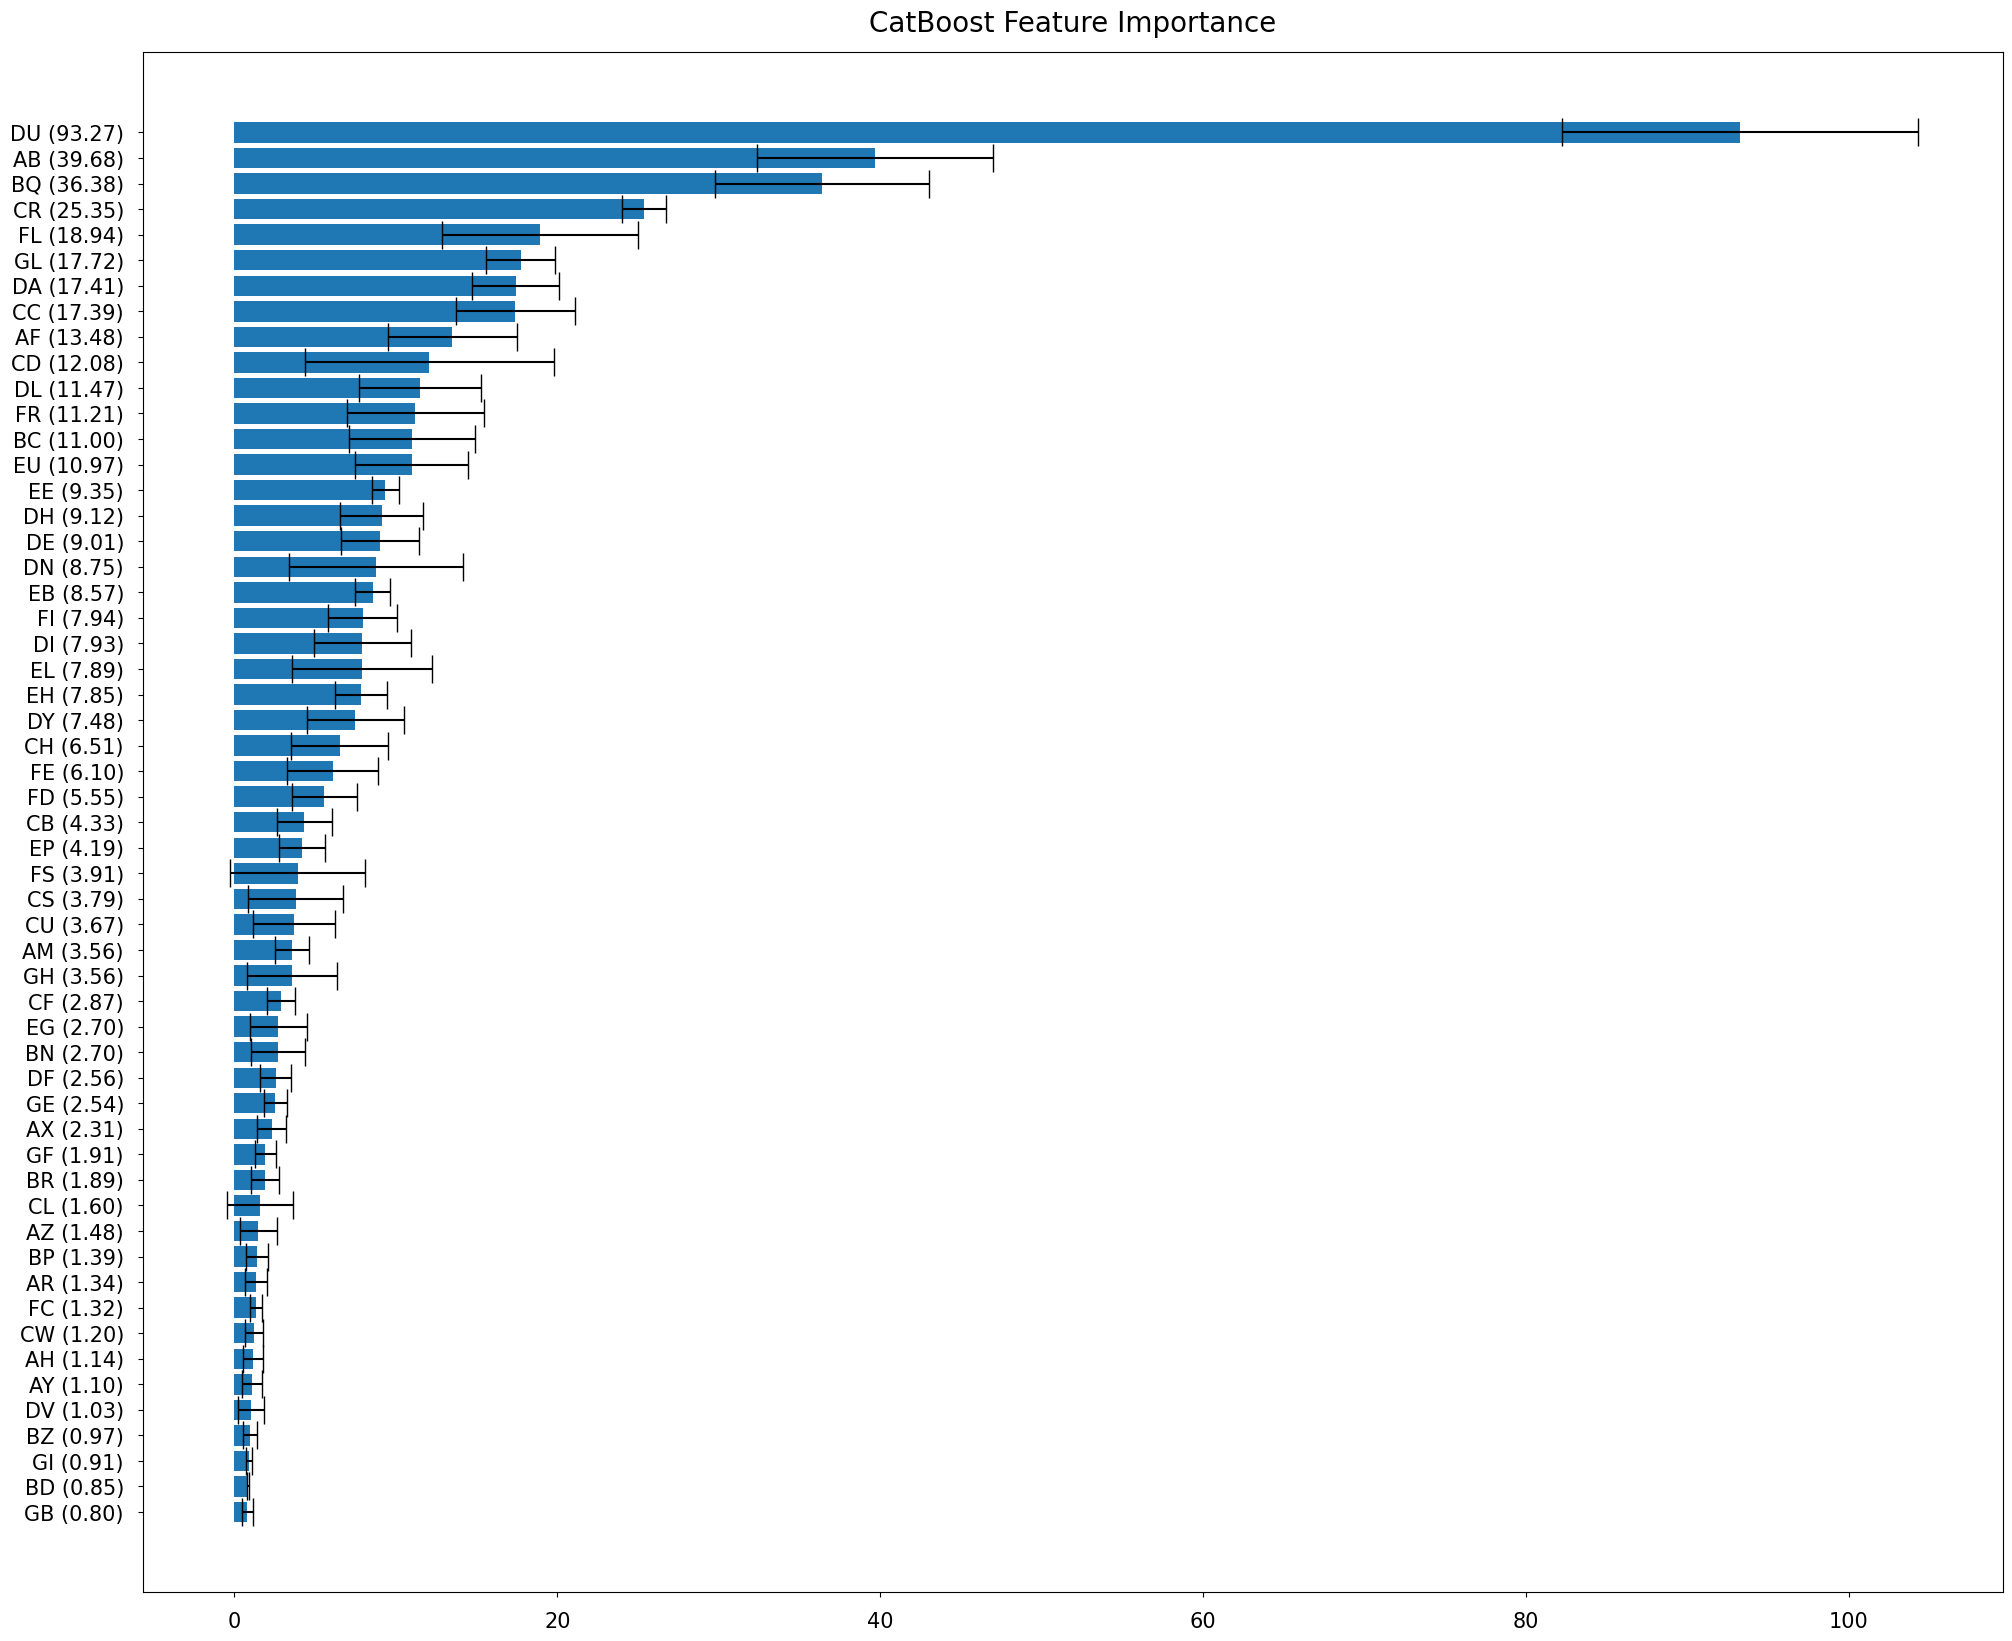

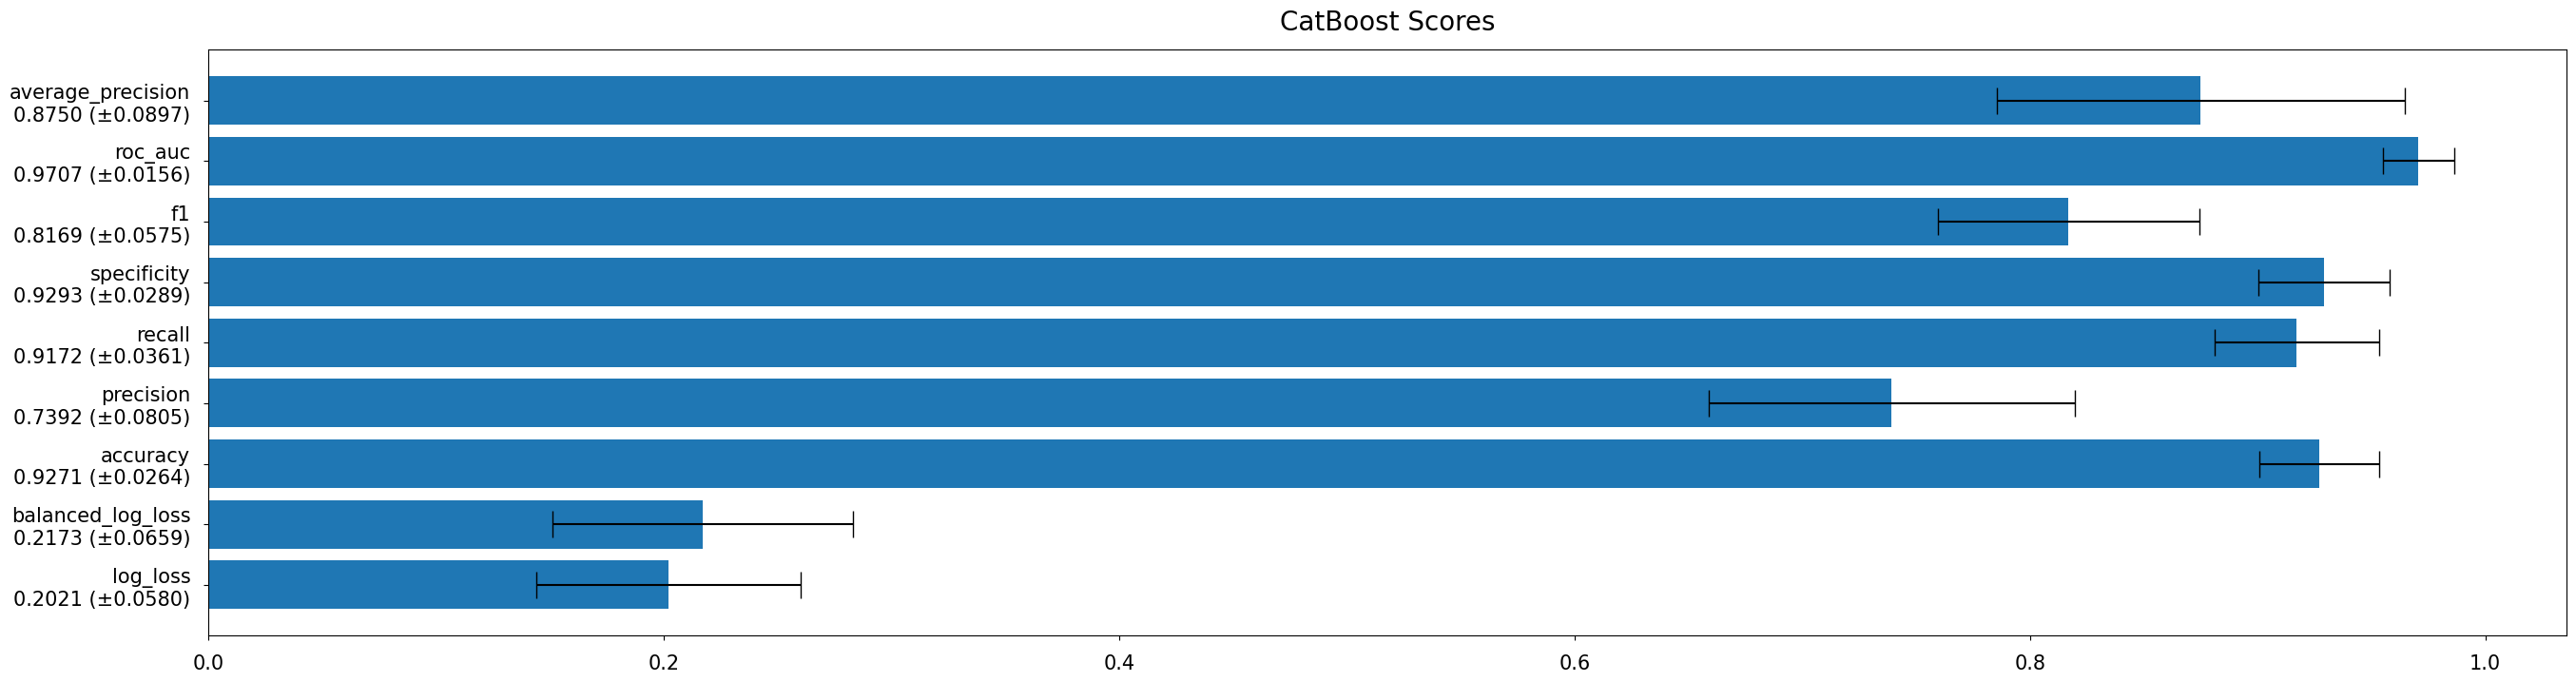

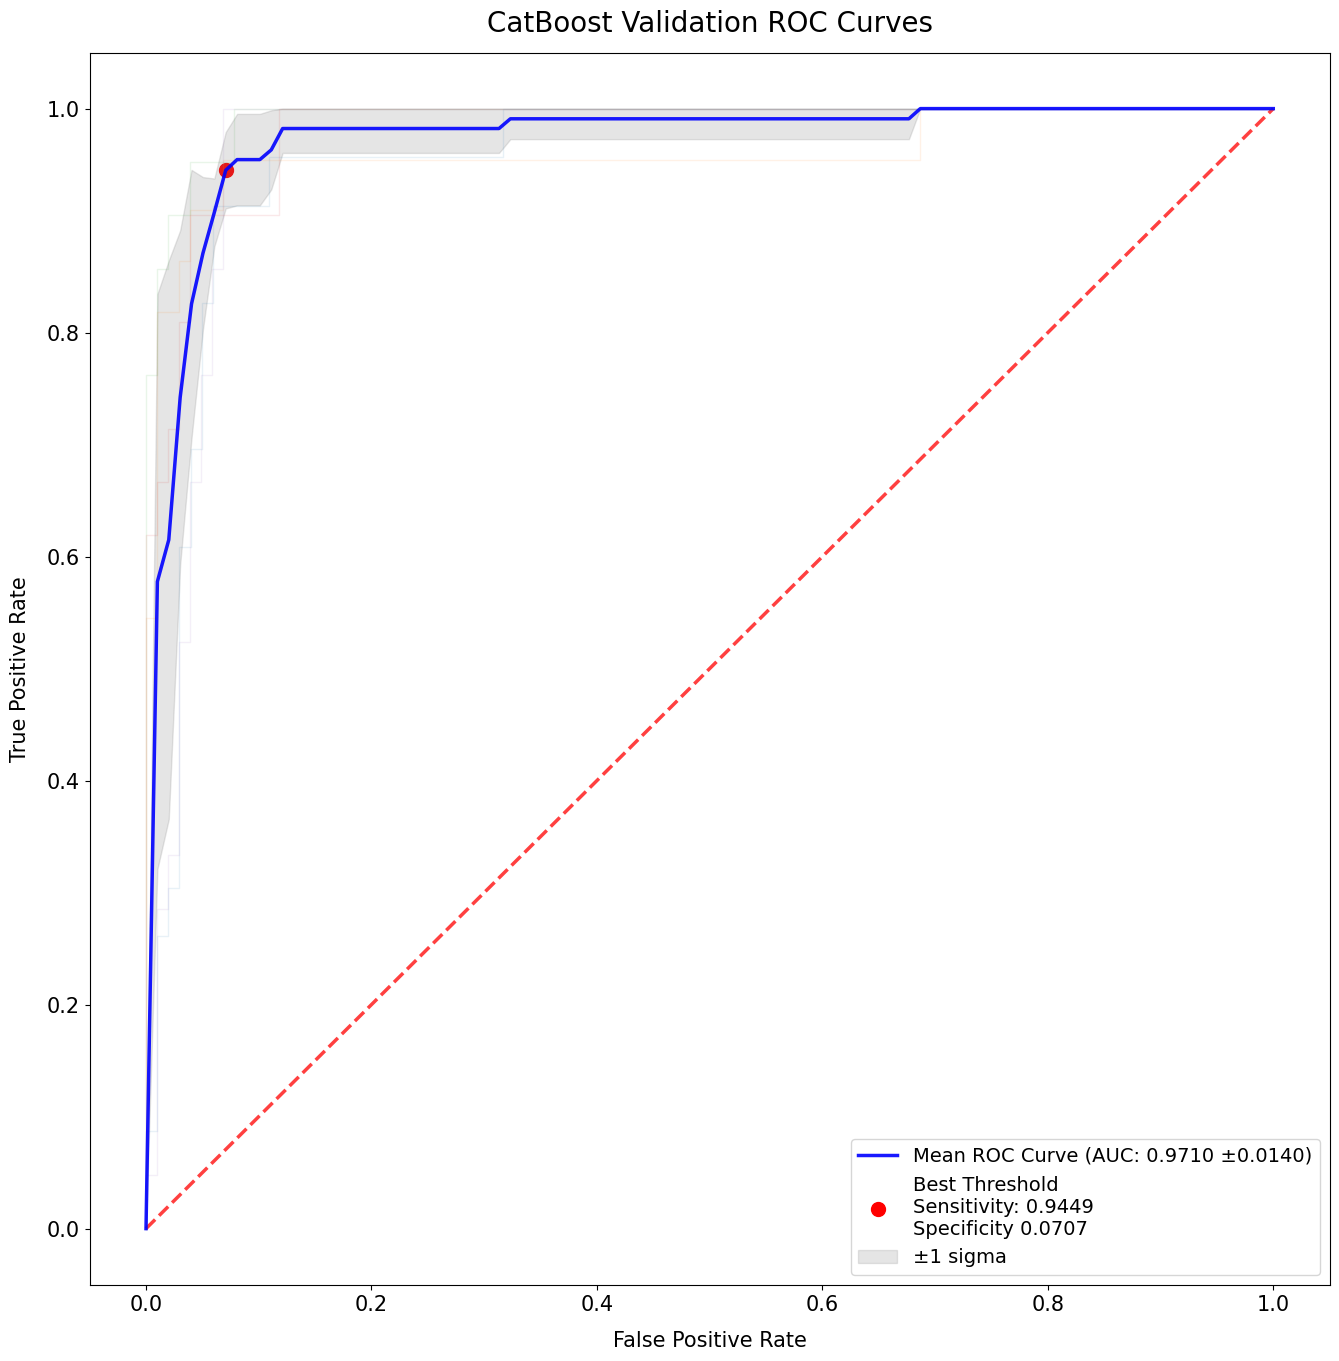

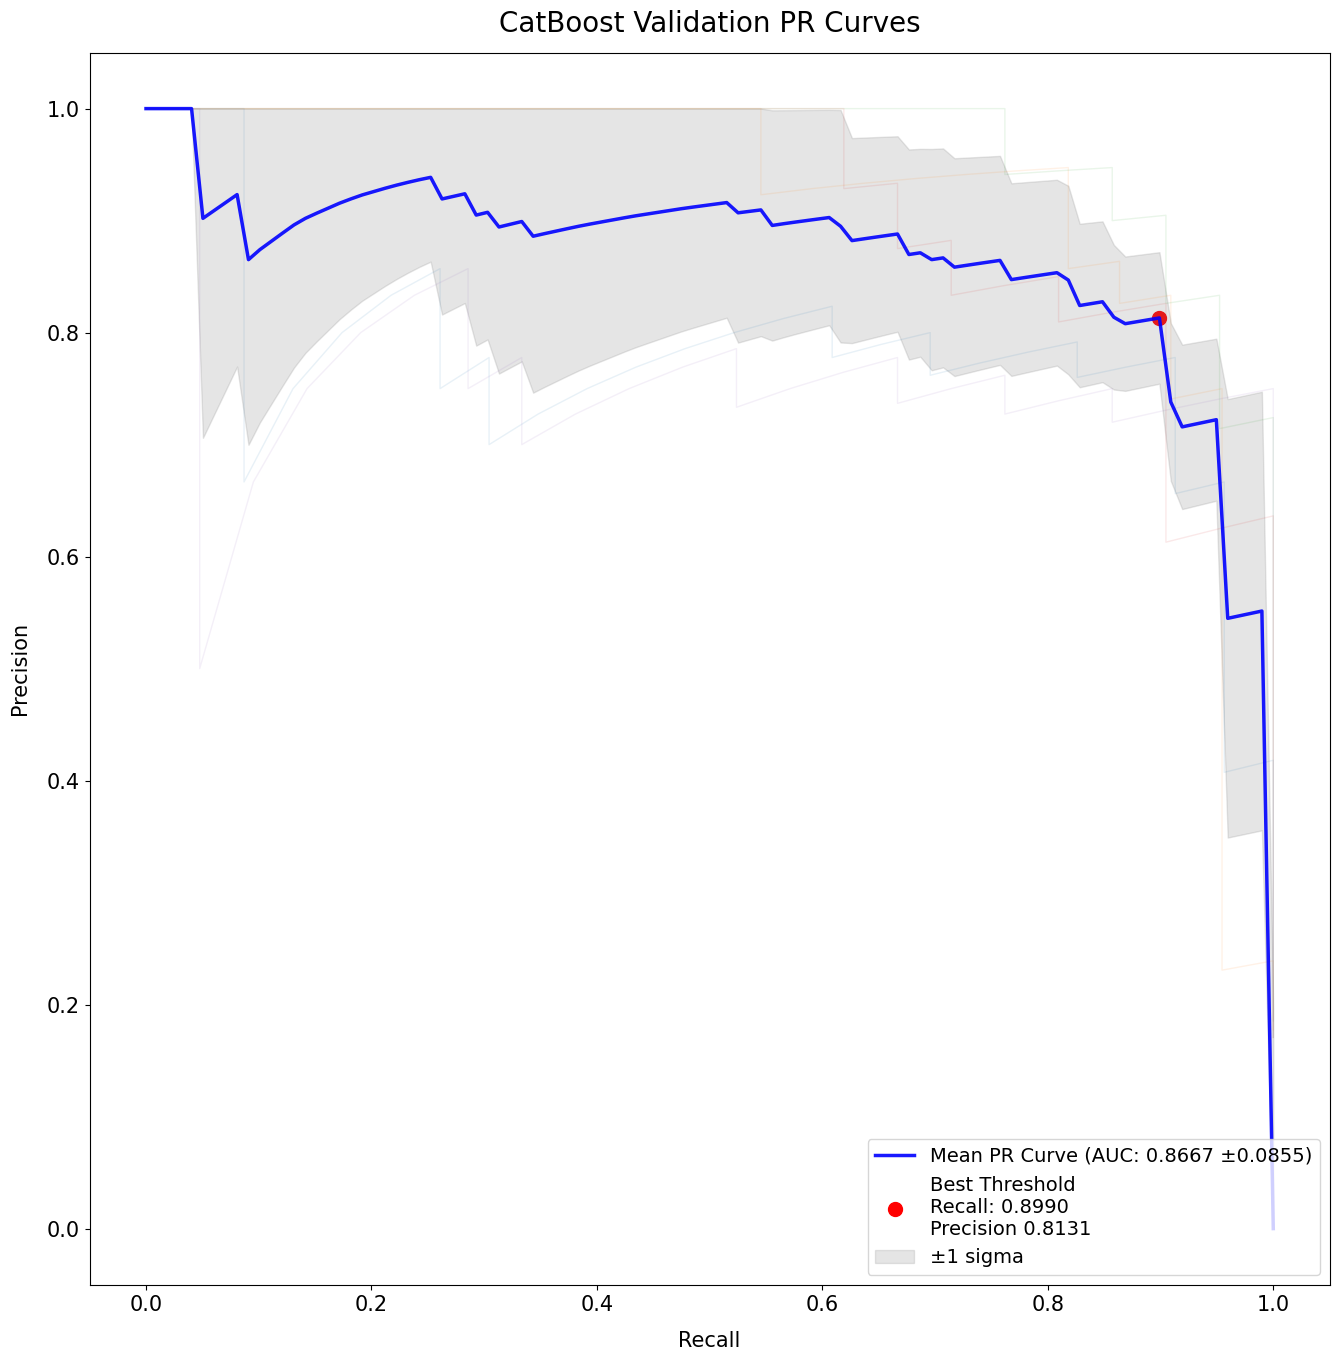

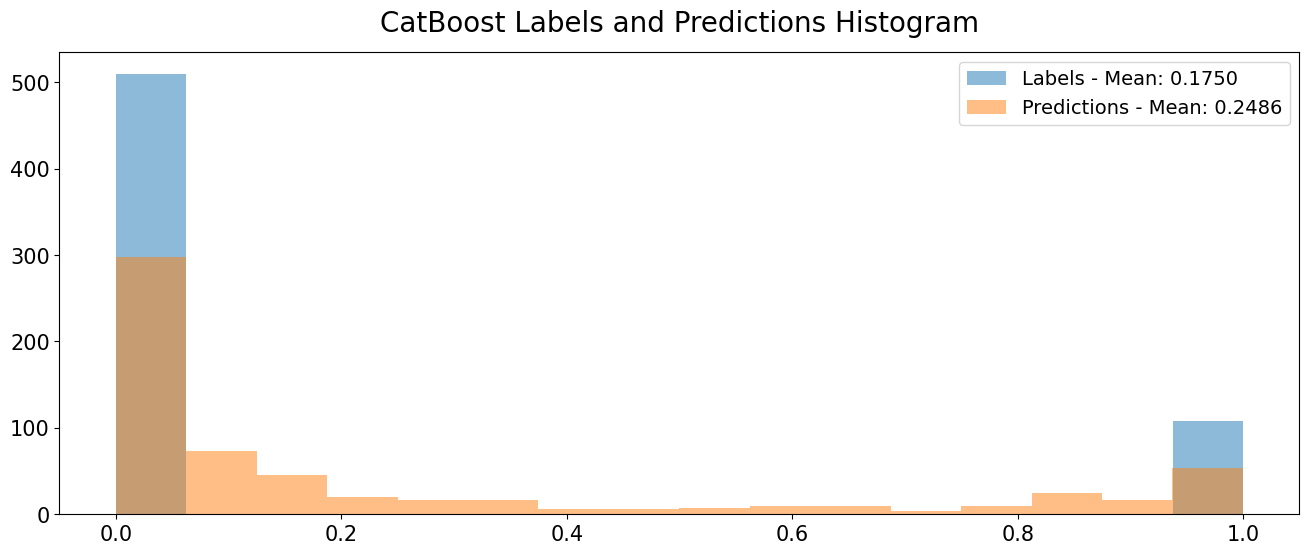

In [16]:
class CatBoostBalancedLogLoss:
    
    def is_max_optimal(self):
        False

    def evaluate(self, approxes, target, weight):  
        
        y_pred = np.array(approxes)
        y_true = np.array(target)
        #print(y_true)
        #print(y_pred)
        score = balanced_log_loss(y_true=y_true, y_pred=y_pred)

        return score, 1

    def get_final_error(self, error, weight):
        return error


catboost_features = [
    'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ',
    'BC', 'BD', 'BN', 'BP', 'BQ', 'BR', 'BZ',
    'CB', 'CC', 'CD', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU', 'CW',
    'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
    'EB', 'EE', 'EG', 'EH', 'EL', 'EP', 'EU',
    'FC', 'FD', 'FE', 'FI', 'FL', 'FR', 'FS',
    'GB', 'GE', 'GF', 'GH', 'GI', 'GL',
    #'Epsilon_timestamp'
]
catboost_target = 'Class'
catboost_folds = ['fold1', 'fold2', 'fold3', 'fold4', 'fold5']
catboost_seeds = [42, 0, 1337, 1962022, 721991]

catboost_model_parameters = {
    'iterations': 10000,
    'learning_rate': 0.02,
    'l2_leaf_reg': 5,
    'random_seed': None,
    'subsample': 0.9,
    'random_strength': 1,
    'depth': 3,
    'rsm': 0.9,
    'scale_pos_weight': 10,
    'boosting_type': 'Plain',
    'loss_function': 'Logloss',
    'boost_from_average': True,
    'langevin': True,
    'diffusion_temperature': 10000,
    'early_stopping_rounds': 500,
    'od_type': 'Iter',
    'thread_count': -1,
    'metric_period': 250
}

df_catboost_feature_importance = pd.DataFrame(
    data=np.zeros((len(catboost_features), len(catboost_folds))),
    index=catboost_features,
    columns=catboost_folds
)

catboost_scores = []
catboost_curves = []
catboost_best_iterations = []
catboost_positive_min_predictions = []
catboost_negative_max_predictions = []

for fold in catboost_folds:

    training_idx = df_train[fold] == 0
    validation_idx = df_train[fold] == 1

    print(
        f'''
        Fold: {fold}
        Training Shape: ({np.sum(training_idx)}, {len(catboost_features)}) - Target Mean: {df_train.loc[training_idx, catboost_target].mean():.4f}
        Validation: ({np.sum(validation_idx)}, {len(catboost_features)}) - Target Mean: {df_train.loc[validation_idx, catboost_target].mean():.4f}
        '''
    )
    
    val_predictions = np.zeros(np.sum(validation_idx))
    
    for seed in catboost_seeds:
                
        catboost_model_parameters.update({
            'random_seed': seed
        })
        
        training_dataset = cb.Pool(
            df_train.loc[training_idx, catboost_features],
            label=df_train.loc[training_idx, catboost_target]
        )
        validation_dataset = cb.Pool(
            df_train.loc[validation_idx, catboost_features],
            label=df_train.loc[validation_idx, catboost_target]
        )

        model = cb.train(
            params=catboost_model_parameters,
            dtrain=training_dataset,
            evals=[training_dataset, validation_dataset]            
        )
        catboost_best_iterations.append(model.best_iteration_)
        df_catboost_feature_importance[fold] += model.get_feature_importance()
        val_predictions += (model.predict(df_train.loc[validation_idx, catboost_features], prediction_type='Probability')[:, 1] / len(catboost_seeds))

    df_train.loc[validation_idx, 'catboost_prediction'] = val_predictions
    val_scores = classification_scores(
        y_true=df_train.loc[validation_idx, catboost_target],
        y_pred=df_train.loc[validation_idx, 'catboost_prediction'],
    )
    catboost_scores.append(val_scores)
    print(f'Fold {fold} - Validation Scores: {json.dumps(val_scores, indent=2)}')
    val_curves = classification_curves(
        y_true=df_train.loc[validation_idx, catboost_target],
        y_pred=df_train.loc[validation_idx, 'catboost_prediction'],
    )
    catboost_curves.append(val_curves)
    catboost_positive_min_predictions.append(df_train.loc[validation_idx & df_train[catboost_target] == 1, 'catboost_prediction'].min())
    catboost_negative_max_predictions.append(df_train.loc[validation_idx & df_train[catboost_target] == 0, 'catboost_prediction'].max())

df_catboost_scores = pd.DataFrame(catboost_scores)
print(
    f'''
    CatBoost Mean Validation Scores
    {json.dumps(df_catboost_scores.mean(axis=0).to_dict(), indent=2)}
    and Standard Deviations
    ±{json.dumps(df_catboost_scores.std(axis=0).to_dict(), indent=2)}
    '''
)

oof_scores = classification_scores(
    y_true=df_train.loc[:, catboost_target],
    y_pred=df_train.loc[:, 'catboost_prediction'],
)
print(f'OOF Scores: {json.dumps(oof_scores, indent=2)}')
print(f'Best Iterations {catboost_best_iterations} - Mean: {np.mean(catboost_best_iterations):.2f} Std: {np.std(catboost_best_iterations):.2f} Min: {np.min(catboost_best_iterations)} Max: {np.max(catboost_best_iterations)}')
print(f'Positive Min Predictions {catboost_positive_min_predictions} - Mean: {np.mean(catboost_positive_min_predictions):.2f} Std: {np.std(catboost_positive_min_predictions):.2f} Min: {np.min(catboost_positive_min_predictions)} Max: {np.max(catboost_positive_min_predictions)}')
print(f'Negative Max Predictions {catboost_negative_max_predictions} - Mean: {np.mean(catboost_negative_max_predictions):.2f} Std: {np.std(catboost_negative_max_predictions):.2f} Min: {np.min(catboost_negative_max_predictions)} Max: {np.max(catboost_negative_max_predictions)}')

df_catboost_feature_importance
df_catboost_feature_importance['mean'] = df_catboost_feature_importance[catboost_folds].mean(axis=1)
df_catboost_feature_importance['std'] = df_catboost_feature_importance[catboost_folds].std(axis=1).fillna(0)
df_catboost_feature_importance.sort_values(by='mean', ascending=False, inplace=True)
visualize_feature_importance(
    df_feature_importance=df_catboost_feature_importance,
    title=f'CatBoost Feature Importance'
)
    
visualize_scores(df_scores=df_catboost_scores, title='CatBoost Scores')
visualize_roc_curves(roc_curves=[curve['roc'] for curve in catboost_curves], title='CatBoost Validation ROC Curves')
visualize_pr_curves(pr_curves=[curve['pr'] for curve in catboost_curves], title='CatBoost Validation PR Curves')
visualize_predictions(y_true=df_train['Class'], y_pred=df_train['catboost_prediction'], title='CatBoost Labels and Predictions Histogram')

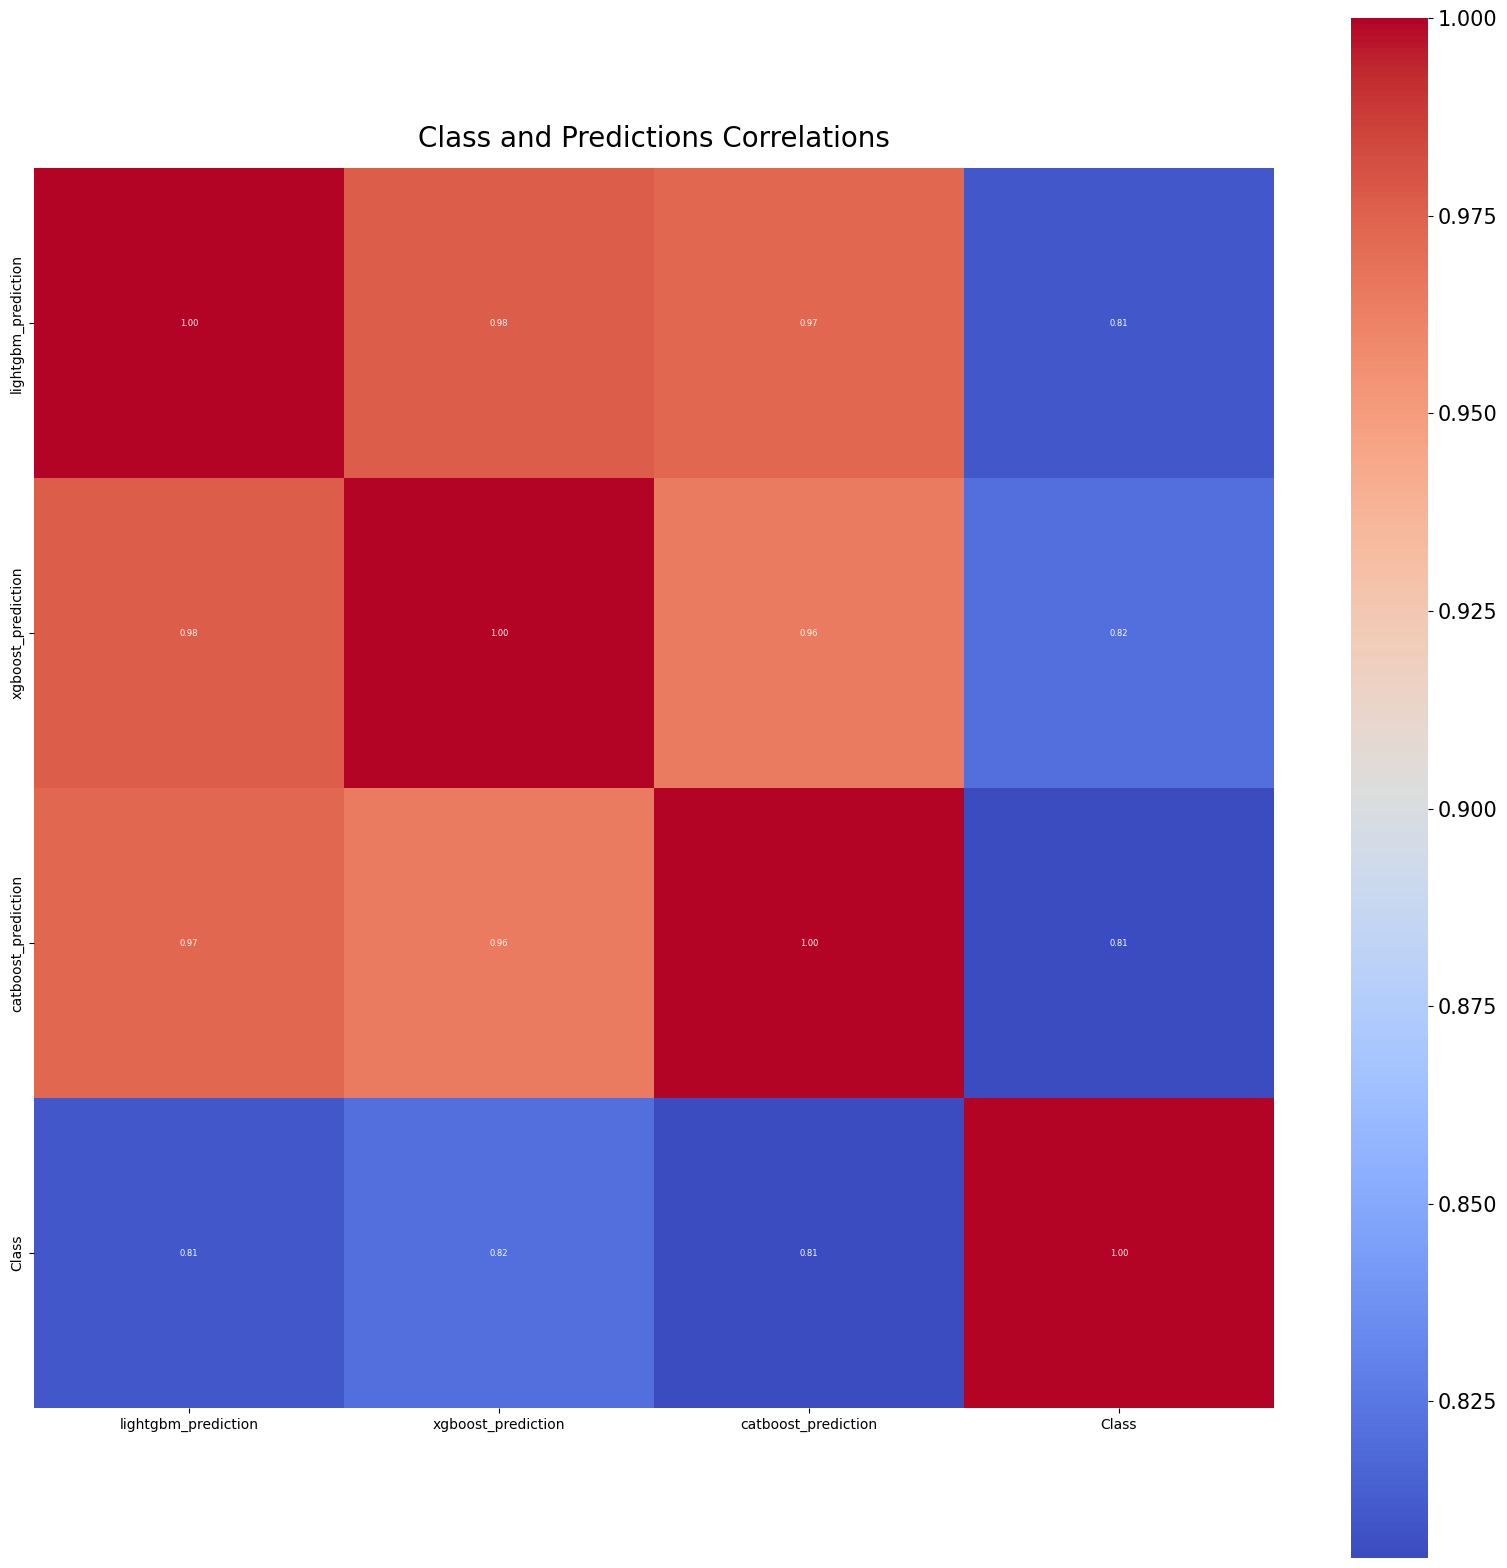

In [17]:
prediction_columns = [
    'lightgbm_prediction', 'xgboost_prediction', 'catboost_prediction'
]

visualize_correlations(df=df_train, columns=prediction_columns + ['Class'], title='Class and Predictions Correlations')

lightgbm_prediction OOF Scores: {
  "log_loss": 0.1809061091691485,
  "balanced_log_loss": 0.2132445359466787,
  "accuracy": 0.9303079416531604,
  "precision": 0.7443609022556391,
  "recall": 0.9166666666666666,
  "specificity": 0.9332023575638507,
  "f1": 0.8215767634854771,
  "roc_auc": 0.971658298770283,
  "average_precision": 0.8919388875964808
}
xgboost_prediction OOF Scores: {
  "log_loss": 0.17499697890098836,
  "balanced_log_loss": 0.2073849338217049,
  "accuracy": 0.9286871961102107,
  "precision": 0.7388059701492538,
  "recall": 0.9166666666666666,
  "specificity": 0.931237721021611,
  "f1": 0.8181818181818182,
  "roc_auc": 0.9723859419340756,
  "average_precision": 0.8890751446639601
}
catboost_prediction OOF Scores: {
  "log_loss": 0.20212280487003842,
  "balanced_log_loss": 0.2183456703101429,
  "accuracy": 0.9270664505672609,
  "precision": 0.7333333333333333,
  "recall": 0.9166666666666666,
  "specificity": 0.9292730844793713,
  "f1": 0.8148148148148148,
  "roc_auc": 0.9

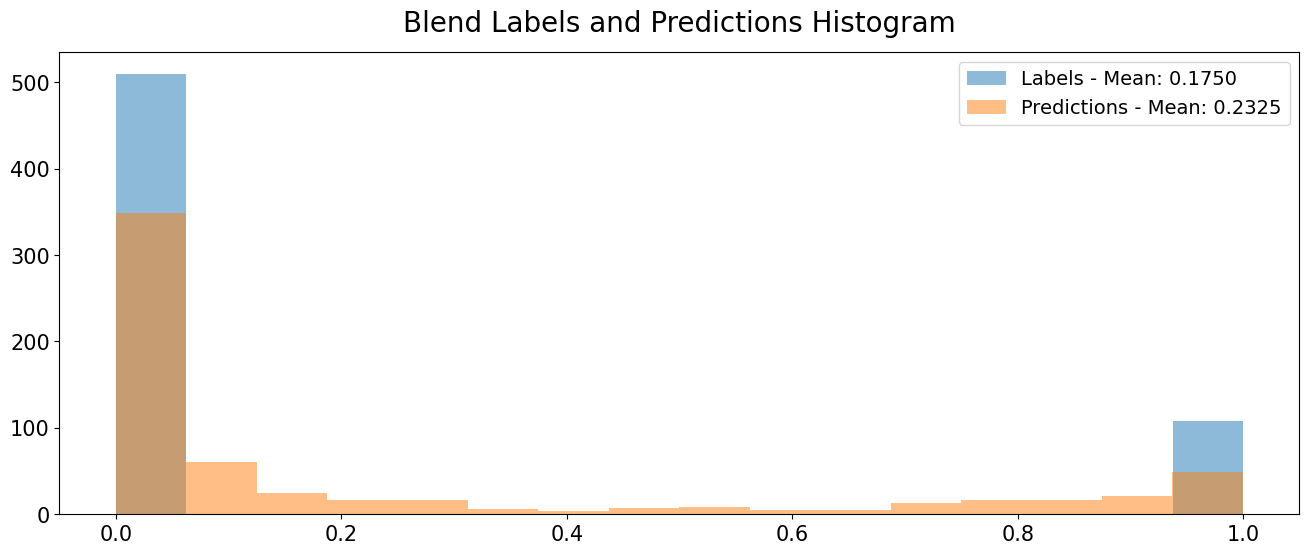

In [18]:
for prediction_column in prediction_columns:
    
    oof_scores = classification_scores(
        y_true=df_train.loc[:, 'Class'],
        y_pred=df_train.loc[:, prediction_column],
    )
    print(f'{prediction_column} OOF Scores: {json.dumps(oof_scores, indent=2)}')
    
print(f'\nLightGBM Positive Min Predictions {lightgbm_positive_min_predictions} - Mean: {np.mean(lightgbm_positive_min_predictions):.2f} Std: {np.std(lightgbm_positive_min_predictions):.2f} Min: {np.min(lightgbm_positive_min_predictions)} Max: {np.max(lightgbm_positive_min_predictions)}')
print(f'XGBoost Positive Min Predictions {xgboost_positive_min_predictions} - Mean: {np.mean(xgboost_positive_min_predictions):.2f} Std: {np.std(xgboost_positive_min_predictions):.2f} Min: {np.min(xgboost_positive_min_predictions)} Max: {np.max(xgboost_positive_min_predictions)}')
print(f'CatBoost Positive Min Predictions {catboost_positive_min_predictions} - Mean: {np.mean(catboost_positive_min_predictions):.2f} Std: {np.std(catboost_positive_min_predictions):.2f} Min: {np.min(catboost_positive_min_predictions)} Max: {np.max(catboost_positive_min_predictions)}')

print(f'\nLightGBM Negative Max Predictions {lightgbm_negative_max_predictions} - Mean: {np.mean(lightgbm_negative_max_predictions):.2f} Std: {np.std(lightgbm_negative_max_predictions):.2f} Min: {np.min(lightgbm_negative_max_predictions)} Max: {np.max(lightgbm_negative_max_predictions)}')
print(f'XGBoost Negative Max Predictions {xgboost_negative_max_predictions} - Mean: {np.mean(xgboost_negative_max_predictions):.2f} Std: {np.std(xgboost_negative_max_predictions):.2f} Min: {np.min(xgboost_negative_max_predictions)} Max: {np.max(xgboost_negative_max_predictions)}')
print(f'CatBoost Negative Max Predictions {catboost_negative_max_predictions} - Mean: {np.mean(catboost_negative_max_predictions):.2f} Std: {np.std(catboost_negative_max_predictions):.2f} Min: {np.min(catboost_negative_max_predictions)} Max: {np.max(catboost_negative_max_predictions)}')

lightgbm_weight = 0.34
xgboost_weight = 0.33
catboost_weight = 0.33

df_train['blend_prediction'] = df_train['lightgbm_prediction'] * lightgbm_weight +\
                               df_train['xgboost_prediction'] * xgboost_weight +\
                               df_train['catboost_prediction'] * catboost_weight

oof_scores = classification_scores(
    y_true=df_train.loc[:, 'Class'],
    y_pred=df_train.loc[:, 'blend_prediction'],
)
print(f'OOF Scores: {json.dumps(oof_scores, indent=2)}')
visualize_predictions(y_true=df_train['Class'], y_pred=df_train['blend_prediction'], title='Blend Labels and Predictions Histogram')

## 7. Training and Submission

In [19]:
df_test['Class'] = np.nan

if is_submission:
    df_test.loc[0, 'Class'] = np.nan
    df_test.loc[1, 'Class'] = 0
    df_test.loc[2, 'Class'] = 0
    df_test.loc[3, 'Class'] = np.nan
    df_test.loc[4, 'Class'] = np.nan
    df_test.loc[5, 'Class'] = np.nan
    df_test.loc[6, 'Class'] = 0
    df_test.loc[7, 'Class'] = np.nan
    df_test.loc[8, 'Class'] = np.nan
    df_test.loc[9, 'Class'] = 0
    df_test.loc[10, 'Class'] = 0
    df_test.loc[11, 'Class'] = np.nan
    df_test.loc[12, 'Class'] = 0
    df_test.loc[13, 'Class'] = np.nan
    df_test.loc[14, 'Class'] = 1
    df_test.loc[15, 'Class'] = 0
    df_test.loc[16, 'Class'] = 0
    df_test.loc[17, 'Class'] = np.nan
    df_test.loc[18, 'Class'] = np.nan
    df_test.loc[19, 'Class'] = np.nan
    df_test.loc[20, 'Class'] = 0
    #df_test.loc[21, 'Class'] = np.nan # Throws error
    df_test.loc[22, 'Class'] = np.nan
    df_test.loc[23, 'Class'] = 0
    df_test.loc[24, 'Class'] = 0
    df_test.loc[25, 'Class'] = np.nan
    df_test.loc[26, 'Class'] = 1
    df_test.loc[27, 'Class'] = 0
    df_test.loc[28, 'Class'] = 0
    df_test.loc[29, 'Class'] = np.nan
    df_test.loc[30, 'Class'] = np.nan
    df_test.loc[31, 'Class'] = np.nan
    df_test.loc[32, 'Class'] = 1
    df_test.loc[33, 'Class'] = np.nan
    df_test.loc[34, 'Class'] = 0
    df_test.loc[35, 'Class'] = np.nan
    df_test.loc[36, 'Class'] = np.nan
    df_test.loc[37, 'Class'] = 0
    df_test.loc[38, 'Class'] = np.nan
    df_test.loc[39, 'Class'] = 0
    df_test.loc[40, 'Class'] = np.nan
    df_test.loc[41, 'Class'] = np.nan
    df_test.loc[42, 'Class'] = 1
    df_test.loc[43, 'Class'] = np.nan
    df_test.loc[44, 'Class'] = 0
    df_test.loc[45, 'Class'] = 0
    df_test.loc[46, 'Class'] = 0
    df_test.loc[47, 'Class'] = np.nan
    df_test.loc[48, 'Class'] = np.nan
    df_test.loc[49, 'Class'] = np.nan
    df_test.loc[50, 'Class'] = 0
    df_test.loc[51, 'Class'] = np.nan
    df_test.loc[52, 'Class'] = np.nan
    df_test.loc[53, 'Class'] = 0
    df_test.loc[54, 'Class'] = np.nan
    df_test.loc[55, 'Class'] = 0
    df_test.loc[56, 'Class'] = np.nan
    df_test.loc[57, 'Class'] = 0
    df_test.loc[58, 'Class'] = 0
    df_test.loc[59, 'Class'] = np.nan
    df_test.loc[60, 'Class'] = np.nan
    df_test.loc[61, 'Class'] = np.nan
    df_test.loc[62, 'Class'] = np.nan
    df_test.loc[63, 'Class'] = np.nan
    df_test.loc[64, 'Class'] = np.nan
    #df_test.loc[65, 'Class'] = np.nan # Throws error
    df_test.loc[66, 'Class'] = 0
    df_test.loc[67, 'Class'] = np.nan
    df_test.loc[68, 'Class'] = np.nan
    df_test.loc[69, 'Class'] = 0
    df_test.loc[70, 'Class'] = np.nan
    df_test.loc[71, 'Class'] = 1
    df_test.loc[72, 'Class'] = 0
    df_test.loc[73, 'Class'] = np.nan
    df_test.loc[74, 'Class'] = np.nan
    df_test.loc[75, 'Class'] = np.nan
    df_test.loc[76, 'Class'] = 0
    

In [20]:
df_train_submission = pd.concat((
    df_train,
    df_test.loc[df_test['Class'].notna()].copy(deep=True)
), axis=0, ignore_index=True)

df_train_submission

Id     AB         AF       AH       AM      AR     AX     AY  \
0    000ff2bfdfe9   49.0  1284724.5   9783.0   7231.0  1552.0   79.0   42.0   
1    007255e47698   34.0   404448.0   9783.0  11937.0  1552.0  410.0   42.0   
2    013f2bd269f5  110.0  1088887.0   9783.0  10449.0  1552.0  760.0   42.0   
3    043ac50845d5   59.0  1578368.5  13802.0  24899.0  1552.0  416.0   42.0   
4    044fb8a146ec   89.0  1542582.0   9783.0   4554.0  1552.0  445.0   90.0   
..            ...    ...        ...      ...      ...     ...    ...    ...   
612  fd3dafe738fd   35.0  1293413.0  14211.0   3072.0  2483.0  395.0  127.0   
613  fd895603f071  102.0  2257039.0   9783.0  15031.0  3046.0  675.0   42.5   
614  fd8ef6377f76  100.0  1016160.0  14943.0  17874.0  1908.0  911.0   42.0   
615  fe1942975e40   85.0   522122.0   9783.0   7648.0  1552.0  901.0   42.0   
616  ffcca4ded3bb  113.0  1104353.0  62770.0  36166.0  1552.0  361.0  192.0   

         AZ       BC  ...  fold2  fold3  fold4  fold5  fold6  \
0    1557.0    790.5  ...    0.0    0.0    0.0    0.0    0.0   
1    2145.0    175.0  ...    1.0    0.0    0.0    0.0    0.0   
2    2035.0    175.0  ...    0.0    0.0    0.0    1.0    0.0   
3    1754.0    175.0  ...    0.0    0.0    0.0    0.0    0.0   
4     539.0  14535.0  ...    0.0    1.0    0.0    0.0    0.0   
..      ...      ...  ...    ...    ...    ...    ...    ...   
612  1356.0    399.0  ...    0.0    0.0    0.0    0.0    0.0   
613  2003.0    537.5  ...    0.0    0.0    0.0    1.0    0.0   
614  2445.0    175.0  ...    0.0    1.0    0.0    0.0    0.0   
615  1194.0    175.0  ...    0.0    0.0    0.0    1.0    0.0   
616   539.0   1131.0  ...    0.0    0.0    0.0    1.0    0.0   

     Epsilon_timestamp  lightgbm_prediction  xgboost_prediction  \
0          215740800.0             0.964706            0.967895   
1                  NaN             0.001921            0.003039   
2                  NaN             0.343173            0.176139   
3                  NaN             0.093979            0.091106   
4          247881600.0             0.441608            0.603508   
..                 ...                  ...                 ...   
612        262742400.0             0.142953            0.049693   
613        262310400.0             0.139585            0.008137   
614        226713600.0             0.002316            0.004475   
615        211680000.0             0.032089            0.001777   
616                NaN             0.035973            0.013398   

     catboost_prediction  blend_prediction  
0               0.943071          0.958619  
1               0.008175          0.004354  
2               0.375131          0.298598  
3               0.363213          0.181878  
4               0.881961          0.640352  
..                   ...               ...  
612             0.170908          0.121403  
613             0.203730          0.117375  
614             0.000764          0.002517  
615             0.028366          0.020858  
616             0.058293          0.035889  

[617 rows x 74 columns]

In [21]:
lightgbm_test_predictions = np.zeros(len(df_test))

for seed in lightgbm_seeds:
                
    lightgbm_model_parameters.update({
        'seed': seed,
        'feature_fraction_seed': seed,
        'bagging_seed': seed,
        'drop_seed': seed,
        'data_random_seed': seed,
    })

    lightgbm_submission_training_dataset = lgb.Dataset(
        df_train_submission[lightgbm_features],
        label=df_train_submission[lightgbm_target],
        weight=lightgbm_sample_weight,
        categorical_feature=lightgbm_categorical_features
    )

    lightgbm_submission_model = lgb.train(
        params=lightgbm_model_parameters,
        train_set=lightgbm_submission_training_dataset,
        valid_sets=[lightgbm_submission_training_dataset],
        num_boost_round=int(np.mean(lightgbm_best_iterations)),
        callbacks=[
            lgb.log_evaluation(lightgbm_fit_parameters['log_evaluation'])
        ],
        feval=lightgbm_balanced_log_loss
    )

    lightgbm_test_predictions += (lightgbm_submission_model.predict(df_test[lightgbm_features]) / len(lightgbm_seeds))
    
df_test['lightgbm_prediction'] = lightgbm_test_predictions

[LightGBM] [Info] Number of positive: 108, number of negative: 509
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9432
[LightGBM] [Info] Number of data points in the train set: 617, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.175041 -> initscore=-1.550317
[LightGBM] [Info] Start training from score -1.550317
[250]	training's balanced_log_loss: 0.217053
[500]	training's balanced_log_loss: 0.122748
[750]	training's balanced_log_loss: 0.0689023
[1000]	training's balanced_log_loss: 0.0404265
[LightGBM] [Info] Number of positive: 108, number of negative: 509
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9432
[LightGBM] [Info] Number of data points in the train set: 61

In [22]:
xgboost_test_predictions = np.zeros(len(df_test))

for seed in xgboost_seeds:
                
    xgboost_model_parameters.update({
        'seed': seed
    })

    xgboost_submission_training_dataset = xgb.DMatrix(
        df_train_submission[xgboost_features],
        label=df_train_submission[xgboost_target]
    )

    xgboost_submission_model = xgb.train(
        params=xgboost_model_parameters,
        dtrain=xgboost_submission_training_dataset,
        evals=[(xgboost_submission_training_dataset, 'train')],
        num_boost_round=int(np.mean(xgboost_best_iterations)),
        early_stopping_rounds=None,
        verbose_eval=xgboost_fit_parameters['verbose_eval'],
        custom_metric=xgboost_balanced_log_loss,
        maximize=False 
    )

    xgboost_test_predictions += (xgboost_submission_model.predict(xgb.DMatrix(df_test[xgboost_features])) / len(xgboost_seeds))
    
df_test['xgboost_prediction'] = xgboost_test_predictions

[0]	train-balanced_log_loss:0.68733
[250]	train-balanced_log_loss:0.22416
[500]	train-balanced_log_loss:0.11966
[750]	train-balanced_log_loss:0.07270
[1000]	train-balanced_log_loss:0.05041
[1250]	train-balanced_log_loss:0.03972
[1500]	train-balanced_log_loss:0.03360
[1750]	train-balanced_log_loss:0.02934
[2000]	train-balanced_log_loss:0.02688
[2250]	train-balanced_log_loss:0.02539
[2491]	train-balanced_log_loss:0.02432
[0]	train-balanced_log_loss:0.68688
[250]	train-balanced_log_loss:0.22734
[500]	train-balanced_log_loss:0.12206
[750]	train-balanced_log_loss:0.07358
[1000]	train-balanced_log_loss:0.05091
[1250]	train-balanced_log_loss:0.04039
[1500]	train-balanced_log_loss:0.03401
[1750]	train-balanced_log_loss:0.02975
[2000]	train-balanced_log_loss:0.02695
[2250]	train-balanced_log_loss:0.02546
[2491]	train-balanced_log_loss:0.02441
[0]	train-balanced_log_loss:0.68740
[250]	train-balanced_log_loss:0.22762
[500]	train-balanced_log_loss:0.12125
[750]	train-balanced_log_loss:0.07381
[100

In [23]:
catboost_test_predictions = np.zeros(len(df_test))

for seed in catboost_seeds:
                
    catboost_model_parameters.update({
        'random_seed': seed,
        'early_stopping_rounds': 10000,
        'iterations': int(np.mean(catboost_best_iterations))
    })

    catboost_submission_training_dataset = cb.Pool(
        df_train_submission[catboost_features],
        label=df_train_submission[catboost_target]
    )

    catboost_submission_model = cb.train(
        params=catboost_model_parameters,
        dtrain=training_dataset,
        evals=[training_dataset]            
    )

    catboost_test_predictions += (catboost_submission_model.predict(df_test[catboost_features], prediction_type='Probability')[:, 1] / len(catboost_seeds))
    
df_test['catboost_prediction'] = catboost_test_predictions

0:	learn: 0.6198378	test: 0.6198039	best: 0.6198039 (0)	total: 1.89ms	remaining: 3.16s
250:	learn: 0.1633910	test: 0.1634195	best: 0.1634195 (250)	total: 275ms	remaining: 1.55s
500:	learn: 0.0819791	test: 0.0820145	best: 0.0820145 (500)	total: 548ms	remaining: 1.28s
750:	learn: 0.0473319	test: 0.0473781	best: 0.0473781 (750)	total: 829ms	remaining: 1.01s
1000:	learn: 0.0292411	test: 0.0292891	best: 0.0292891 (1000)	total: 1.1s	remaining: 734ms
1250:	learn: 0.0204183	test: 0.0204741	best: 0.0204741 (1250)	total: 1.37s	remaining: 459ms
1500:	learn: 0.0164618	test: 0.0165145	best: 0.0165145 (1500)	total: 1.63s	remaining: 183ms
1669:	learn: 0.0138003	test: 0.0138410	best: 0.0138410 (1669)	total: 1.81s	remaining: 0us

bestTest = 0.01384095486
bestIteration = 1669



0:	learn: 0.6180471	test: 0.6180175	best: 0.6180175 (0)	total: 1.3ms	remaining: 2.17s
250:	learn: 0.1662469	test: 0.1662667	best: 0.1662667 (250)	total: 278ms	remaining: 1.57s
500:	learn: 0.0808959	test: 0.0809353	best: 0.0809353 (500)	total: 550ms	remaining: 1.28s
750:	learn: 0.0425736	test: 0.0426435	best: 0.0426435 (750)	total: 824ms	remaining: 1.01s
1000:	learn: 0.0270827	test: 0.0271413	best: 0.0271413 (1000)	total: 1.09s	remaining: 732ms
1250:	learn: 0.0197799	test: 0.0198487	best: 0.0198487 (1250)	total: 1.37s	remaining: 460ms
1500:	learn: 0.0153427	test: 0.0154034	best: 0.0154034 (1500)	total: 1.64s	remaining: 185ms
1669:	learn: 0.0131187	test: 0.0131773	best: 0.0131773 (1669)	total: 1.83s	remaining: 0us

bestTest = 0.01317727289
bestIteration = 1669



0:	learn: 0.6116344	test: 0.6116030	best: 0.6116030 (0)	total: 1.44ms	remaining: 2.4s
250:	learn: 0.1682940	test: 0.1683128	best: 0.1683128 (250)	total: 281ms	remaining: 1.59s
500:	learn: 0.0841986	test: 0.0842395	best: 0.0842395 (500)	total: 554ms	remaining: 1.29s
750:	learn: 0.0455319	test: 0.0455875	best: 0.0455875 (750)	total: 827ms	remaining: 1.01s
1000:	learn: 0.0292350	test: 0.0292855	best: 0.0292855 (1000)	total: 1.1s	remaining: 736ms
1250:	learn: 0.0209479	test: 0.0210151	best: 0.0210151 (1250)	total: 1.37s	remaining: 460ms
1500:	learn: 0.0163870	test: 0.0164442	best: 0.0164436 (1498)	total: 1.64s	remaining: 184ms
1669:	learn: 0.0140114	test: 0.0140647	best: 0.0140629 (1666)	total: 1.8s	remaining: 0us

bestTest = 0.01406292001
bestIteration = 1666

Shrink model to first 1667 iterations.


0:	learn: 0.6180294	test: 0.6179980	best: 0.6179980 (0)	total: 1.29ms	remaining: 2.15s
250:	learn: 0.1705461	test: 0.1705864	best: 0.1705864 (250)	total: 278ms	remaining: 1.57s
500:	learn: 0.0802555	test: 0.0803054	best: 0.0803054 (500)	total: 554ms	remaining: 1.29s
750:	learn: 0.0426515	test: 0.0427135	best: 0.0427135 (750)	total: 827ms	remaining: 1.01s
1000:	learn: 0.0271699	test: 0.0272274	best: 0.0272274 (1000)	total: 1.1s	remaining: 735ms
1250:	learn: 0.0191206	test: 0.0191793	best: 0.0191786 (1249)	total: 1.37s	remaining: 459ms
1500:	learn: 0.0147337	test: 0.0147876	best: 0.0147876 (1500)	total: 1.64s	remaining: 185ms
1669:	learn: 0.0128146	test: 0.0128755	best: 0.0128755 (1669)	total: 1.82s	remaining: 0us

bestTest = 0.01287550392
bestIteration = 1669



0:	learn: 0.6176115	test: 0.6175771	best: 0.6175771 (0)	total: 1.44ms	remaining: 2.4s
250:	learn: 0.1682207	test: 0.1682187	best: 0.1682187 (250)	total: 278ms	remaining: 1.57s
500:	learn: 0.0833189	test: 0.0833593	best: 0.0833593 (500)	total: 543ms	remaining: 1.27s
750:	learn: 0.0412517	test: 0.0413072	best: 0.0413072 (750)	total: 820ms	remaining: 1s
1000:	learn: 0.0268139	test: 0.0268767	best: 0.0268767 (1000)	total: 1.09s	remaining: 731ms
1250:	learn: 0.0196653	test: 0.0197282	best: 0.0197282 (1250)	total: 1.36s	remaining: 457ms
1500:	learn: 0.0154345	test: 0.0154944	best: 0.0154925 (1497)	total: 1.61s	remaining: 182ms
1669:	learn: 0.0130570	test: 0.0131080	best: 0.0131080 (1669)	total: 1.8s	remaining: 0us

bestTest = 0.01310799549
bestIteration = 1669



In [24]:
df_test['blend_prediction'] = df_test['lightgbm_prediction'] * lightgbm_weight +\
                              df_test['xgboost_prediction'] * xgboost_weight +\
                              df_test['catboost_prediction'] * catboost_weight

df_test['prediction'] = df_test['blend_prediction'].values
df_test.loc[df_test['Class'].notna(), 'prediction'] = df_test.loc[df_test['Class'].notna(), 'Class']
df_test['class_1'] = df_test['prediction'].values
df_test['class_0'] = 1 - df_test['class_1']
df_test

Id   AB   AF   AH   AM   AR   AX   AY   AZ   BC  ...   GL  \
0  00eed32682bb  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
1  010ebe33f668  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
2  02fa521e1838  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
3  040e15f562a2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
4  046e85c7cc7f  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   

   Epsilon_timestamp  Class  lightgbm_prediction  xgboost_prediction  \
0        264124801.0    NaN             0.167786            0.351436   
1        264124801.0    NaN             0.167786            0.351436   
2        264124801.0    NaN             0.167786            0.351436   
3        264124801.0    NaN             0.167786            0.351436   
4        264124801.0    NaN             0.167786            0.351436   

   catboost_prediction  blend_prediction  prediction   class_1   class_0  
0             0.065713          0.194707    0.194707  0.194707  0.805293  
1             0.065713          0.194707    0.194707  0.194707  0.805293  
2             0.065713          0.194707    0.194707  0.194707  0.805293  
3             0.065713          0.194707    0.194707  0.194707  0.805293  
4             0.065713          0.194707    0.194707  0.194707  0.805293  

[5 rows x 66 columns]

## 8. Submission

In [25]:
df_submission = df_test[['Id', 'class_0', 'class_1']]
df_submission

Id   class_0   class_1
0  00eed32682bb  0.805293  0.194707
1  010ebe33f668  0.805293  0.194707
2  02fa521e1838  0.805293  0.194707
3  040e15f562a2  0.805293  0.194707
4  046e85c7cc7f  0.805293  0.194707

In [26]:
df_submission.to_csv('submission.csv', index=False)